In [2]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import glob
import time
import copy
import random
import astroalign as aa
import pickle
import seaborn as sns
import os.path
import jakeGloess as jg
from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.table import Table, join, MaskedColumn, vstack
from astropy.nddata import NDData
from astropy.visualization import simple_norm
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import wcs
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky
from astropy.time import Time
from astropy.io.votable import parse, parse_single_table
from astroquery.irsa_dust import IrsaDust
from photutils import DAOStarFinder
from photutils import CircularAperture, CircularAnnulus, RectangularAperture
from photutils import aperture_photometry
from photutils.psf import IterativelySubtractedPSFPhotometry as ISPSF
from photutils.psf import extract_stars
from photutils.psf.groupstars import DAOGroup
from photutils import EPSFBuilder
from photutils.background import MMMBackground
from photutils.utils import make_random_cmap

### Functions:

In [3]:
# could add a check to see if apertures need to be plotted (in case i want to plot just the fits)
def plotting(region, ap, an, cmap, choice, savename):
    plt.imshow(region, cmap=cmap, origin='lower', norm=LogNorm(), interpolation='nearest')
    
    if choice == 'ap_only':
        ap.plot(color='blue', lw=.5, alpha=1.)
    elif choice == 'both_aps':
        ap.plot(color='blue', lw=.5, alpha=.5)
        an.plot(color='red', lw=.5, alpha=.5)
        
    plt.colorbar(fraction = 0.05)
    #plt.grid(True)
    plt.minorticks_on()
    plt.grid(b=True, which='major', lw=.5, alpha=.4, color='black')
    plt.grid(b=True, which='minor', lw=.5, alpha=.2, color='black')
    
    if savename != None:
        plt.savefig('images/PAL5/'+savename, dpi=500)
    
    #plt.gcf().set_size_inches(10, 6)
    plt.show()
    #plt.close()
    
def print_table_nicely(table):   # note: 'table' must be an astropy Table type
    for col in table.colnames:
        table[col].info.format = '%.8g'
    print(table)
    
def star_find(data, sigma, fwhm, std, roundness, sharphi):
    daofind = DAOStarFinder(threshold=sigma*std, fwhm=fwhm, roundlo=-roundness, roundhi=roundness, sharphi=sharphi)
    sources = daofind(data)
    return sources
    
def ap_phot(data, ap, an, bkg_method):
    all_apers = [ap, an]
    table = aperture_photometry(data, all_apers)
    
    if bkg_method == 'mean':
        bkg_mean = table['aperture_sum_1'] / an.area
        table['bkg_sum_mean'] = bkg_mean * ap.area
        table['star_bkgsub'] = table['aperture_sum_0'] - table['bkg_sum_mean']
        
        an_err = bkg_mean * ap.area / np.sqrt(an.area)
        ap_err = bkg_mean * np.sqrt(ap.area)
        poisson_err = np.sqrt(table['star_bkgsub'])
        table['counts_err'] = np.sqrt(an_err**2 + ap_err**2 + poisson_err**2)
        #table['perc_err'] = table['counts_err'] / table['star_bkgsub']
    
    elif bkg_method == 'median':
        annulus_masks = an.to_mask(method='center')
        bkg_median = []
        for mask in annulus_masks:
            annulus_data = mask.multiply(data)
            annulus_data_1d = annulus_data[mask.data > 0]
            _, median_mask, _ = sigma_clipped_stats(annulus_data_1d)
            bkg_median.append(median_mask)
            
        bkg_median = np.array(bkg_median)
        table['bkg_sum_median'] = bkg_median * ap.area
        table['star_bkgsub'] = table['aperture_sum_0'] - table['bkg_sum_median']
        
        an_err = bkg_median * ap.area / np.sqrt(an.area)
        ap_err = bkg_median * np.sqrt(ap.area)
        poisson_err = np.sqrt(table['star_bkgsub'])
        table['counts_err'] = np.sqrt(an_err**2 + ap_err**2 + poisson_err**2)
        #table['perc_err'] = table['counts_err'] / table['star_bkgsub']
        
    else:
        print('\n\nPlease give a valid bkg_method kthx\n\n')
            
    return table

def apparent_magnitude_err(counts, apcorr, zmag_err, counts_err, apcorr_err):
    mag_err = np.sqrt(zmag_err**2 + (2.5 * np.sqrt((counts_err/counts)**2 + (apcorr_err/apcorr)**2) / np.log(10))**2)
    return mag_err

def make_catalog(x, y, header):
    crd = np.transpose((x, y))
    w = wcs.WCS(header)
    world = w.wcs_pix2world(crd, 0)
    ra = world[:,0]
    dec = world[:,1]
    cat = SkyCoord(ra, dec, frame='icrs', unit='deg')
    
    return cat, ra, dec

### Initial conditions:

In [22]:
run_all = True  # set to False to run only the first epoch
#cluster = 'PAL5'
#cluster = 'PAL13'
cluster = 'IC4499'
base_dir = 'data/'+cluster+'/'
channel = '3p6um'
#channel = '4p5um'
#method = 'aperture'
method = 'PSF'
model_epoch = 'master'  # ePSF model epoch to use (loads from file now for ease)

sigma_level = 6.
#sigma_level_PSF = 50.
FWHM = 5.
r_ap = 6.
r_in = 6.
r_out = 14.
roundness = 0.5
#sharphi = 0.9
sharphi = 1.
sharphi_PSF = 0.85
sharphi_model = 0.7
#sharplo = 0.65
star_r = 20   # defines the bounds of the region around the known RRL location

if cluster == 'PAL5':
    ch1_list = [0, 2, 4, 5]
    ch2_list = [0, 1, 2, 3, 4, 5, 6]
    
if cluster == 'PAL13':
    ch1_list = [0, 1, 2, 4]
    ch2_list = [0, 1, 2, 3]
    
if cluster == 'IC4499':
    default_list = list(range(98))
    ch1_notlist = [25, 32, 37, 40, 42, 43, 51, 58, 67, 72, 77, 87, 94]  # stars NOT in each channel
    ch2_notlist = [21, 25, 32, 37, 40, 42, 51, 58, 67, 69, 72, 77, 87]  # (way too long the other way lol)
    ch1_list = [i for i in default_list if i not in ch1_notlist]
    ch2_list = [j for j in default_list if j not in ch2_notlist]

if channel == '3p6um':
    zmag       = 18.80           # given in/calculated using IRAC handbook, section 4.8
    zmag_err   =  0.02           # calculated from zmag = 2.5log10(F0/C), F0 = 280.9 +/- 4.1 (from IRAC, table 4.1)
    apcorr     =  1.1233         # aperture correction for 6, 6-14 pix apertures in channel 1; given on IRAC website
    apcorr_err =  apcorr * 0.02  # taking accuracy to be ~2%, as mentioned in IRAC, section 4.10
    starlist = ch1_list
elif channel == '4p5um':
    zmag       = 18.32
    zmag_err   =  0.02
    apcorr     =  1.1336
    apcorr_err =  apcorr * 0.02
    starlist = ch2_list
else:
    print('Please select a valid channel')



### Generate master source list:

135
98
Current star: RRL1
Star's pixel coordinates: (950.4498981609274, 249.19242030441876)

i am in de mask


Current star: RRL2
Star's pixel coordinates: (1096.8271074772106, 160.72111243388468)


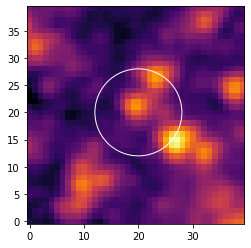

Number of PSF stars: 4


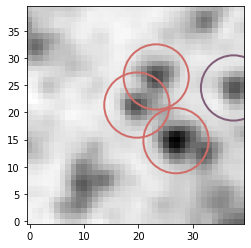

Time taken to fit PSF model: 0.053552400000171474s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
26.922308 14.790916 12132.166   1 ... 1103.7494 155.51203 225.13944 -82.241665
19.718611 21.338995 5138.9456   2 ... 1096.5457 162.06011  225.1417 -82.240071
23.275154 26.514727 5465.1106   4 ... 1100.1023 167.23584 225.13436 -82.239737
37.501451 24.489897 2600.5105   3 ... 1114.3286 165.21101 225.12181  -82.24143
32.212288 12.619844 3003.5558   1 ... 1109.0394 153.34096 225.13583 -82.242483



Current star: RRL3
Star's pixel coordinates: (1287.839565577102, 272.98917203963856)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


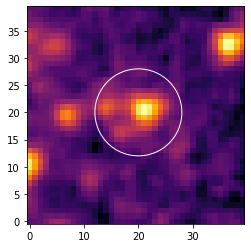

Number of PSF stars: 4


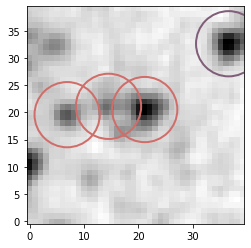

Time taken to fit PSF model: 0.04341089999979886s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
6.8922468 19.574521 1261.8952   1 ... 1274.7318 272.56369 224.88381 -82.243087
14.510021 21.105274 2144.2863   2 ... 1282.3496 274.09445 224.87513  -82.24364
21.163313 20.516156 3750.6851   3 ... 1289.0029 273.50533 224.86897  -82.24438
 36.60393 32.623552 2788.2691   4 ... 1304.4435 285.61272 224.84474 -82.244294



Current star: RRL4
Star's pixel coordinates: (1096.9993327431503, 383.3602720648116)

i am in de mask


Current star: RRL5
Star's pixel coordinates: (1159.2801377457345, 301.736785526425)

i am in de mask


Current star: RRL6
Star's pixel coordinates: (1034.8229698984876, 380.3999358073451)

i am in de mask


Current star: RRL7
Star's pixel coordinates: (839.3865747431365, 593.6494216373584)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


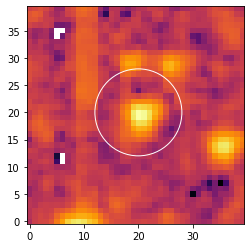

Number of PSF stars: 4


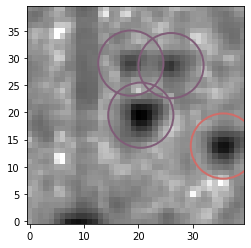

Time taken to fit PSF model: 0.042958399999861285s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
35.631943 13.804236 2504.3163   1 ... 855.01852 587.45366 225.06579 -82.159193
20.445621 19.477463 4211.6722   2 ...  839.8322 593.12688 225.07649  -82.15692
18.613398 29.060806 977.75291   3 ... 837.99997 602.71023 225.07127 -82.155458
25.999157 28.598999 1257.4294   4 ... 845.38573 602.24842 225.06438 -82.156257



Current star: RRL8
Star's pixel coordinates: (850.7543942439438, 384.8368423690265)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


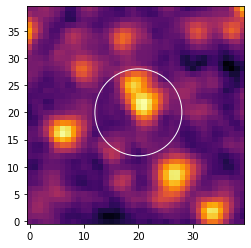

Number of PSF stars: 4


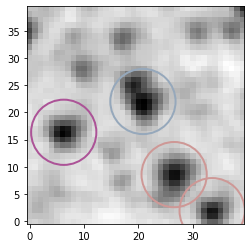

Time taken to fit PSF model: 0.0453973000003316s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
33.566316 1.9149736 2286.0965   1 ... 864.32071 366.75182 225.21883 -82.189546
26.575886 8.5507635 4189.2246   2 ... 857.33028 373.38761 225.22079 -82.187962
6.2677296 16.334891 3018.7587   3 ... 837.02212 381.17173 225.23494 -82.184889
20.838398 21.999779 5489.1351   4 ... 851.59279 386.83662  225.2165 -82.185595



Current star: RRL9
Star's pixel coordinates: (865.4387962094347, 411.51953846712695)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


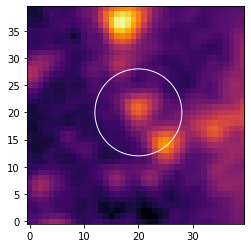

Number of PSF stars: 4


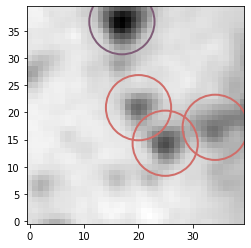

Time taken to fit PSF model: 0.0507274999999936s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
24.933919 14.319815 10032.526   1 ... 870.37272 405.83935  225.1841 -82.184945
 34.13204 17.246609 9420.0801   2 ... 879.57084 408.76615 225.17293 -82.185476
20.025043 20.863379 5786.2276   3 ... 865.46384 412.38292 225.18409 -82.183582
16.969012 36.678548 35802.834   4 ... 862.40781 428.19809 225.17544 -82.181169



Current star: RRL10
Star's pixel coordinates: (985.782890936289, 417.1881225694319)

i am in de mask


Current star: RRL11
Star's pixel coordinates: (959.5772949726174, 204.53594184672528)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


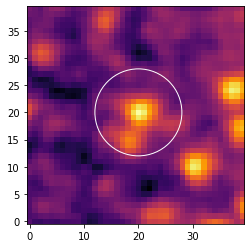

Number of PSF stars: 3


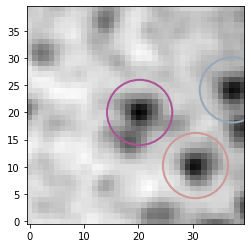

Time taken to fit PSF model: 0.050770599999850674s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
30.507856 10.214566 3507.1097   1 ... 970.08515 194.75051 225.24212 -82.223051
20.232024 19.986005 5215.8216   2 ... 959.80932 204.52195 225.24499  -82.22072
37.293509 24.135148 3896.9264   3 ...  976.8708 208.67109 225.22513 -82.221878
18.238787 14.841084 1586.3537   1 ... 957.81608 199.37703 225.25076 -82.221205



Current star: RRL12
Star's pixel coordinates: (850.9473703506004, 313.833269252239)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


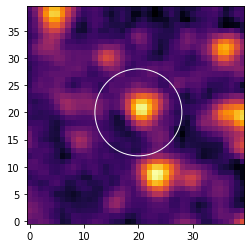

Number of PSF stars: 5


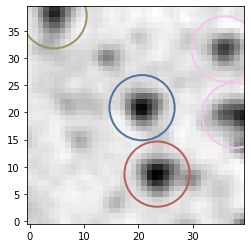

Time taken to fit PSF model: 0.14381460000004154s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
23.426858 8.6390154 4590.5389   1 ... 854.37423 302.47228 225.27604 -82.197106
37.744216  19.46682 2744.5193   2 ... 868.69159 313.30009   225.254 -82.197101
35.812784 31.660418 1914.3287   4 ... 866.76015 325.49369 225.24689 -82.195284
20.676441 20.855722 3656.9385   3 ... 851.62381 314.68899  225.2697 -82.195204
 4.489367   37.7615 2392.1488   5 ... 835.43674 331.59477 225.27308  -82.19133



Current star: RRL13
Star's pixel coordinates: (1018.8298403462832, 266.8037667525656)

i am in de mask


Current star: RRL14
Star's pixel coordinates: (1047.9373408245042, 284.462447124094)

i am in de mask


Current star: RRL15
Star's pixel coordinates: (1081.2142786821582, 327.0601662636948)

i am in de mask


Current star: RRL16
Star's pixel coordinates: (1105.353606894394, 466.6910071780

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


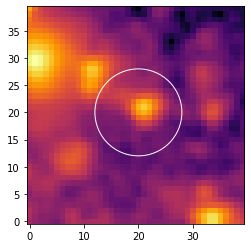

Number of PSF stars: 1


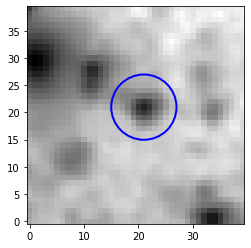

Time taken to fit PSF model: 0.029176100000313454s
   x_0       y_0      flux_0   id ...   x_true    y_true     RA       dec   
--------- --------- --------- --- ... --------- --------- -------- ---------
21.008574 20.958881 4400.2487   1 ... 1106.3622 467.64989 224.9068 -82.20025



Current star: RRL17
Star's pixel coordinates: (1076.6616262874572, 380.2443182128426)

i am in de mask


Current star: RRL18
Star's pixel coordinates: (1170.4369167353639, 359.10413779203907)

i am in de mask


Current star: RRL19
Star's pixel coordinates: (1305.551024157022, 451.0317527980678)


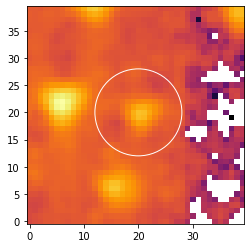

Number of PSF stars: 5


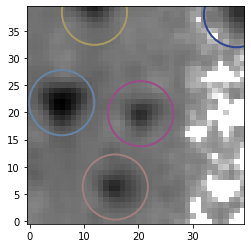

Time taken to fit PSF model: 0.048216300000149204s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
15.747795 6.2620658 5055.7943   1 ... 1301.2988 437.29382 224.73648  -82.22367
20.425263 19.748088 3342.7119   2 ... 1305.9763 450.77984 224.72197 -82.222326
5.9002373 21.778581 19162.529   3 ... 1291.4513 452.81033 224.73487 -82.220615
 11.91555 38.418809 2319.6058   4 ... 1297.4666 469.45056 224.71673  -82.21898
38.046024 37.978252 1533.0093   5 ...  1323.597 469.01001 224.69118 -82.221627



Current star: RRL20
Star's pixel coordinates: (947.7320230510081, 572.4652483835581)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


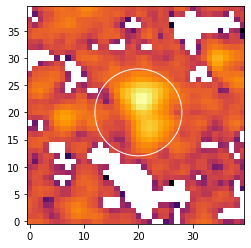

Number of PSF stars: 3


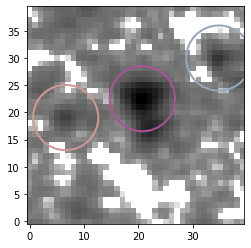

Time taken to fit PSF model: 0.047959200000150304s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
6.6200027 19.039333 488.30867   1 ... 934.35203 571.50458 224.99978 -82.169239
 20.73703 22.523493 5292.4929   2 ... 948.46905 574.98874 224.98339 -82.170181
34.795074 29.982914 489.20523   3 ...  962.5271 582.44816 224.96415 -82.170585
22.061947 16.999481 1313.3337   1 ... 949.79397 569.46473 224.98613 -82.171051



Current star: RRL21
Star's pixel coordinates: (810.245043542436, 454.47030999743504)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


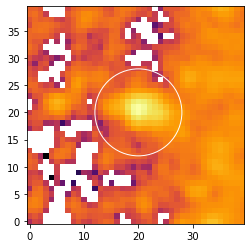

Number of PSF stars: 1


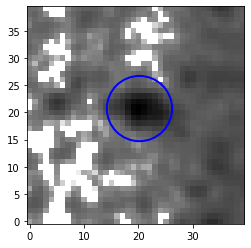

Time taken to fit PSF model: 0.030901799999810464s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
20.194988 20.699458 4018.7356   1 ... 810.44003 455.16977 225.20646 -82.172371



Current star: RRL22
Star's pixel coordinates: (628.9707338585968, 171.0306483475959)


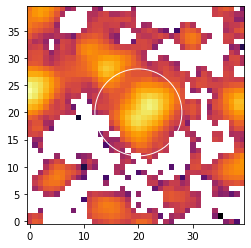

Number of PSF stars: 4


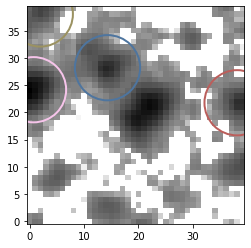

Time taken to fit PSF model: 0.0444881999997051s
   x_0        y_0      flux_0   id ...   x_true    y_true      RA       dec    
---------- --------- --------- --- ... --------- --------- --------- ----------
 38.156151 21.766383 1274.0625   1 ... 647.12688 172.79703 225.57489 -82.193462
0.71010094 24.163912 6613.4887   2 ... 609.68083 175.19456 225.60963 -82.189359
  14.32242 28.211784 2705.8334   3 ... 623.29315 179.24243 225.59335 -82.190199
  1.955144  38.09983 624.70512   4 ... 610.92588 189.13048 225.59805 -82.187639



Current star: RRL23
Star's pixel coordinates: (970.0301515132891, 194.2564275381543)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


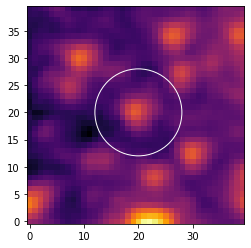

Number of PSF stars: 5


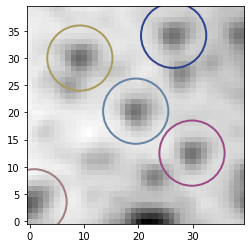

Time taken to fit PSF model: 0.05197050000015224s
   x_0        y_0      flux_0   id ...   x_true    y_true      RA       dec    
---------- --------- --------- --- ... --------- --------- --------- ----------
0.80874969 3.5437315 3647.7754   1 ...  950.8389 177.80016 225.27362 -82.223377
 29.861339 12.501353 3566.2421   2 ... 979.89149 186.75778 225.23839 -82.225098
 19.507856 20.214566 3199.8794   3 ... 969.53801 194.47099 225.24287 -82.223033
 9.2320245 29.986005 4908.5913   4 ... 959.26218 204.24243 225.24574 -82.220702
 26.485208  34.15093 4541.9917   5 ... 976.51536 208.40736 225.22568 -82.221877



Current star: RRL24
Star's pixel coordinates: (1142.478633803904, 321.43208133774783)

i am in de mask


Current star: RRL25
Star's pixel coordinates: (1232.2744261293292, 433.69849082622153)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


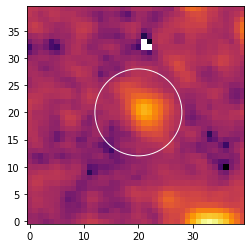

Number of PSF stars: 2


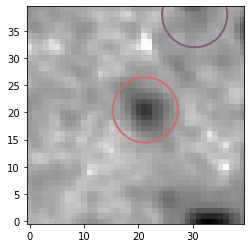

Time taken to fit PSF model: 0.03588499999978012s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
 21.27525 20.417288 5116.0215   1 ... 1233.5497 434.11578 224.80585 -82.217376
30.352919 37.966759 697.94334   2 ... 1242.6273 451.66525 224.78401 -82.215927



Current star: RRL27
Star's pixel coordinates: (933.4837445886137, 467.5598429221376)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


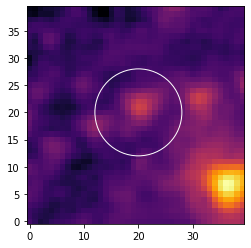

Number of PSF stars: 3


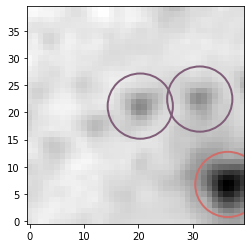

Time taken to fit PSF model: 0.03979620000018258s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
36.455547 6.7412479 155553.07   1 ... 949.93929 454.30109 225.07043  -82.18644
20.346255 21.147279 3830.9645   2 ...    933.83 468.70712 225.07565 -82.182909
31.289804 22.444946 4395.2184   3 ... 944.77355 470.00479 225.06396 -82.183829



Current star: RRL28
Star's pixel coordinates: (1121.1025368577102, 280.92734453682664)

i am in de mask


Current star: RRL29
Star's pixel coordinates: (1017.5365672519392, 274.16782235625277)

i am in de mask


Current star: RRL30
Star's pixel coordinates: (978.0858725945088, 208.24877950100569)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


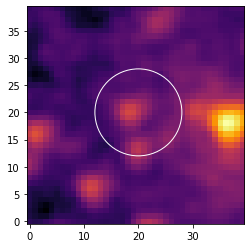

Number of PSF stars: 4


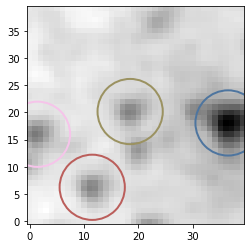

Time taken to fit PSF model: 0.1366865999998481s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
11.507856 6.2145657 3052.6883   1 ... 969.59373 194.46335 225.24282  -82.22304
1.4367495 15.970717 3949.7584   2 ... 959.52262  204.2195  225.2455 -82.220731
36.490698 18.053713 78967.875   3 ... 994.57657 206.30249 225.20946 -82.223967
18.485208  20.15093 4419.8209   4 ... 976.57108 208.39971 225.22563 -82.221884
30.301557 20.237866 5828.5278   1 ... 988.38743 208.48665 225.21394 -82.223056



Current star: RRL31
Star's pixel coordinates: (927.0708138852717, 430.4790370179006)

i am in de mask


Current star: RRL32
Star's pixel coordinates: (967.2040445529854, 243.6524570229848)

i am in de mask


Current star: RRL34
Star's pixel coordinates: (1058.1860159765563, 80.17316091777911)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


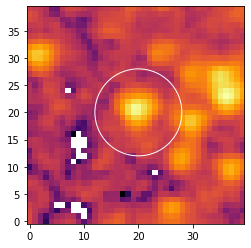

Number of PSF stars: 5


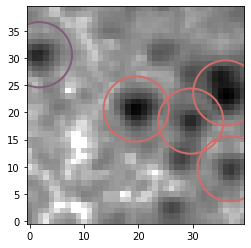

Time taken to fit PSF model: 0.05465020000019649s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
36.871691 9.6168466 859.57779   1 ... 1075.0577 69.790008  225.2314 -82.250213
29.629203 18.393693  1995.114   2 ... 1067.8152 78.566854 225.23202 -82.248318
 19.60126 20.625316 3270.1329   3 ... 1057.7873 80.798477 225.24026 -82.247016
36.074546   23.5718 5346.8102   4 ... 1074.2606 83.744961 225.22181 -82.248275
1.7853324 30.605168 1196.1495   5 ... 1039.9713 90.778329 225.25042 -82.243901



Current star: RRL35
Star's pixel coordinates: (836.2719033331233, 193.30633223509676)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


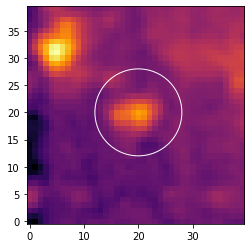

Number of PSF stars: 2


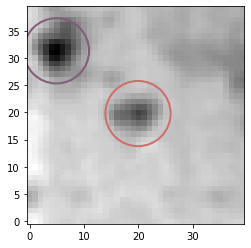

Time taken to fit PSF model: 0.04685960000006162s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
19.930467 19.782949 5650.5689   1 ... 836.20237 193.08928 225.37485 -82.209827
4.9231977 31.320408  18655.25   2 ...  821.1951 204.62674 225.38101 -82.206785
16.526759 19.285802 872.05164   1 ... 832.79866 192.59213 225.37856 -82.209551
6.6842824  35.74109 2295.3323   2 ... 822.95619 209.04742   225.376 -82.206374



Current star: RRL36
Star's pixel coordinates: (1096.3775847261813, 237.4529600650769)

i am in de mask


Current star: RRL37
Star's pixel coordinates: (1131.844081810952, 486.3882913578921)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


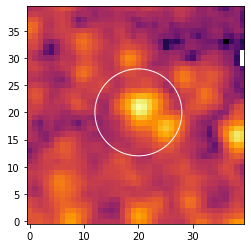

Number of PSF stars: 4


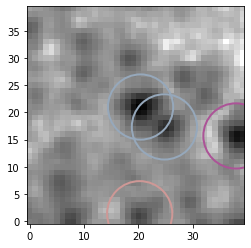

Time taken to fit PSF model: 0.057847099999889906s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
20.237632 1.3512244 814.39482   1 ... 1132.0817 467.73952 224.88139 -82.202796
37.950974 15.659551 1678.0263   2 ... 1149.7951 482.04784 224.85344 -82.202643
24.788872 17.326827 3632.4611   3 ...  1136.633 483.71512  224.8652 -82.201111
20.400895 20.982999 4599.3128   4 ...  1132.245 487.37129 224.86684 -82.200186
7.5164574 1.0808561 1042.7291   1 ... 1119.3605 467.46915 224.89413 -82.201567



Current star: RRL39
Star's pixel coordinates: (844.378376423736, 545.1218406843299)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Ja

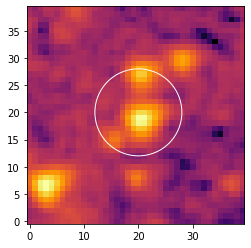

Number of PSF stars: 4


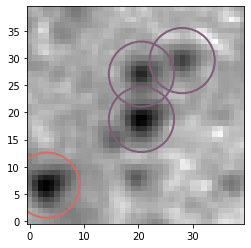

Time taken to fit PSF model: 0.04252319999977772s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
3.1445338 6.6114072 4348.5633   1 ... 827.52291 531.73325 225.13351 -82.163878
20.569827 18.699983 4494.6101   2 ...  844.9482 543.82182  225.1076 -82.164008
20.567958 27.026833 2220.4523   3 ... 844.94633 552.14867  225.1015 -82.162897
28.052038 29.527013 1257.1675   4 ... 852.43041 554.64885 225.09235 -82.163312



Current star: RRL40
Star's pixel coordinates: (927.4904448556226, 192.4556294968684)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


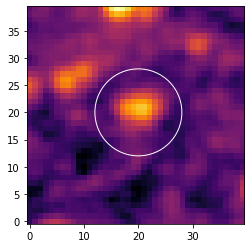

Number of PSF stars: 2


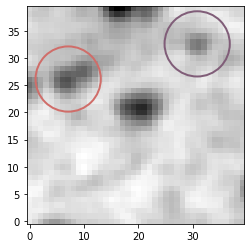

Time taken to fit PSF model: 0.03450159999965763s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
7.0858707 26.131119 3256.0141   1 ... 914.57632 198.58675 225.29385 -82.216971
30.815571 32.598822 1191.9684   2 ... 938.30602 205.05445 225.26574 -82.218492



Current star: RRL42
Star's pixel coordinates: (1096.0468266365112, 473.6843099098056)


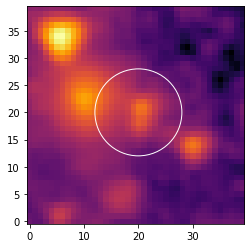

Number of PSF stars: 3


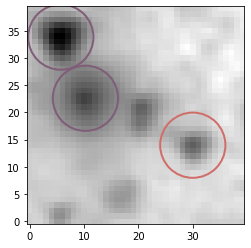

Time taken to fit PSF model: 0.03809810000029756s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
30.008574 13.958881 4477.8266   1 ... 1106.0554 467.64319 224.90711  -82.20022
10.256944 22.591129 21473.582   2 ... 1086.3038 476.27544 224.92024 -82.197101
5.7289775 33.846404 38498.074   3 ... 1081.7758 487.53071 224.91645 -82.195145



Current star: RRL45
Star's pixel coordinates: (1099.4116831399892, 165.99415887409953)


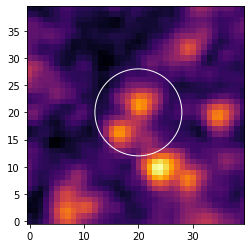

Number of PSF stars: 6


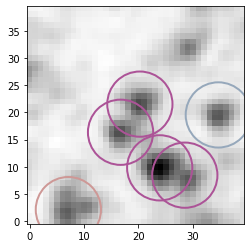

Time taken to fit PSF model: 0.05799639999986539s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
7.1187753 2.1078043 4470.6548   1 ... 1086.5305 148.10196 225.16193  -82.24093
28.541356 8.4437108 10930.189   2 ...  1107.953 154.43787 225.13609 -82.242228
23.922308 9.7909162 12053.846   3 ...  1103.334 155.78508 225.13965 -82.241587
16.718611 16.338995 5060.6262   4 ... 1096.1303 162.33315 225.14191 -82.239993
20.275154 21.514727 5386.7913   6 ... 1099.6868 167.50889 225.13456 -82.239659
 34.70162  19.52789 2907.1846   5 ... 1114.1133 165.52205 225.12179 -82.241367



Current star: RRL46
Star's pixel coordinates: (978.5793654570355, 267.00892458397254)

i am in de mask


Current star: RRL47
Star's pixel coordinates: (1120.174721957355, 212.38116606047217)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


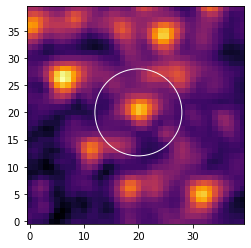

Number of PSF stars: 5


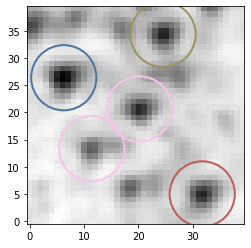

Time taken to fit PSF model: 0.05715800000007221s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
  31.7449 4.9919886 3702.6092   1 ... 1131.9196 197.37315 225.08062 -82.238898
11.420735 13.337359 1919.8585   2 ... 1111.5955 205.71853 225.09452 -82.235754
20.176259 20.623443  3803.281   3 ...  1120.351 213.00461 225.08049 -82.235657
 6.275007 26.373081 5365.7836   4 ... 1106.4497 218.75425 225.08996 -82.233501
24.534708 34.334368 4572.7332   5 ... 1124.7094 226.71553 225.06605 -82.234263
1.0687376 36.135788 2416.0038   1 ... 1101.2435 228.51695 225.08789 -82.231678



Current star: RRL48
Star's pixel coordinates: (967.7904691370677, 170.867601899942)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


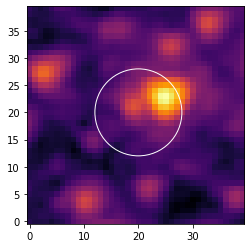

Number of PSF stars: 4


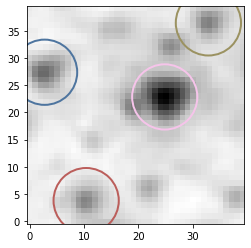

Time taken to fit PSF model: 0.14124050000009447s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
10.390905 3.7647584 3645.0546   1 ... 958.18137 154.63236 225.28358 -82.227196
24.847189 22.838089 63044.686   2 ... 972.63766 173.70569 225.25521 -82.226108
2.7447827 27.380934  6367.469   3 ... 950.53525 178.24854 225.27358 -82.223287
32.880666 36.461187 3736.2716   4 ... 980.67113 187.32879  225.2372   -82.2251
19.172698 21.483139 6404.7527   1 ... 966.96317 172.35074  225.2618  -82.22572



Current star: RRL49
Star's pixel coordinates: (961.2898993636647, 281.95207325865374)

i am in de mask


Current star: RRL50
Star's pixel coordinates: (814.8709794971488, 515.2783391699751)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


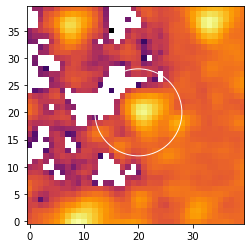

Number of PSF stars: 3


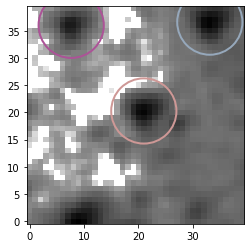

Time taken to fit PSF model: 0.04203499999994165s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
21.000088 20.255191 3548.8388   1 ... 815.87107 515.53353 225.15679 -82.164872
7.6387919 36.010103 1643.5446   2 ... 802.50977 531.28844 225.15829 -82.161435
33.140975 36.601577 4337.0011   3 ... 828.01195 531.87992 225.13293 -82.163907



Current star: RRL51
Star's pixel coordinates: (998.7956387521926, 65.03225919814668)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


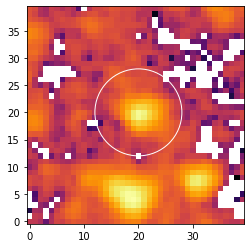

Number of PSF stars: 2


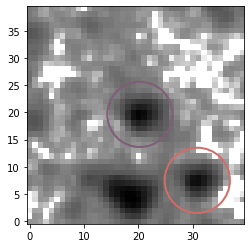

Time taken to fit PSF model: 0.03257830000029571s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
30.836675 7.4976823 2921.1012   1 ... 1009.6323 52.529941 225.30879 -82.245946
20.279985 19.623296 4118.7017   2 ... 999.07562 64.655556 225.31017 -82.243273



Current star: RRL53
Star's pixel coordinates: (1159.4130883813132, 329.2782204230547)

i am in de mask


Current star: RRL54
Star's pixel coordinates: (1100.4540676423746, 372.214008856896)

i am in de mask


Current star: RRL55
Star's pixel coordinates: (1020.7858614010463, 414.6445004667099)

i am in de mask


Current star: RRL56
Star's pixel coordinates: (1209.501860866847, 290.73759796696606)


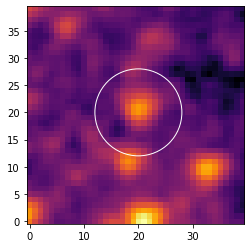

Number of PSF stars: 5


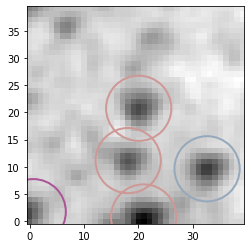

Time taken to fit PSF model: 0.05037210000000414s
   x_0        y_0       flux_0   id ...   x_true    y_true      RA       dec    
---------- ---------- --------- --- ... --------- --------- --------- ----------
 20.962764 0.75480493 8552.0217   1 ... 1210.4646  271.4924 224.94823 -82.236835
 18.122608  11.129894 3057.4113   4 ... 1207.6245 281.86749 224.94339 -82.235165
  20.05867   20.74978 3824.5186   5 ... 1209.5605 291.48738 224.93439 -82.234072
0.65193261  1.7274811 1723.4804   2 ... 1190.1538 272.46508  224.9676 -82.234682
 32.633774  9.6153316 4487.6086   3 ... 1222.1356 280.35293 224.93015 -82.236813



Current star: RRL57
Star's pixel coordinates: (1005.5389816944218, 206.58544140493464)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


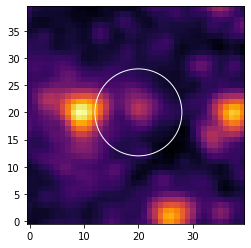

Number of PSF stars: 3


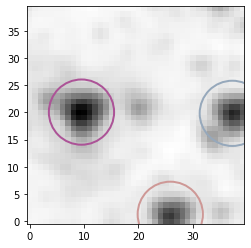

Time taken to fit PSF model: 0.038160900000093534s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
 25.86484  1.247808 22891.474   1 ... 1011.4038 187.83325 225.20657 -82.228113
9.5304816 20.047309  82740.15   2 ... 995.06946 206.63275 225.20873 -82.223973
37.278217 19.819373 33315.744   3 ... 1022.8172 206.40481 225.18157 -82.226782



Current star: RRL58
Star's pixel coordinates: (1011.4533348873564, 409.33264609650575)

i am in de mask


Current star: RRL60
Star's pixel coordinates: (1266.6229549745742, 327.195027730604)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


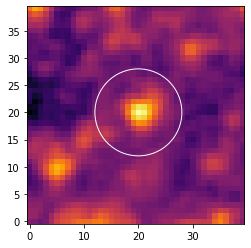

Number of PSF stars: 3


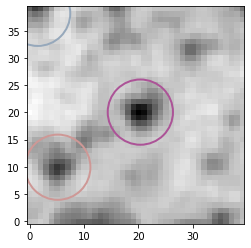

Time taken to fit PSF model: 0.04951230000006035s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
5.1787494 9.9076571 1767.8708   1 ... 1251.8017 317.10268 224.87373 -82.234849
20.358298 20.045591 3239.3842   2 ... 1266.9813 327.24062 224.85124 -82.235002
1.4684006 38.219326 415.71385   3 ... 1248.0914 345.41435 224.85658 -82.230693
35.062266  0.744323 614.51372   1 ... 1281.6852 307.93935 224.85087 -82.239046



Current star: RRL61
Star's pixel coordinates: (881.7581186544807, 323.4821728699725)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Ja

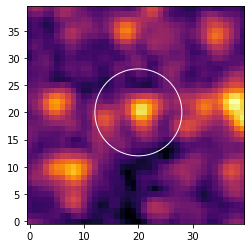

Number of PSF stars: 4


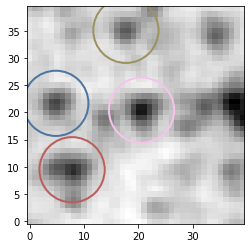

Time taken to fit PSF model: 0.053625300000021525s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
7.8021936  9.443876  4088.627   1 ... 869.56031 312.92605 225.25342 -82.197238
20.577388 20.405886 4226.8141   2 ... 882.33551 323.88806  225.2328 -82.197059
 4.812784 21.660418 2082.3316   3 ...  866.5709 325.14259 225.24733 -82.195312
17.700279 35.090534 1753.3436   4 ...  879.4584 338.57271 225.22478 -82.194816



Current star: RRL62
Star's pixel coordinates: (1114.0552132478167, 163.85254850318287)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


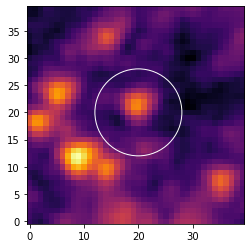

Number of PSF stars: 6


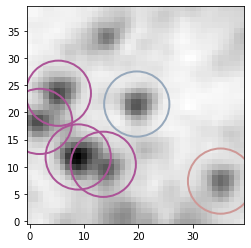

Time taken to fit PSF model: 0.05608120000033523s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
35.111098  7.352748  2701.692   1 ... 1129.1663  151.2053 225.11752 -82.244781
13.541356 10.443711  10878.07   2 ... 1107.5966 154.29626 225.13654 -82.242212
8.9223081 11.790916 12001.728   3 ... 1102.9775 155.64346 225.14011  -82.24157
1.8271435 18.335147 4939.5493   4 ... 1095.8824  162.1877 225.14226 -82.239988
5.2751541 23.514727 5335.4752   6 ... 1099.3304 167.36728 225.13502 -82.239642
 19.70162  21.52789 2840.4003   5 ... 1113.7568 165.38044 225.12225  -82.24135



Current star: RRL63
Star's pixel coordinates: (808.3917394125344, 319.09906035312395)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


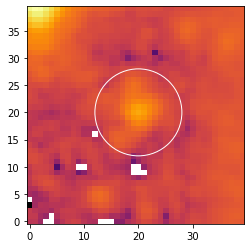

Number of PSF stars: 2


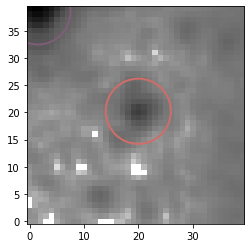

Time taken to fit PSF model: 0.03298670000003767s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
19.986542 20.207873 4709.7994   1 ... 808.37828 319.30693 225.30865 -82.190249
1.5076827 38.484289 44356.159   2 ... 789.89942 337.58335 225.31323 -82.185962



Current star: RRL64
Star's pixel coordinates: (1206.1294090366227, 460.3731835085924)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


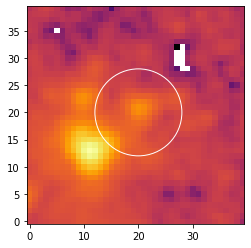

Number of PSF stars: 3


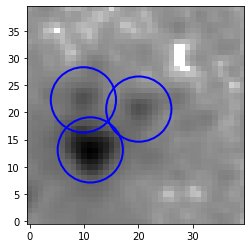

Time taken to fit PSF model: 0.1264752000001863s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
11.152633 13.091661 88886.664   1 ...  1197.282 453.46484 224.82751 -82.211185
20.078313 20.600118 4723.3738   2 ... 1206.2077  460.9733 224.81319 -82.211066
9.8870534 22.304103 8287.6347   3 ... 1196.0165 462.67729 224.82201 -82.209826



Current star: RRL65
Star's pixel coordinates: (990.1634910959021, 245.90187060457527)

i am in de mask


Current star: RRL66
Star's pixel coordinates: (1131.476668557941, 322.9965634883762)

i am in de mask


Current star: RRL67
Star's pixel coordinates: (1140.9434663875763, 242.69823416867027)

i am in de mask


Current star: RRL69
Star's pixel coordinates: (973.3880962524428, 401.455951078429)

i am in de mask


Current star: RRL70
Star's pixel coordinates: (331.2058651478678, 432.64698939362574)


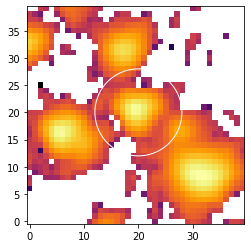

Number of PSF stars: 3


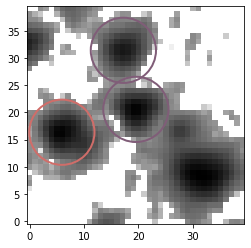

Time taken to fit PSF model: 0.036712099999931525s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
5.9264069 16.343789 4703.9697   1 ... 317.13227 428.99078 225.70526 -82.126141
19.542028 20.542389  4095.252   2 ... 330.74789 433.18938   225.689 -82.126965
17.239701 31.414487 2319.0328   3 ... 328.44557 444.06148 225.68319 -82.125293



Current star: RRL71
Star's pixel coordinates: (907.7691065061277, 329.4972399754864)


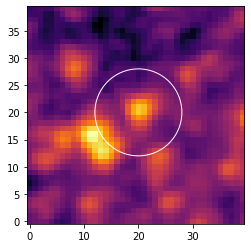

Number of PSF stars: 2


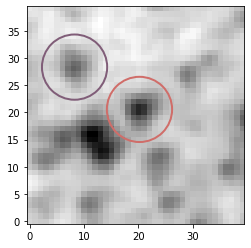

Time taken to fit PSF model: 0.03840020000006916s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
20.201136 20.542098 3337.9749   1 ... 907.97024 330.03934 225.20311 -82.198809
8.2612437 28.323206 1081.8721   2 ... 896.03035 337.82045 225.20908 -82.196576



Current star: RRL72
Star's pixel coordinates: (1229.9383682196446, 647.9437459854879)


C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


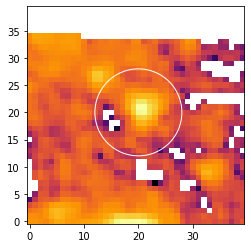

C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


Number of PSF stars: 2


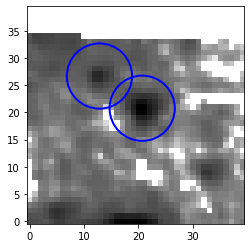

Time taken to fit PSF model: 0.03255659999967975s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
20.700952 20.755591 3402.4532   1 ... 1230.6393 648.69934 224.65201 -82.188329
12.837732 26.681704 1762.1339   2 ... 1222.7761 654.62545 224.65546 -82.186756



Current star: RRL74
Star's pixel coordinates: (1010.1201343371821, 272.77010224618107)

i am in de mask


Current star: RRL75
Star's pixel coordinates: (1027.536045993948, 321.2398764002129)

i am in de mask


Current star: RRL76
Star's pixel coordinates: (1007.7251542650567, 352.2119801161797)

i am in de mask


Current star: RRL77
Star's pixel coordinates: (1060.5612039925277, 411.9009907172092)

i am in de mask


Current star: RRL79
Star's pixel coordinates: (945.7078558652772, 406.12413021998606)

i am in de mask


Current star: RRL80
Star's pixel coordinates: (899.2036302122431, 324.5138948979479)


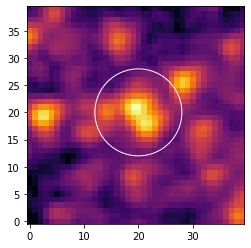

Number of PSF stars: 3


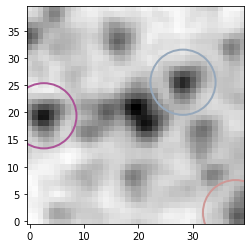

Time taken to fit PSF model: 0.03727570000000924s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
37.881268 1.5490966 1130.2091   1 ...  917.0849 306.06299 225.21187 -82.202916
 2.615378 19.372136 3717.6273   2 ... 881.81901 323.88603 225.23331 -82.197008
28.201136 25.542098 3360.3402   3 ... 907.40477 330.05599 225.20365  -82.19875



Current star: RRL81
Star's pixel coordinates: (1161.7844804850963, 391.30763130965414)

i am in de mask


Current star: RRL82
Star's pixel coordinates: (1078.9981934130722, 299.38911700165784)

i am in de mask


Current star: RRL83
Star's pixel coordinates: (766.7839626036457, 410.260818017899)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


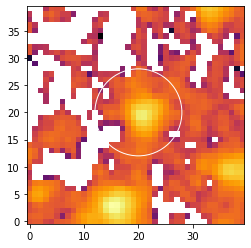

Number of PSF stars: 4


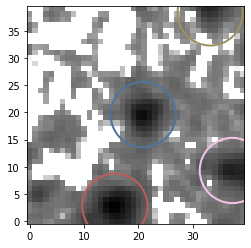

Time taken to fit PSF model: 0.05205260000002454s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
15.672462 2.7417287 5679.3266   1 ... 762.45642 393.00255 225.29916 -82.175834
37.284292 9.3073344 1916.5076   2 ... 784.06825 399.56815 225.27319  -82.17713
20.879552  19.59245 3211.9015   3 ... 767.66351 409.85327 225.28165 -82.174115
33.205679 38.294262 676.85538   4 ... 779.98964 428.55508 225.25582 -82.172862



Current star: RRL84
Star's pixel coordinates: (1044.9300813419165, 255.13104660091972)

i am in de mask


Current star: RRL85
Star's pixel coordinates: (1082.0886797646665, 419.2277007090946)

i am in de mask


Current star: RRL86
Star's pixel coordinates: (1050.7029997950947, 380.61746653300156)

i am in de mask


Current star: RRL87
Star's pixel coordinates: (1210.9625062188666, 249.84022153716072)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


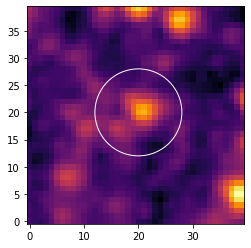

Number of PSF stars: 3


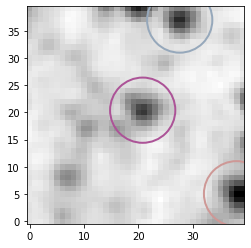

Time taken to fit PSF model: 0.04126200000018798s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
38.054797 5.0278386 4689.1165   1 ... 1229.0173 234.86806 224.95689 -82.243577
20.790717 20.398516  3524.355   2 ... 1211.7532 250.23874 224.96263 -82.239803
27.602912 36.980251 3187.2407   3 ... 1218.5654 266.82047 224.94366 -82.238266



Current star: RRL89
Star's pixel coordinates: (968.6302781768653, 373.10912030394195)

i am in de mask


Current star: RRL90
Star's pixel coordinates: (899.9518511220476, 489.29751533122777)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


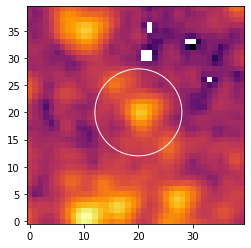

Number of PSF stars: 4


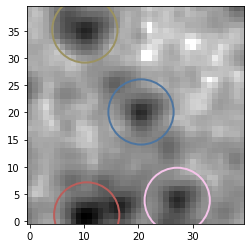

Time taken to fit PSF model: 0.05583059999980833s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
10.492575  1.134183 13587.264   1 ... 890.44443  470.4317 225.11692 -82.178344
27.141711 3.8129281 5214.1905   2 ... 907.09356 473.11044 225.09864 -82.179651
 20.48138  20.07752 4521.2074   3 ... 900.43323 489.37503 225.09322 -82.176816
10.155123 35.145342 6639.0662   4 ... 890.10697 504.44286 225.09228 -82.173774
16.459333 2.7017062 5505.6399   1 ... 896.41118 471.99922 225.10992 -82.178731



Current star: RRL91
Star's pixel coordinates: (891.7248836896065, 228.7314197035178)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Ja

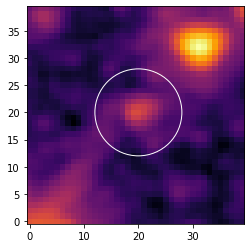

Number of PSF stars: 2


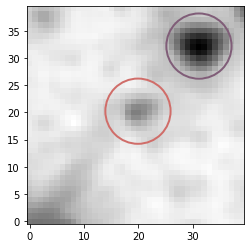

Time taken to fit PSF model: 0.04819009999982882s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
 19.92145 20.217073  5991.861   1 ... 891.64633 228.94849 225.29387  -82.21063
31.141478 32.192225 87084.936   2 ... 902.86636 240.92364 225.27399 -82.210163
38.431253 38.026681 2395.2375   1 ... 910.15614  246.7581 225.26251 -82.210117



Current star: RRL92
Star's pixel coordinates: (1110.9603288196486, 556.8230166740634)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


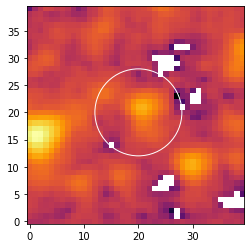

Number of PSF stars: 3


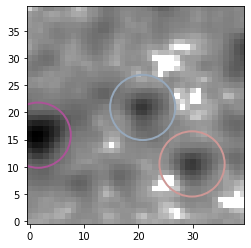

Time taken to fit PSF model: 0.13314860000036788s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
 29.86915 10.513622 2924.2407   1 ... 1120.8295 547.33664 224.83421 -82.191028
1.5656577 15.803263 28469.881   2 ...  1092.526 552.62628 224.85822 -82.187508
20.794334 20.907012 3341.2501   3 ... 1111.7547 557.73003 224.83555 -82.188735



Current star: RRL93
Star's pixel coordinates: (1141.794940754803, 64.43586880784306)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


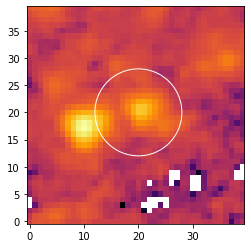

Number of PSF stars: 2


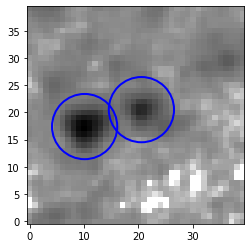

Time taken to fit PSF model: 0.03566750000027241s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
 10.11064 17.386652 12399.081   1 ... 1131.9056 61.822521 225.18114 -82.256969
20.557405 20.500057 3753.8513   2 ... 1142.3523 64.935926 225.16849   -82.2576



Current star: RRL94
Star's pixel coordinates: (1047.7055565747132, 445.9776467088801)

i am in de mask


Current star: RRL96
Star's pixel coordinates: (1008.695327683436, 323.7835516713078)

i am in de mask


Current star: RRL97
Star's pixel coordinates: (1035.0383391210753, 197.2756023377923)


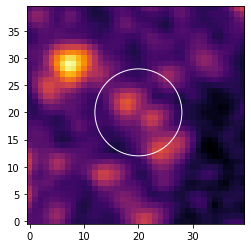

Number of PSF stars: 4


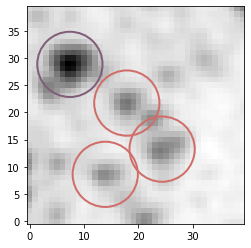

Time taken to fit PSF model: 0.06676650000008522s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
13.901288 8.6003854 2897.7749   1 ... 1028.9396 185.87599 225.19074  -82.23013
24.363559 13.233341  5894.617   2 ... 1039.4019 190.50894   225.177 -82.230561
17.870365 21.711672 5509.6985   3 ... 1032.9087 198.98727 225.17712 -82.228781
7.3986199 28.828863 38482.284   4 ...  1022.437 206.10447 225.18217 -82.226784
3.7719545  24.78548 4091.3057   1 ... 1018.8103 202.06108 225.18874  -82.22696
5.4699085 27.260997 2499.0915   2 ... 1020.5082  204.5366 225.18523   -82.2268



Current star: RRL98
Star's pixel coordinates: (1135.1486288396436, 591.9804394706832)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


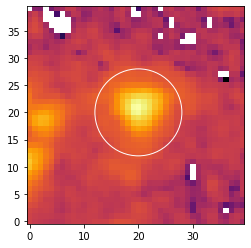

Number of PSF stars: 3


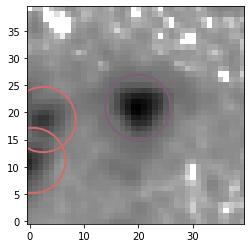

Time taken to fit PSF model: 0.035557499999868014s
   x_0        y_0      flux_0   id ...   x_true    y_true      RA       dec    
---------- --------- --------- --- ... --------- --------- --------- ----------
0.57905861 11.147994  7930.332   1 ... 1115.7277 583.12843 224.81309  -82.18573
 2.4647447 18.677427 9254.3198   2 ... 1117.6134 590.65787 224.80574 -82.184909
 19.925574  20.94993 70286.095   3 ... 1135.0742 592.93037 224.78688 -82.186338





C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


In [23]:
epsf_file = 'epsf_models/'+cluster+'/epsf_'+channel+'_'+str(model_epoch)+'.pickle'
pickle_in = open(epsf_file, 'rb')
epsf = pickle.load(pickle_in)

file_CC = 'data/reference/CVSGC_'+cluster+'_readable.txt'
tbl_CC = Table.read(file_CC, format='ascii.csv')

print(len(tbl_CC))

good_types = ['RR0', 'RR1', 'RR01', 'RR2']
remove_list = []
for i in range(len(tbl_CC)):
    if np.ma.is_masked(tbl_CC['period'][i]) == True:
        remove_list.append(i)
    elif tbl_CC['type'][i] not in good_types:
        remove_list.append(i)

tbl_CC.remove_rows(remove_list)
tbl_CC['id_new'] = np.arange(len(tbl_CC))

print(len(tbl_CC))

tbl_CC.write('data/reference/CVSGC_'+cluster+'_reduced_readable.txt', format='csv', overwrite=True)

master_file = base_dir+cluster+'/'+cluster+'_'+channel+'.fits'
with fits.open(master_file) as hdu_list:
    image_m = hdu_list[0].data
    hdr_m = hdu_list[0].header
    exptime = hdr_m['EXPTIME']
    if cluster == 'PAL13' and channel == '4p5um':
        fluxconv = 0.1469
    else:
        fluxconv = hdr_m['FLUXCONV']
    conv = exptime / fluxconv
    data_m = image_m * conv
    w = wcs.WCS(hdr_m)

#xlim_hi = image_m.shape[1] - 30
#ylim_hi = image_m.shape[0] - 30
#xlim_lo = 30
#ylim_lo = 30
#print(xlim_hi, ylim_hi)

inmask = []
notinmask = []

for star in range(len(tbl_CC)):
    
    if star in starlist:
        
        print('Current star: RRL{}'.format(star+1))
    
        star_ra = tbl_CC['RA'][star]
        star_dec = tbl_CC['dec'][star]
        star_crd = SkyCoord(star_ra, star_dec, frame='icrs', unit='deg')

        pix_crd = w.world_to_pixel(star_crd)
        print("Star's pixel coordinates: ({0}, {1})".format(pix_crd[0], pix_crd[1]))
        
        if channel == '3p6um':
            rectloc = [1050, 340]
        if channel == '4p5um':
            rectloc = [360, 360]
        rectsize = 250
        rect = RectangularAperture(np.transpose(rectloc), rectsize, rectsize)
        
        limx_lo = rectloc[0] - 0.5*rectsize
        limx_hi = rectloc[0] + 0.5*rectsize
        limy_lo = rectloc[1] - 0.5*rectsize
        limy_hi = rectloc[1] + 0.5*rectsize
        
        if pix_crd[0] >= limx_lo and pix_crd[0] <= limx_hi and pix_crd[1] >= limy_lo and pix_crd[1] <= limy_hi:
            print('\ni am in de mask\n\n')
            inmask.append(star)
            continue
        else:
            notinmask.append(star)
        
        #if pix_crd[0] >= xlim_hi or pix_crd[0] <= xlim_lo or pix_crd[1] >= ylim_hi or pix_crd[1] <= ylim_lo:
        #    print('Star not in channel')
        #    not_ch_list.append(star)
            

        star_x = int(pix_crd[0])
        star_y = int(pix_crd[1])
        star_ap = CircularAperture((star_r, star_r), r=8.)
        region_m = data_m[star_y-star_r:star_y+star_r, star_x-star_r:star_x+star_r]
        plt.imshow(region_m, cmap='inferno', origin='lower', norm=LogNorm(), interpolation='nearest', aspect='equal')
        star_ap.plot(color='white')
        plt.show()

        mean, median, std = sigma_clipped_stats(region_m, sigma=sigma_level)
        #print('Mean: {0}\nMedian: {1}\nStd dev: {2}'.format(mean, median, std))

        ###   DETECTING MORE STARS   ###

        sources_m = star_find(region_m, sigma_level, FWHM, std, roundness, sharphi_PSF)
        
        try:
            pos_m = np.transpose((sources_m['xcentroid'], sources_m['ycentroid']))
        except TypeError:
            print('No sources detected')
            continue
            
        ap_m = CircularAperture(pos_m, r_ap)
        print('Number of PSF stars: {}'.format(len(sources_m)))
        #plotting(region_m, ap_m, an=None, cmap='Greys', choice='ap_only', savename=None)

        ###   GROUPING STARS BASED ON PROXIMITY TO NEIGHBOURS   ###

        sources_m['xcentroid'].name = 'x_0'
        sources_m['ycentroid'].name = 'y_0'
        daogroup = DAOGroup(crit_separation=2.5*FWHM)
        #daogroup = DAOGroup(crit_separation=4*FWHM)
        star_groups = daogroup(sources_m)
        star_groups = star_groups.group_by('group_id')

        ncolors = max(star_groups['group_id'])
        cmap = make_random_cmap(ncolors=ncolors, seed=1612)
        plt.imshow(region_m, origin='lower', norm=LogNorm(), interpolation='nearest', cmap='Greys')
        if ncolors > 1:
            for i, group in enumerate(star_groups.groups):
                pos_group = np.transpose([group['x_0'], group['y_0']])
                ap_group = CircularAperture(pos_group, r_ap)
                ap_group.plot(color=cmap.colors[i], lw=2.)
        else:
            for i, group in enumerate(star_groups.groups):
                pos_group = np.transpose([group['x_0'], group['y_0']])
                ap_group = CircularAperture(pos_group, r_ap)
                ap_group.plot(color='blue', lw=2.)
        plt.show()
        
        ###   DOING PSF PHOTOMETRY   ###

        region_m_nonans = np.nan_to_num(region_m, nan=0.00001, copy=True) # changing NaN values to a float so PSF fit doesn't crash

        #bkg_estimation = MMMBackground()
        #fitter = LevMarLSQFitter()
        daofind_m = DAOStarFinder(threshold=sigma_level*std, fwhm=FWHM, roundlo=-roundness, roundhi=roundness, sharphi=sharphi_PSF)
        fit_rad = 5

        epsf.x_0.fixed = True
        epsf.y_0.fixed = True
        init_pos = Table(names=['x_0', 'y_0'], data=[sources_m['x_0'], sources_m['y_0']])
        #init_pos = Table(names=['x_0', 'y_0'], data=transf_list)

        start = time.perf_counter()
        PSF_photometry = ISPSF(finder = daofind_m,
                              group_maker = daogroup,
                              bkg_estimator = MMMBackground(),
                              psf_model = epsf,
                              fitter = LevMarLSQFitter(),
                              fitshape = 2*fit_rad+1,
                              niters = 2,
                              aperture_radius = 6.)
        master_stars = PSF_photometry(image=region_m_nonans, init_guesses=init_pos)
        residual_image = PSF_photometry.get_residual_image()
        print('Time taken to fit PSF model: {}s'.format(time.perf_counter() - start))

        master_stars['id_master'] = np.arange(len(master_stars))
        
        true_x = pix_crd[0]+master_stars['x_0']-star_r  # actual pixel coords of star in image,
        true_y = pix_crd[1]+master_stars['y_0']-star_r  # since pix_crd is measured relative to the box
        master_stars['x_true'] = true_x
        master_stars['y_true'] = true_y
        
        cat_m, ra_m, dec_m = make_catalog(true_x, true_y, hdr_m)
        master_stars['RA'] = ra_m
        master_stars['dec'] = dec_m
        
        print_table_nicely(master_stars)
        master_stars['id_master', 'x_0', 'y_0', 'x_true', 'y_true', 'RA', 'dec'].write('outputs/'+cluster+'/masterlist_RRL'+str(star)+'_'+channel+'_mask.txt', format='csv', overwrite=True)
        
        print('\n\n')
        
        #break
        
#master_stars

In [24]:
print(len(notinmask))
print(len(inmask))
print(notinmask)
print(inmask)

46
39
[1, 2, 6, 7, 8, 10, 11, 15, 18, 19, 20, 21, 22, 24, 26, 29, 33, 34, 36, 38, 39, 41, 44, 46, 47, 49, 50, 55, 56, 59, 60, 61, 62, 63, 69, 70, 71, 79, 82, 86, 89, 90, 91, 92, 96, 97]
[0, 3, 4, 5, 9, 12, 13, 14, 16, 17, 23, 27, 28, 30, 31, 35, 45, 48, 52, 53, 54, 57, 64, 65, 66, 68, 73, 74, 75, 76, 78, 80, 81, 83, 84, 85, 88, 93, 95]


In [25]:
master_file = 'outputs/'+cluster+'/masterlist_RRL0_'+channel+'.txt'
print(master_file)
master_table = Table.read(master_file, format='ascii.csv')
print_table_nicely(master_table)

outputs/IC4499/masterlist_RRL0_3p6um.txt
id_master    x_0        y_0      x_true    y_true      RA       dec    
--------- ---------- --------- --------- --------- --------- ----------
        0   36.42682 14.750808 966.87672 243.94323 225.20886 -82.216178
        1   1.204548 17.297522 931.65445 246.48994  225.2416 -82.212309
        2 0.96902109 22.916424 931.41892 252.10884 225.23767 -82.211537
        3  25.860344 21.987918 956.31024 251.18034 225.21389 -82.214156
        4  37.174182 29.689124 967.62408 258.88154 225.19707 -82.214263


In [26]:
print('Photometry method selected: {}'.format(method))

epsf_file = 'epsf_models/'+cluster+'/epsf_'+channel+'_'+str(model_epoch)+'.pickle'
pickle_in = open(epsf_file, 'rb')
epsf = pickle.load(pickle_in)

file_CC = 'data/reference/CVSGC_'+cluster+'_readable.txt'
tbl_CC = Table.read(file_CC, format='ascii.csv')

good_types = ['RR0', 'RR1', 'RR01', 'RR2']
remove_list = []
for i in range(len(tbl_CC)):
    if np.ma.is_masked(tbl_CC['period'][i]) == True:
        remove_list.append(i)
    elif tbl_CC['type'][i] not in good_types:
        remove_list.append(i)

tbl_CC.remove_rows(remove_list)
tbl_CC['id_new'] = np.arange(len(tbl_CC))

remove_list_2 = []
for i in range(len(tbl_CC)):
    if i in inmask:
        remove_list_2.append(i)

print(remove_list_2)
print(tbl_CC)
tbl_CC.remove_rows(remove_list_2)

tbl_CC

Photometry method selected: PSF
[0, 3, 4, 5, 9, 12, 13, 14, 16, 17, 23, 27, 28, 30, 31, 35, 45, 48, 52, 53, 54, 57, 64, 65, 66, 68, 73, 74, 75, 76, 78, 80, 81, 83, 84, 85, 88, 93, 95]
 ID      RA          dec      units period ... amplitude colour type id_new
--- ------------ ------------ ----- ------ ... --------- ------ ---- ------
  1 15h00m53.07s -82d12m49.8s    R0 0.6099 ...      0.74      V  RR0      0
  2 15h00m34.18s -82d14m25.0s    R0 0.4936 ...      1.21      V  RR0      1
  3 14h59m28.92s -82d14m39.6s    R0 0.4832 ...      1.21      V  RR0      2
  4 14h59m54.70s -82d12m38.1s    R0 0.6236 ...       0.8      V  RR0      3
  5 14h59m54.37s -82d13m39.7s    R0 0.5569 ...      1.11      V  RR0      4
  6 15h00m09.92s -82d12m17.2s    R0 0.5779 ...      0.96      V  RR0      5
  7 15h00m18.37s -82d09m24.5s    R0 0.6179 ...      0.78      V  RR0      6
  8 15h00m52.51s -82d11m08.8s    R0 0.3674 ...        --      V RR01      7
  9 15h00m44.34s -82d11m01.3s    R0 0.7096 ...      0.77

<Table length=59>
  ID       RA          dec      units  period ... amplitude colour type id_new
int32    str12        str12      str2 float64 ...  float64   str4  str5 int32 
----- ------------ ------------ ----- ------- ... --------- ------ ---- ------
    2 15h00m34.18s -82d14m25.0s    R0  0.4936 ...      1.21      V  RR0      1
    3 14h59m28.92s -82d14m39.6s    R0  0.4832 ...      1.21      V  RR0      2
    7 15h00m18.37s -82d09m24.5s    R0  0.6179 ...      0.78      V  RR0      6
    8 15h00m52.51s -82d11m08.8s    R0  0.3674 ...        --      V RR01      7
    9 15h00m44.34s -82d11m01.3s    R0  0.7096 ...      0.77      V  RR0      8
   11 15h00m58.85s -82d13m14.5s    R0  0.6315 ...      0.56      V  RR0     10
   12 15h01m05.04s -82d11m42.9s    R0  0.5948 ...      0.85      V  RR0     11
   16 14h59m38.04s -82d12m01.0s    R0  0.5773 ...      0.91      V  RR0     15
   19 14h58m53.33s -82d13m20.1s    R0  0.5306 ...      1.08      V  RR0     18
   20 14h59m56.63s -82d10m13.6s    R0  0.6482 ...      0.69      V  RR0     19
  ...          ...          ...   ...     ... ...       ...    ...  ...    ...
   92 15h01m07.73s -82d10m26.3s    R0  0.3547 ...      0.42      V  RR1     82
   97 14h59m51.29s -82d14m23.2s    R0  0.2883 ...      0.42      V  RR2     86
   98 15h02m16.88s -82d13m20.7s    R0  0.3556 ...      0.42      V  RR1     87
  106 15h00m22.50s -82d10m36.4s    R0  0.6277 ...      0.59      V  RR0     89
  108 15h01m10.55s -82d12m38.4s    R0  0.6415 ...      0.51      V  RR0     90
  109 14h59m20.88s -82d11m19.6s    R0  0.3555 ...        --      V RR01     91
  111 15h00m40.66s -82d15m27.4s    R0  0.3573 ...      0.42      V  RR1     92
  153 14h59m10.31s -82d15m46.8s    R0  0.2851 ...      0.31      V  RR2     94
  171 15h00m42.31s -82d13m45.2s    R0  0.2797 ...      0.22      V  RR2     96
  173 14h59m09.00s -82d11m11.3s    R0  0.3607 ...        --      V  RR1     97

### Main photometry cell:

In [ ]:
print('Photometry method selected: {}'.format(method))

epsf_file = 'epsf_models/'+cluster+'/epsf_'+channel+'_'+str(model_epoch)+'.pickle'
pickle_in = open(epsf_file, 'rb')
epsf = pickle.load(pickle_in)

file_CC = 'data/reference/CVSGC_'+cluster+'_readable.txt'
tbl_CC = Table.read(file_CC, format='ascii.csv')

good_types = ['RR0', 'RR1', 'RR01', 'RR2']
remove_list = []
for i in range(len(tbl_CC)):
    if np.ma.is_masked(tbl_CC['period'][i]) == True:
        remove_list.append(i)
    elif tbl_CC['type'][i] not in good_types:
        remove_list.append(i)

tbl_CC.remove_rows(remove_list)
tbl_CC['id_new'] = np.arange(len(tbl_CC))

#remove_list_2 = []
#for i in range(len(tbl_CC)):
#    if i in inmask:
#        remove_list_2.append(i)
#        
#tbl_CC.remove_rows(remove_list_2)

big_table = Table()  # initialising the table we'll dump each RRL's data into
# Ideal order for column names (also used to initialise blank rows for missing stars):
new_order = ['star_name', 'id_master', 'RA', 'dec', 'x_0', 'y_0', 'x_true', 'y_true', 'mag_e1', 'err_e1', 'mag_e2', 'err_e2', 'mag_e3', 'err_e3', 'mag_e4', 'err_e4', 'mag_e5', 'err_e5', 'mag_e6', 'err_e6', 'mag_e7', 'err_e7', 'mag_e8', 'err_e8', 'mag_e9', 'err_e9', 'mag_e10', 'err_e10', 'mag_e11', 'err_e11', 'mag_e12', 'err_e12', 'eta_inv', 'IQR', 'chi_sq']

for star in range(len(tbl_CC)):
    
    if star in starlist:

        print('Current star: RRL{}'.format(star+1))

        master_file = 'outputs/'+cluster+'/masterlist_RRL'+str(star)+'_'+channel+'_mask.txt'
        try:
            master_table = Table.read(master_file, format='ascii.csv')
        except FileNotFoundError:
            print('Star not in master list for this channel')
            continue

        LC_time = []

        star_ra = tbl_CC['RA'][star]
        star_dec = tbl_CC['dec'][star]
        star_crd = SkyCoord(star_ra, star_dec, frame='icrs', unit='deg')

        epoch = 1  # counter to be incremented every epoch

        for filename in glob.glob(base_dir+'*/'+cluster+'__e[0-9]_'+channel+'.fits', recursive=True) + glob.glob(base_dir+'*/'+cluster+'__e[0-9][0-9]_'+channel+'.fits', recursive=True):
            
            print('Epoch: ', epoch)
            
            ###   OPENING FITS FILE AND CONVERTING TO COUNTS   ###

            with fits.open(filename) as hdu_list:  
                image_data = hdu_list[0].data
                hdr = hdu_list[0].header
                exptime = hdr['EXPTIME']
                fluxconv = hdr['FLUXCONV']
                conv = exptime / fluxconv
                data = image_data * conv

            LC_time.append(Time(hdr['DATE_OBS'], format='isot', scale='utc').mjd)

            file_corr = base_dir+cluster+'__e'+str(epoch)+'/'+cluster+'__e'+str(epoch)+'_correction_'+channel+'.fits'
            with fits.open(file_corr) as hdu_list:
                data_corr = hdu_list[0].data       

            w = wcs.WCS(hdr)
            pix_crd = w.world_to_pixel(star_crd)

            star_x = int(pix_crd[0])
            star_y = int(pix_crd[1])

            star_ap = CircularAperture((star_r, star_r), r=8.)
            region = data[star_y-star_r:star_y+star_r, star_x-star_r:star_x+star_r]
            plt.imshow(region, cmap='inferno', origin='lower', norm=LogNorm(), interpolation='nearest', aspect='equal')
            star_ap.plot(color='white')
            plt.savefig('images/'+cluster+'/problem_stars/mask/RRL'+str(star+1)+'_'+channel+'_e'+str(epoch)+'.png')
            plt.show()

            mean, median, std = sigma_clipped_stats(region, sigma=sigma_level)
            print('Mean: {0}\nMedian: {1}\nStd dev: {2}'.format(mean, median, std))

            if method == 'aperture':

                ###   LOCATING STARS AND PLOTTING THEM   ###
                # could maybe put most of this in its own starfind function? including aperture and position bits

                sources = star_find(region, sigma_level, FWHM, std, roundness, sharphi)
                print(sources)
                pos = np.transpose((sources['xcentroid'], sources['ycentroid']))
                apertures = CircularAperture(pos, r_ap)
                annuli = CircularAnnulus(pos, r_in, r_out)
                print('No. of stars detected: {0}'.format(len(sources)))
                plotting(region, apertures, annuli, 'Greys', choice='both_aps', savename=None)

                ###   DOING APERTURE PHOTOMETRY   ###

                phot_table = ap_phot(region, apertures, annuli, 'median')

                phot_table['apparent_mag'] = float('NaN')
                phot_table['mag_err'] = float('NaN')
                for i in range(len(phot_table)):
                    locorr = data_corr[int(pix_crd[1])][int(pix_crd[0])]  # location-dependent correction at star's location

                    if phot_table['star_bkgsub'][i] >= 0:
                        phot_table['apparent_mag'][i] = zmag - 2.5 * math.log10(apcorr * locorr * phot_table['star_bkgsub'][i] / conv)
                        phot_table['mag_err'][i] = apparent_magnitude_err(phot_table['star_bkgsub'][i], apcorr, zmag_err, phot_table['counts_err'][i], apcorr_err)

                print_table_nicely(phot_table['id', 'xcenter', 'ycenter', 'star_bkgsub', 'counts_err', 'apparent_mag', 'mag_err'])

                match_table = copy.copy(phot_table)
                del match_table['aperture_sum_0', 'aperture_sum_1', 'bkg_sum_median', 'star_bkgsub', 'counts_err']
                mag_name = 'mag_e'+str(epoch)
                err_name = 'err_e'+str(epoch)
                match_table.rename_column('apparent_mag', mag_name)
                match_table.rename_column('mag_err', err_name)


            if method == 'PSF':

                ###   DETECTING MORE STARS   ###

                if cluster == 'PAL5' and channel == '3p6um' and star == 2 and epoch == 2:  # special conditions for a special star
                    sources_PSF = star_find(region, sigma_level, FWHM, std, roundness, sharphi=0.95)
                else:
                    sources_PSF = star_find(region, sigma_level, FWHM, std, roundness, sharphi_PSF)

                if sources_PSF == None:
                    print('No sources found initially :(')
                    sources_PSF = star_find(region, sigma_level-2, FWHM, std, roundness, sharphi_PSF)

                print('sources_PSF: ', sources_PSF)
                if sources_PSF == None:
                    print('No sources found after reducing detection threshold :(')          

                try:
                    pos_PSF = np.transpose((sources_PSF['xcentroid'], sources_PSF['ycentroid']))
                except TypeError:                    
                    mag_name = 'mag_e'+str(epoch)
                    err_name = 'err_e'+str(epoch)
                    master_table[mag_name] = float('NaN')
                    master_table[err_name] = float('NaN')

                    epoch += 1
                    continue

                ap_PSF = CircularAperture(pos_PSF, r_ap)
                print('Number of PSF stars: {}'.format(len(sources_PSF)))
                #plotting(region, ap_PSF, an=None, cmap='Greys', choice='ap_only', savename=None)

                ###   GROUPING STARS BASED ON PROXIMITY TO NEIGHBOURS   ###

                sources_PSF['xcentroid'].name = 'x_0'
                sources_PSF['ycentroid'].name = 'y_0'
                daogroup = DAOGroup(crit_separation=2.5*FWHM)
                #daogroup = DAOGroup(crit_separation=4*FWHM)
                star_groups = daogroup(sources_PSF)
                star_groups = star_groups.group_by('group_id')

                ncolors = max(star_groups['group_id'])
                cmap = make_random_cmap(ncolors=ncolors, seed=1612)
                plt.imshow(region, origin='lower', norm=LogNorm(), interpolation='nearest', cmap='Greys')
                if ncolors > 1:
                    for i, group in enumerate(star_groups.groups):
                        pos_group = np.transpose([group['x_0'], group['y_0']])
                        ap_group = CircularAperture(pos_group, r_ap)
                        ap_group.plot(color=cmap.colors[i], lw=2.)
                else:
                    for i, group in enumerate(star_groups.groups):
                        pos_group = np.transpose([group['x_0'], group['y_0']])
                        ap_group = CircularAperture(pos_group, r_ap)
                        ap_group.plot(color='blue', lw=2.)
                plt.show()

                ###   DOING PSF PHOTOMETRY   ###

                region_nonans = np.nan_to_num(region, nan=0.00001, copy=True) # changing NaN values to a float so PSF fit doesn't crash

                #bkg_estimation = MMMBackground()
                #fitter = LevMarLSQFitter()
                daofind_PSF = DAOStarFinder(threshold=sigma_level*std, fwhm=FWHM, roundlo=-roundness, roundhi=roundness, sharphi=sharphi_PSF)
                fit_rad = 5

                epsf.x_0.fixed = True
                epsf.y_0.fixed = True
                init_pos = Table(names=['x_0', 'y_0'], data=[sources_PSF['x_0'], sources_PSF['y_0']])
                #init_pos = Table(names=['x_0', 'y_0'], data=transf_list)

                start = time.perf_counter()
                PSF_photometry = ISPSF(finder = daofind_PSF,
                                      group_maker = daogroup,
                                      bkg_estimator = MMMBackground(),
                                      psf_model = epsf,
                                      fitter = LevMarLSQFitter(),
                                      fitshape = 2*fit_rad+1,
                                      niters = 2,
                                      aperture_radius = 6.)
                PSF_table = PSF_photometry(image=region_nonans, init_guesses=init_pos)
                residual_image = PSF_photometry.get_residual_image()
                print('Time taken to fit PSF model: {}s'.format(time.perf_counter() - start))

                for i in range(len(PSF_table)):
                    if PSF_table['iter_detected'][i] > 1:
                        PSF_table['id'][i] += max(PSF_table['id'])

                #plotting(residual_image, ap=None, an=None, cmap='viridis', choice=None, savename=None)

                hdu = fits.PrimaryHDU(residual_image)
                hdul = fits.HDUList([hdu])
                hdul.writeto('outputs/'+cluster+'/residuals/mask/star'+str(star+1)+'_'+channel+'_e'+str(epoch)+'_residual.fits', overwrite=True)

                PSF_table['apparent_mag'] = float('NaN')
                PSF_table['mag_err'] = float('NaN')
                for i in range(len(PSF_table)):
                    locorr = data_corr[int(pix_crd[1])][int(pix_crd[0])]  # location-dependent correction at star's location

                    if PSF_table['flux_fit'][i] >= 0:
                        PSF_table['apparent_mag'][i] = zmag - 2.5 * math.log10(apcorr * locorr * PSF_table['flux_fit'][i] / conv)
                        PSF_table['mag_err'][i] = apparent_magnitude_err(PSF_table['flux_fit'][i], apcorr, zmag_err, PSF_table['flux_unc'][i], apcorr_err)


                print_table_nicely(PSF_table['id', 'group_id', 'iter_detected', 'x_fit', 'y_fit', 'apparent_mag', 'mag_err', 'flux_unc'])

                mag_med = np.median(PSF_table['mag_err'])
                flux_med = np.median(PSF_table['flux_unc'])

                print('Median mag error:  {0}\nMedian flux error: {1}'.format(mag_med, flux_med))

                match_table = copy.copy(PSF_table)
                del match_table['x_0', 'y_0', 'flux_0', 'flux_fit', 'flux_unc', 'iter_detected', 'group_id']
                mag_name = 'mag_e'+str(epoch)
                err_name = 'err_e'+str(epoch)
                match_table.rename_column('apparent_mag', mag_name)
                match_table.rename_column('mag_err', err_name)
                match_table.rename_column('x_fit', 'xcenter')
                match_table.rename_column('y_fit', 'ycenter')

                ###   END OF PSF SECTION   ###

            true_x = pix_crd[0]+match_table['xcenter']-star_r
            true_y = pix_crd[1]+match_table['ycenter']-star_r
            cat_match, ra, dec = make_catalog(true_x, true_y, hdr)
            match_table['RA'] = ra
            match_table['dec'] = dec

            comp_table = copy.copy(master_table)
            cat_m = SkyCoord(comp_table['RA'], comp_table['dec'], frame='icrs', unit='deg')

            idx, d2d, d3d = cat_match.match_to_catalog_sky(cat_m)

            # Selection criteria:
            max_sep = 0.001 * u.degree
            selection = (d2d < max_sep)
            match_table = match_table[selection]
            comp_table = comp_table[idx[selection]]

            match_table['id_master'] = comp_table['id_master']

            match_table = Table(match_table, masked=True)

            mag_name = 'mag_e'+str(epoch)
            err_name = 'err_e'+str(epoch)

            try:
                master_table = join(master_table, match_table['id_master', mag_name, err_name], keys='id_master', join_type='left')
            except ValueError:
                print('RRL{} not detected in this epoch :('.format(star+1))

                master_table[mag_name] = float('NaN')
                master_table[err_name] = float('NaN')

                epoch += 1
                continue

            #master_table = join(master_table, match_table['id_master', mag_name, err_name], keys='id_master', join_type='left')
            print_table_nicely(master_table)

            if run_all == False:
                break

            epoch += 1
            print('\n\n\n')

            ###   END OF EPOCH LOOP   ###

        ###   CALCULATING VARIABILITY INDICES AND AMPLITUDE FOR EACH STAR   ###

        masked_array = np.ma.array(np.zeros(len(master_table)), mask=True)
        master_table['eta_inv'] = masked_array
        master_table['IQR'] = masked_array
        master_table['chi_sq'] = masked_array

        master_table_f = copy.copy(master_table.filled(-99))

        for i in range(len(master_table_f)):

            # Putting magnitudes into an array so we can play with them:
            mags = []
            errs = []
            for j in range(1,13):
                mags.append(master_table_f['mag_e'+str(j)][i])
                errs.append(master_table_f['err_e'+str(j)][i])

            mags = np.ma.array(mags)
            mags = np.ma.masked_where(mags == -99, mags)
            errs = np.ma.array(errs)
            errs = np.ma.masked_where(errs == -99, errs)

            if mags.compressed().size:    # doesn't calculate anything extra if the star has no magnitude data

                # Chi squared test:
                mean_sum1 = sum((m / e**2) for m, e in zip(mags.compressed(), errs.compressed()))
                mean_sum2 = sum((1. / e**2) for e in errs.compressed())
                mean_chi = mean_sum1 / mean_sum2

                chi_sq = sum(((m - mean_chi) / e)**2 for m, e in zip(mags.compressed(), errs.compressed()))
                master_table['chi_sq'][i] = chi_sq

                # IQR:
                mags_sorted = sorted(mags.compressed())
                if len(mags_sorted) > 5:  # finding IQR for fewer than 6 values is pointless really, and can cause issues
                    if len(mags_sorted) % 2 == 1:   # if odd number of entries, remove the median
                        mags_sorted.pop(int(len(mags_sorted)/2))

                    mags_split= np.array_split(mags_sorted, 2)
                    mags_lo = mags_split[0]
                    mags_hi = mags_split[1]

                    n = int(len(mags_lo) / 2)
                    q25 = (mags_lo[n-1] + mags_lo[n]) / 2
                    q75 = (mags_hi[n-1] + mags_hi[n]) / 2
                    iqr = q75 - q25
                    master_table['IQR'][i] = iqr

                # von Neumann index:
                # (VERY important this is run LAST out of all the indices, otherwise 'continue' may skip them)
                var = sum((m - np.mean(mags.compressed()))**2 for m in mags.compressed()) / (len(mags.compressed()) - 1)
                diff = 0
                for k in range(len(mags.compressed()) - 1):
                    diff += (mags.compressed()[k+1] - mags.compressed()[k])**2
                if (len(mags.compressed()) - 1) == 0:
                    continue
                mssd = diff / (len(mags.compressed()) - 1)
                if mssd == 0. or var == 0.:
                    continue
                eta_inv = var / mssd
                master_table['eta_inv'][i] = eta_inv

        ###   KEEPING ONLY THE RRL   ###

        master_crd = SkyCoord(master_table['RA'], master_table['dec'], frame='icrs', unit='deg')
        star_id, d2d, d3d = star_crd.match_to_catalog_sky(master_crd)
        print('Star ID: ', star_id)

        master_table['star_name'] = str('not an RRL')
        master_table['star_name'][star_id] = 'RRL'+str(star)

        master_table = master_table[new_order]
        print(master_table[star_id])

        save_name = 'phot_tables/'+cluster+'/individual/mask/big_table_RRL'+str(star)+'_'+method+'_'+channel+'.pickle'
        pickle_out = open(save_name, 'wb')
        pickle.dump(master_table[star_id], pickle_out)
        pickle_out.close()


        print('\n\n')

        #break

        ###   END OF IF IN STARLIST CHECK   ###


    else:  # i.e. if not in starlist
        
        master_table = Table(data=np.full(shape=len(master_table), fill_value=np.nan, dtype=big_table.dtype), names=new_order, masked=True)
        master_table['star_name'] = 'RRL'+str(star)
        
    
    big_table = vstack([big_table, master_table[star_id]])    

    #if star == 1:
    #    break


    ###   END OF STAR LOOP   ###

remove_list_2 = []
for i in range(len(big_table)):
    if i in inmask:
        remove_list_2.append(i)
        
big_table.remove_rows(remove_list_2)

save_name = 'phot_tables/'+cluster+'/individual/mask/big_table_all_'+method+'_'+channel+'.pickle'
pickle_out = open(save_name, 'wb')
pickle.dump(big_table, pickle_out)
pickle_out.close()

big_table

In [41]:
big_table.show_in_notebook()

In [10]:
file_CC = 'data/reference/CVSGC_'+cluster+'_readable.txt'
tbl_CC = Table.read(file_CC, format='ascii.csv')

good_types = ['RR0', 'RR1', 'RR01', 'RR2']
remove_list = []
for i in range(len(tbl_CC)):
    if np.ma.is_masked(tbl_CC['period'][i]) == True:
        remove_list.append(i)
    elif tbl_CC['type'][i] not in good_types:
        remove_list.append(i)

tbl_CC.remove_rows(remove_list)
tbl_CC['id_new'] = np.arange(len(tbl_CC))

big_table_ch1 = Table()

for star in range(len(tbl_CC)):
    
    load_name = 'phot_tables/'+cluster+'/individual/big_table_RRL'+str(star)+'_'+method+'_'+channel+'.pickle'
    if os.path.isfile(load_name) == True:
        pickle_in = open(load_name, 'rb')
        single_table = pickle.load(pickle_in)

        big_table_ch1 = vstack([big_table_ch1, single_table])
    
#big_table_ch1.show_in_notebook()
save_name = 'phot_tables/'+cluster+'/individual/big_table_all_'+method+'_'+channel+'.pickle'
pickle_out = open(save_name, 'wb')
pickle.dump(big_table_ch1, pickle_out)
pickle_out.close()

In [42]:
load_name = 'phot_tables/'+cluster+'/individual/mask/big_table_all_'+method+'_3p6um.pickle'
pickle_in = open(load_name, 'rb')
big_table_ch1 = pickle.load(pickle_in)

big_table_ch1.show_in_notebook()

In [43]:
load_name = 'phot_tables/'+cluster+'/individual/mask/big_table_all_'+method+'_4p5um.pickle'
pickle_in = open(load_name, 'rb')
big_table_ch2 = pickle.load(pickle_in)

big_table_ch2.show_in_notebook()

### Run this to add Welch-Stetson variability index to huge_table:
I wouldn't run this if I were you

In [17]:
load_name_ch1 = 'phot_tables/'+cluster+'/individual/big_table_all_'+method+'_3p6um.pickle'
load_name_ch2 = 'phot_tables/'+cluster+'/individual/big_table_all_'+method+'_4p5um.pickle'
load_name_normal = 'phot_tables/'+cluster+'/individual/big_table_all_'+method+'_'+channel+'.pickle'

pickle_in = open(load_name_ch1, 'rb')
big_table_ch1 = pickle.load(pickle_in)
pickle_in = open(load_name_ch2, 'rb')
big_table_ch2 = pickle.load(pickle_in)
pickle_in = open(load_name_normal, 'rb')
big_table = pickle.load(pickle_in)

'''ra1 = np.ma.masked_invalid(big_table_ch1['RA'])
dec1 = np.ma.masked_invalid(big_table_ch1['dec'])
ra2 = np.ma.masked_invalid(big_table_ch2['RA'])
dec2 = np.ma.masked_invalid(big_table_ch2['dec'])
print(ra1.compressed(), dec1.compressed(), ra2.compressed(), dec2.compressed())

cat_ch1 = SkyCoord(ra1.compressed(), dec1.compressed(), frame='icrs', unit='deg')
cat_ch2 = SkyCoord(ra2.compressed(), dec2.compressed(), frame='icrs', unit='deg')

idx, d2d, d3d = match_coordinates_sky(cat_ch1, cat_ch2)  # idx correspond to ch1

#print(len(idx))
#print(len(cat_ch1))

max_sep = 0.4 * u.arcsec  # looking at maximum distance between matching RA/dec coords, around 0.4 seems to work decently
selection = (d2d > max_sep)
match_index = idx
match_index[selection] = -99.
ind = ((match_index >= 0))  # keeps only positive indices (ie. removes -99s)

big_table_ch1 = big_table_ch1[ind]
big_table_ch2 = big_table_ch2[match_index][ind]
#print(len(big_table_ch1))

id_list = np.arange(len(big_table_ch1))
big_table_ch1['id_match'] = id_list
big_table_ch2['id_match'] = id_list'''

masked_array = np.ma.array(np.zeros(len(big_table_ch1)), mask=True)
big_table_ch1['I_var'] = masked_array
big_table_ch2['I_var'] = masked_array

big_table_ch1_f = copy.copy(big_table_ch1.filled(-99))
big_table_ch2_f = copy.copy(big_table_ch2.filled(-99))

for i in range(len(big_table_ch1)):
    #print(i)
    mags_ch1 = []
    mags_ch2 = []
    errs_ch1 = []
    errs_ch2 = []
    for j in range(1,13):
        mags_ch1.append(big_table_ch1_f['mag_e'+str(j)][i])
        mags_ch2.append(big_table_ch2_f['mag_e'+str(j)][i])
        errs_ch1.append(big_table_ch1_f['err_e'+str(j)][i])
        errs_ch2.append(big_table_ch2_f['err_e'+str(j)][i])

    mags_ch1 = np.ma.array(mags_ch1)
    mags_ch1 = np.ma.masked_where(mags_ch1 == -99, mags_ch1)
    mags_ch2 = np.ma.array(mags_ch2)
    mags_ch2 = np.ma.masked_where(mags_ch2 == -99, mags_ch2)
    errs_ch1 = np.ma.array(errs_ch1)
    errs_ch1 = np.ma.masked_where(errs_ch1 == -99, errs_ch1)
    errs_ch2 = np.ma.array(errs_ch2)
    errs_ch2 = np.ma.masked_where(errs_ch2 == -99, errs_ch2)
    
    m1_mean = np.mean(mags_ch1.compressed())
    m2_mean = np.mean(mags_ch2.compressed())
    n = len(mags_ch1)   # could also be len(mags_ch2)
    
    # probably need to do a for loop instead of list comprehension
    # check if number of mags in ch1 and ch2 list match; if not, don't calculate
    # doesn't guarantee that the mags are from the same epochs, even if the length matches; might need to only calculate for stars with 12 observations :/
    # unless we wanna get complicated and check that each list has values in the same places
    
    '''if len(mags_ch1.compressed()) == 12 and len(mags_ch2.compressed()) == 12:
        count += 1
        print('yay they are both big')
        
        I = sum((((m1-m1_mean)/e1) * ((m2-m2_mean)/e2)) for m1, m2, e1, e2 in zip(mags_ch1, mags_ch2, errs_ch1, errs_ch2)) * np.sqrt(1. / (n*(n-1)))

        print(len(mags_ch1.compressed()))
        print(len(mags_ch2.compressed()))
        print('I: ', I, '\n')

        big_table_ch1['I_var'][i] = I
        big_table_ch2['I_var'][i] = I'''
    
    I_prod = 0
    count_unmasked = 0
    
    for k in range(len(mags_ch1)):
        if np.ma.is_masked(mags_ch1[k]) == True:
            #print('ch1 is masked')
            continue
        elif np.ma.is_masked(mags_ch2[k]) == True:
            #print('ch2 is masked')
            continue
        else:
            #print('neither masked :)')
            count_unmasked += 1
            I_prod += ((mags_ch1[k] - m1_mean) / errs_ch1[k]) * ((mags_ch2[k] - m2_mean) / errs_ch2[k])
        
    #print('count unmasked: ', count_unmasked)
    if count_unmasked > 5:
        I = I_prod * np.sqrt(1. / n * (n - 1))
        #print('I: ', I)
        big_table_ch1['I_var'][i] = I
        big_table_ch2['I_var'][i] = I
    #else:
        #print('too few good values to calculate I :(')
    
    #print(big_table_ch1['I_var'][i])
    #print('\n')


big_table_var = join(big_table, big_table_ch1['star_name', 'I_var'], keys='star_name', join_type='left')

save_name = 'phot_tables/'+cluster+'/individual/big_table_var_'+method+'_'+channel+'.pickle'
pickle_out = open(save_name, 'wb')
pickle.dump(big_table_var, pickle_out)
pickle_out.close()

big_table_var

<Table length=5>
star_name   id_master        RA    ...       chi_sq              I_var       
  str10       int32       float64  ...      float64             float64      
--------- -------------- --------- ... ------------------ -------------------
     RRL0              2  346.6729 ... 111.97863867238496   55.13041941431693
     RRL1              1 346.68512 ...  66.55609315558254 -10.376788119417483
     RRL2              1 346.67961 ...  190.2430713894951    14.7638680268631
     RRL3 -2.1474836e+09       nan ...                nan                 nan
     RRL4              0 346.65532 ... 20.148470438756682                 nan

### Plotting light curves:

Something else
Mags:  [16.489324630440603 15.857455098598386 15.767210065551387
 15.690548262475648 16.458792513741145 15.742693812144399
 15.863932856713022 15.78391197508553 15.841948405990657
 15.792724701147488 15.785860784585807 15.780835326111468]
Errs:  [0.057105505128237984 0.0507942831136265 0.05158407700697975
 0.045980039205464486 0.05784508085756628 0.05293843148545841
 0.055957130006808346 0.052003386507233004 0.050286753106488266
 0.048731936829900104 0.051947042922866615 0.05509816050441892]
Phase:  [0.10939459121436812 0.3040002216002904 0.4870391246222425
 0.6828878740197979 0.8565290544356685 0.05160310759674758
 0.2334109755756799 0.4482650129648391 0.6107876552850939
 0.8074923160602339 0.0013866005756426603 0.2084679025283549]


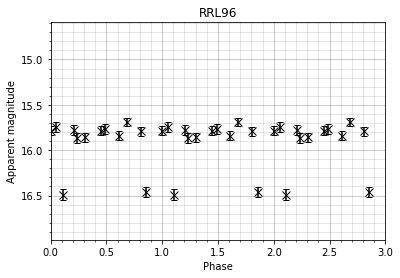

Chi squared:   256.429243996852
IQR:           0.08667128182427675
von Neumann:   0.521136466705504


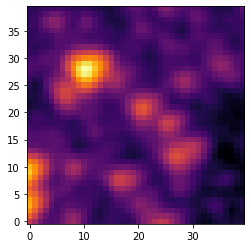

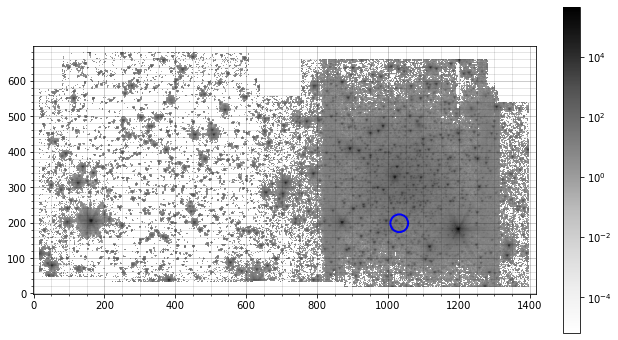

In [20]:
load_name = 'phot_tables/'+cluster+'/individual/big_table_all_'+method+'_'+channel+'.pickle'

pickle_in = open(load_name, 'rb')
big_table = pickle.load(pickle_in)

LC_time = []
for filename in glob.glob(base_dir+'*/'+cluster+'__e[0-9]_'+channel+'.fits', recursive=True) + glob.glob(base_dir+'*/'+cluster+'__e[0-9][0-9]_'+channel+'.fits', recursive=True):
    with fits.open(filename) as hdu_list:        
        hdr = hdu_list[0].header
    LC_time.append(Time(hdr['DATE_OBS'], format='isot', scale='utc').mjd)


###   FOR PLOTTING STAR FROM CATALOGUE   ###

###########
star_id = 96
###########

if star_id in starlist:

    file_CC = 'data/reference/CVSGC_'+cluster+'_readable.txt'
    df_CC = pd.read_csv(file_CC, sep=',', header=0)
    
    #c_CC = SkyCoord(df_CC['RA'][star_id], df_CC['dec'][star_id], frame='icrs', unit='deg')
    ra_temp = np.ma.masked_invalid(big_table['RA'])
    dec_temp = np.ma.masked_invalid(big_table['dec'])
    #c_comp = SkyCoord(ra_temp.compressed(), dec_temp.compressed(), frame='icrs', unit='deg')

    if df_CC['type'][star_id] == 'RR0':
        P = df_CC['period'][star_id]
        print('RRab')
    elif df_CC['type'][star_id] == 'RR1':
        P = df_CC['period'][star_id]
        print('RRc')
    elif df_CC['type'][star_id] == 'RR01':
        P = df_CC['period'][star_id]
        print('RRd')
    else:
        P = df_CC['period'][star_id]
        print('Something else')

    temp = [i / P for i in LC_time]
    phase = temp - np.floor(temp)  


    #big_table_i = big
    big_table_f = copy.copy(big_table.filled(-99))

    mags = []
    errs = []
    for i in range(1,13):
        mags.append(big_table['mag_e'+str(i)][star_id])
        errs.append(big_table['err_e'+str(i)][star_id])

    ### Masking out a specific data point (only use in emergencies, or the Science Police will get you):

    #remove_pls = 5  # EPOCH number of bad point
    #mags[remove_pls-1] = -99
    #print(mags)

    ###

    mags = np.ma.array(mags)
    #mags = np.ma.masked_where(mags == -99, mags)
    mags = np.ma.masked_invalid(mags)
    errs = np.ma.masked_array(errs, mags.mask)
    phase = np.ma.masked_array(phase, mags.mask)
    print('Mags: ', mags)
    print('Errs: ', errs)
    print('Phase: ', phase)

    ###   PLOTTING LIGHT CURVES   ###

    mags_long = np.ma.concatenate((mags, mags, mags))  # this idea taken from some of vicky's code; credit?
    errs_long = np.ma.concatenate((errs, errs, errs))
    phase_long = np.ma.concatenate((phase, phase + 1., phase + 2.))

    plt.errorbar(phase_long, mags_long, yerr=errs_long, fmt='x', color='black', capsize=3, markersize=8)
    plt.ylim(np.ma.median(mags) - 1.5*(max(mags)-min(mags)), np.ma.median(mags) + 1.5*(max(mags)-min(mags)))
    plt.xlim(0, 3)
    plt.gca().invert_yaxis()
    plt.minorticks_on()
    plt.grid(b=True, which='major', lw=.5, alpha=.4, color='black')
    plt.grid(b=True, which='minor', lw=.5, alpha=.2, color='black')
    plt.xlabel('Phase')
    plt.ylabel('Apparent magnitude')
    plt.title('RRL'+str(star_id))
    #plt.savefig('images/'+cluster+'/curves/'+method+'_'+channel+'_'+str(star_id)+'_'+str(model_epoch)+'.png', dpi=100)
    plt.show()

    ###   GAIA DR2 CURVE COMPARISON   ###
    
    if cluster == 'PAL5':

        vot_name = 'data/curves/proc_RRL'+str(star_id+1)+'.vot'

        if os.path.isfile(vot_name) == True:

            votable = parse_single_table(vot_name)
            data_vot = votable.array

            temp = [i / P for i in data_vot['obs_time']]
            phase_vot = temp - np.floor(temp)

            mags_vot = np.concatenate((data_vot['phot'], data_vot['phot'], data_vot['phot']))
            phases_vot = np.concatenate((phase_vot, phase_vot + 1., phase_vot + 2.))

            plt.plot(phases_vot, mags_vot, 'kx')
            plt.xlabel('Phase')
            plt.ylabel('Magnitude')
            plt.gca().invert_yaxis()
            plt.title('Gaia curve for RRL'+str(star_id))
            #plt.savefig('images/'+cluster+'/curves/gaia/RRL'+str(star_id+1), dpi=200)
            plt.show()

    ###   PRINTING VARIABILITY INFORMATION ETC.   ###

    print('Chi squared:  ', big_table['chi_sq'][star_id])
    print('IQR:          ', big_table['IQR'][star_id])
    print('von Neumann:  ', big_table['eta_inv'][star_id])

    ###   PLOTTING IMAGE OF STAR FROM MASTER FRAME   ###

    star_r = 20
    star_x = int(big_table['x_true'][star_id])
    star_y = int(big_table['y_true'][star_id])
    star_ap = CircularAperture((star_x, star_y), r=25.)

    region = data_m[star_y-star_r:star_y+star_r, star_x-star_r:star_x+star_r]
    plt.imshow(region, cmap='inferno', origin='lower', norm=LogNorm(), interpolation='nearest', aspect='equal')
    #star_ap.plot(color='white')
    plt.show()

    plt.imshow(data_m, cmap='Greys', origin='lower', norm=LogNorm(), interpolation='nearest')
    star_ap.plot(color='blue', lw=2.)
    plt.colorbar(fraction = 0.05)
    plt.minorticks_on()
    plt.grid(b=True, which='major', lw=.5, alpha=.4, color='black')
    plt.grid(b=True, which='minor', lw=.5, alpha=.2, color='black')
    plt.gcf().set_size_inches(10, 6)
    plt.show()

    #plotting(data_m, star_ap, an=None, cmap='Greys', choice='ap_only', savename=None)
    
else:
    print("RRL"+str(star_id)+" isn't visible in this channel")

In [23]:
t_CC = Table.from_pandas(df_CC)
#t_CC.sort('mean_mag_ch1')

checkthese_ch1 = []
checkthese_ch2 = []
for i in range(len(t_CC)):
    if t_CC['mean_mag_ch1'][i] < 15.4:
        checkthese_ch1.append(t_CC['id_new'][i])
    if t_CC['mean_mag_ch2'][i] < 15.4:
        checkthese_ch2.append(t_CC['id_new'][i])

print(checkthese_ch1)
print(checkthese_ch2)
t_CC.show_in_notebook()

[0, 3, 9, 12, 13, 14, 23, 28, 31, 41, 48, 53, 56, 65, 73, 74, 75, 78, 81, 83, 84, 88, 95, 97]
[0, 3, 9, 12, 13, 14, 23, 28, 31, 41, 48, 53, 56, 65, 68, 73, 74, 75, 78, 81, 83, 84, 88, 95, 97]


### Running GLOESS:

In [6]:
file_CC = 'data/reference/CVSGC_IC4499_readable.txt'
df_ic = pd.read_csv(file_CC, sep=',', header=0)

df_ic

ID            RA           dec units  period  mean_mag_CC  amplitude  \
0      1  15h00m53.07s  -82d12m49.8s    R0  0.6099       17.612       0.74   
1      2  15h00m34.18s  -82d14m25.0s    R0  0.4936       17.670       1.21   
2      3  14h59m28.92s  -82d14m39.6s    R0  0.4832       17.697       1.21   
3      4  14h59m54.70s  -82d12m38.1s    R0  0.6236       17.676       0.80   
4      5  14h59m54.37s  -82d13m39.7s    R0  0.5569       17.656       1.11   
..   ...           ...           ...   ...     ...          ...        ...   
130  153  14h59m10.31s  -82d15m46.8s    R0  0.2851       17.678       0.31   
131  167  15h00m26.10s  -82d12m35.0s    R0  0.7067       17.524       0.56   
132  171  15h00m42.31s  -82d13m45.2s    R0  0.2797       17.666       0.22   
133  172  15h00m16.85s  -82d11m33.7s    R0  0.0558       19.300       0.30   
134  173  14h59m09.00s  -82d11m11.3s    R0  0.3607       14.200        NaN   

    colour   type  
0        V    RR0  
1        V    RR0  
2        V    RR0  
3        V    RR0  
4        V    RR0  
..     ...    ...  
130      V    RR2  
131      V    RR0  
132      V    RR2  
133      V  SXPHE  
134      V    RR1  

[135 rows x 9 columns]

In [7]:
file_CC = 'data/reference/CVSGC_'+cluster+'_reduced_readable.txt'
df_CC = pd.read_csv(file_CC, sep=',', header=0)

tbl = Table.from_pandas(df_CC)
tbl.sort('type')
tbl.show_in_notebook()

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)



Star in forbidden zone (or isnt RRab/RRc)

RRab
Channel 1 mags:  [15.88541167 16.05769977 16.07177089 16.09764974 16.18633865 16.2814333
 16.22701549 15.94814217 16.00825338 16.09921674 16.08682154 16.1001556 ]
Channel 2 mags:  [16.06883936 99.         15.99904832 16.26282197 16.15486921 16.08615357
 16.28201236 16.19239225 16.10889582 16.11827646 16.05145948 15.97921278] 

RRL2 ---- Period = 0.4936 days
------------------------------------------------------
12 11
<[3.6]> = 16.102    std dev = 0.086     amplitude = 0.265
<[4.5]> = 16.135    std dev = 0.062     amplitude = 0.202
Channels don't have the same number of measurements, so colour curve couldn't be plotted


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


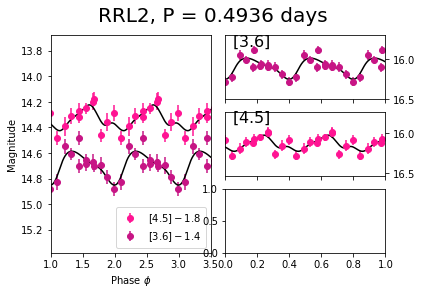

[nan, 0.02205767930696941]
new error ch1: 0.02205767930696941
new error ch2: 0.017552141856224394



RRab
Channel 1 mags:  [16.08996703 16.11011432 16.33861892 16.30359418 16.33947924 15.97145306
 15.9829214  15.99151626 16.08253132 99.         16.0945453  16.13183081]
Channel 2 mags:  [16.02047438 99.         16.08872279 16.16113679 16.1840448  15.97889293
 15.8823258  15.92557494 99.         15.99926547 16.14238768 16.18593872] 

RRL3 ---- Period = 0.4832 days
------------------------------------------------------
11 10


C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[3.6]> = 16.115    std dev = 0.104     amplitude = 0.325
<[4.5]> = 16.037    std dev = 0.096     amplitude = 0.274
Channels don't have the same number of measurements, so colour curve couldn't be plotted


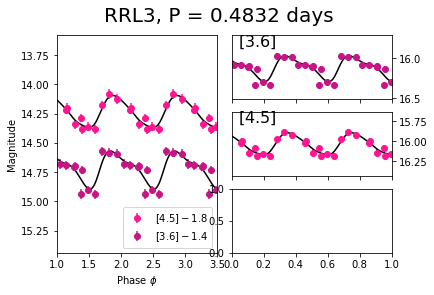

[nan, 0.02205767930696941, 0.028319874287772044]
new error ch1: 0.028319874287772044
new error ch2: 0.02497713111702254




Star in forbidden zone (or isnt RRab/RRc)


Star in forbidden zone (or isnt RRab/RRc)


Star in forbidden zone (or isnt RRab/RRc)

RRab
Channel 1 mags:  [15.95559097 15.67021373 16.01646958 15.93302003 15.9874559  15.64174126
 15.74567976 15.63849563 15.7897407  15.62167335 15.93015702 16.0707946 ]
Channel 2 mags:  [99.         99.         99.         99.         99.         99.
 15.7905455  15.7526059  99.         15.63992023 15.79764138 99.        ] 

RRL7 ---- Period = 0.6179 days
------------------------------------------------------
12 4


C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[3.6]> = 15.820    std dev = 0.092     amplitude = 0.256
<[4.5]> = 15.830    std dev = 0.107     amplitude = 0.354
Channels don't have the same number of measurements, so colour curve couldn't be plotted


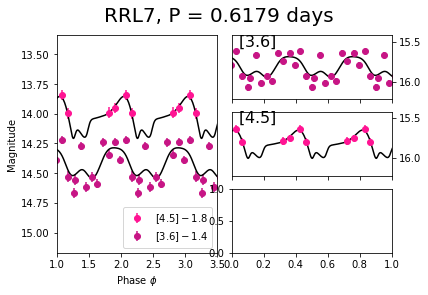

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446]
new error ch1: 0.021307906023734446
new error ch2: 0.05103889015521645




Star in forbidden zone (or isnt RRab/RRc)

RRab
Channel 1 mags:  [15.90919773 15.83086191 15.86801284 15.71206129 15.74244345 15.65133956
 15.54932481 15.69675432 15.71818672 15.64519707 15.59478953 15.71694141]
Channel 2 mags:  [15.84789418 15.74419376 15.67793867 15.66355599 15.63420794 15.50785011
 15.55968517 15.53462327 15.64589698 15.61612879 15.70828673 15.62401232] 

RRL9 ---- Period = 0.7096 days
------------------------------------------------------
12 12
<[3.6]> = 15.718    std dev = 0.080     amplitude = 0.236


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.654    std dev = 0.075     amplitude = 0.236
<[3.6] - [4.5]> = 0.064    std dev = 0.034     amplitude = 0.108


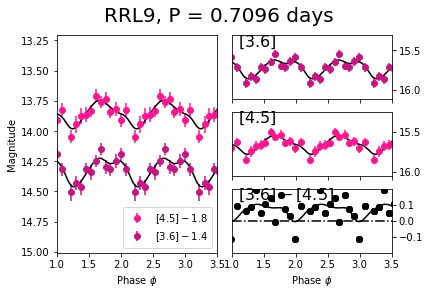

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, nan, 0.0196692504600741]
new error ch1: 0.0196692504600741
new error ch2: 0.019705055925177756




Star in forbidden zone (or isnt RRab/RRc)

RRab
Channel 1 mags:  [15.75817388 15.72535474 15.73864063 15.80943113 15.85092704 15.89813438
 15.87847135 15.90463321 15.84941483 15.7598148  15.731949   15.68129407]
Channel 2 mags:  [15.69420247 15.60498307 15.72668309 15.64916908 15.77147605 15.85691876
 15.81121888 15.79176175 15.73427925 15.7175583  15.68787449 15.65678855] 

RRL11 ---- Period = 0.6315 days
------------------------------------------------------
12 12
<[3.6]> = 15.801    std dev = 0.064     amplitude = 0.175
<[4.5]> = 15.728    std dev = 0.057     amplitude = 0.166


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[3.6] - [4.5]> = 0.073    std dev = 0.016     amplitude = 0.052


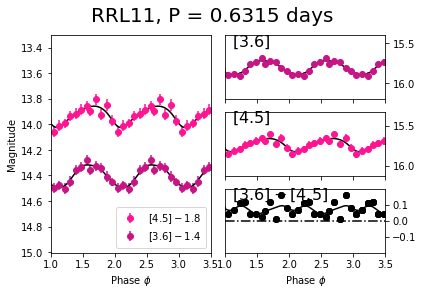

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, nan, 0.0196692504600741, nan, 0.014595259382162329]
new error ch1: 0.014595259382162329
new error ch2: 0.01382719556600446



RRab
Channel 1 mags:  [15.97034625 15.95621248 15.98723901 15.91155494 15.93471648 15.94618696
 15.84159963 15.98726273 16.01211639 16.14925145 15.98975872 15.91862064]
Channel 2 mags:  [15.90879524 15.94323608 15.89020614 15.89099223 15.72446898 15.82921832
 15.86021582 15.91187948 16.00208338 15.9547324  16.00025816 15.97872521] 

RRL12 ---- Period = 0.5948 days
------------------------------------------------------
12 12
<[3.6]> = 15.968    std dev = 0.052     amplitude = 0.173


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.903    std dev = 0.065     amplitude = 0.191
<[3.6] - [4.5]> = 0.065    std dev = 0.036     amplitude = 0.123


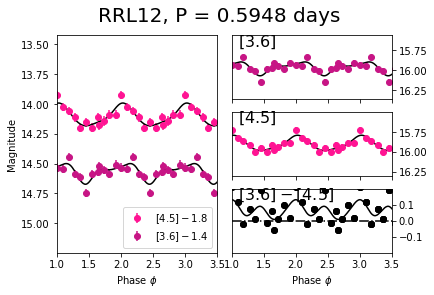

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, nan, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757]
new error ch1: 0.014451822395278757
new error ch2: 0.01591443826410292




Star in forbidden zone (or isnt RRab/RRc)


Star in forbidden zone (or isnt RRab/RRc)


Star in forbidden zone (or isnt RRab/RRc)

RRab
Channel 1 mags:  [15.77053705 15.7674642  15.93960602 15.93376283 15.8298617  15.95564944
 16.01310218 15.98082186 15.86551851 15.79486066 15.7203626  15.80394838]
Channel 2 mags:  [15.77987166 15.78652817 15.84657042 15.86402428 15.94194193 15.98751186
 16.02012993 15.97123529 15.90302303 15.86030602 15.83476132 15.77183569] 

RRL16 ---- Period = 0.5773 days
------------------------------------------------------
12 12
<[3.6]> = 15.877    std dev = 0.078     amplitude = 0.242


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.891    std dev = 0.077     amplitude = 0.221
<[3.6] - [4.5]> = -0.014    std dev = 0.039     amplitude = 0.131


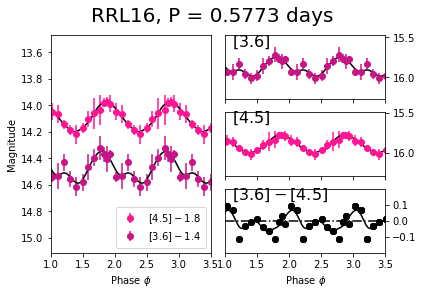

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, nan, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957]
new error ch1: 0.02016614829715957
new error ch2: 0.01840078415101794




Star in forbidden zone (or isnt RRab/RRc)


Star in forbidden zone (or isnt RRab/RRc)

RRab
Channel 1 mags:  [16.28592702 16.11200813 15.99539348 15.99243616 15.89638505 16.02035399
 15.97722936 16.0586189  16.09434212 15.91782652 16.20195101 15.9586876 ]
Channel 2 mags:  [16.25743206 16.23255992 16.19655849 15.98278664 15.94133423 15.86636645
 15.87186192 16.0420035  15.94753548 15.96033159 16.24355203 16.20032595] 

RRL19 ---- Period = 0.5306 days
------------------------------------------------------
12 12
<[3.6]> = 16.028    std dev = 0.060     amplitude = 0.191


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 16.029    std dev = 0.120     amplitude = 0.358
<[3.6] - [4.5]> = -0.001    std dev = 0.096     amplitude = 0.285


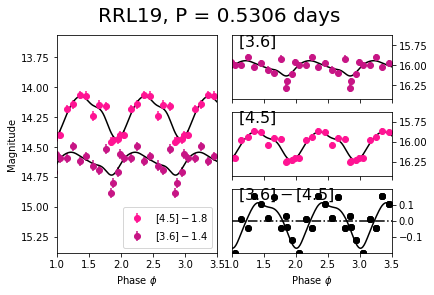

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, nan, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, nan, 0.015935665113477143]
new error ch1: 0.015935665113477143
new error ch2: 0.02979787873573425



RRab
Channel 1 mags:  [15.76265842 15.84605193 15.68654859 15.76859427 15.65332493 15.87566882
 15.75941451 15.95880647 16.13019289 15.97649264 15.98498934 15.97177793]
Channel 2 mags:  [17.20397359 16.9963746  17.21233183 17.01461615 17.01134934 17.10038591
 16.98383462 17.11023256 16.90226702 17.0363812  16.96471578 17.19546   ] 

RRL20 ---- Period = 0.6482 days
------------------------------------------------------
12 12
<[3.6]> = 15.857    std dev = 0.116     amplitude = 0.333


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 17.055    std dev = 0.042     amplitude = 0.144
<[3.6] - [4.5]> = -1.198    std dev = 0.140     amplitude = 0.396


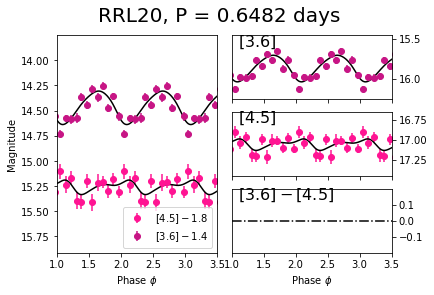


Star in forbidden zone (or isnt RRab/RRc)

RRab
Channel 1 mags:  [16.45002514 16.46959824 16.5568807  16.50527014 16.46246809 16.53885453
 16.43709203 16.48629472 16.462642   16.36308576 16.54256596 16.65217959]
Channel 2 mags:  [] 

RRL22 ---- Period = 0.6747 days
------------------------------------------------------
12 0


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[3.6]> = 16.495    std dev = 0.033     amplitude = 0.123
Channels don't have the same number of measurements, so colour curve couldn't be plotted


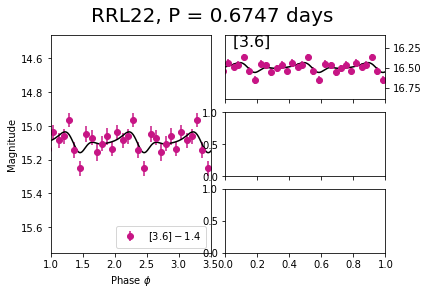

RRab
Channel 1 mags:  [16.17617653 16.14464581 16.08683989 15.95471747 15.91349249 16.0009054
 15.92318156 16.0817096  16.10294641 16.04404961 16.14824257 16.10517928]
Channel 2 mags:  [16.06883456 16.16183955 15.92836989 15.78866142 15.91900852 15.89024843
 15.87562451 15.8894838  16.05359232 16.12969128 16.14605557 16.06212166] 

RRL23 ---- Period = 0.5077 days
------------------------------------------------------
12 12
<[3.6]> = 16.039    std dev = 0.072     amplitude = 0.202


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.969    std dev = 0.097     amplitude = 0.266
<[3.6] - [4.5]> = 0.069    std dev = 0.034     amplitude = 0.110


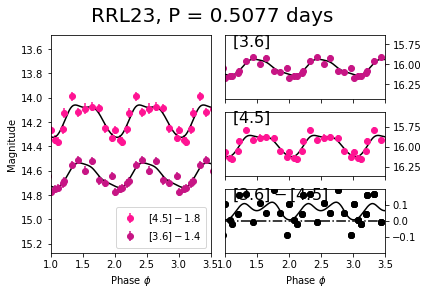

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, nan, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, nan, 0.015935665113477143, nan, nan, nan, 0.01684938417110719]
new error ch1: 0.01684938417110719
new error ch2: 0.022165795155387524




Star in forbidden zone (or isnt RRab/RRc)

RRab
Channel 1 mags:  [99.         15.69962267 15.74928898 15.66606431 99.         15.63511391
 15.73881422 15.63284513 15.76485288 15.77880757 15.62817766 15.85986978]
Channel 2 mags:  [15.83536925 15.92512779 15.70846746 15.63030661 15.64733412 15.61779887
 15.62536458 15.69908229 15.67434028 15.74049154 15.75355783 15.83573223] 

RRL25 ---- Period = 0.6022 days
------------------------------------------------------
10 12
<[3.6]> = 15.710    std dev = 0.033     amplitude = 0.103


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.714    std dev = 0.076     amplitude = 0.225
Channels don't have the same number of measurements, so colour curve couldn't be plotted


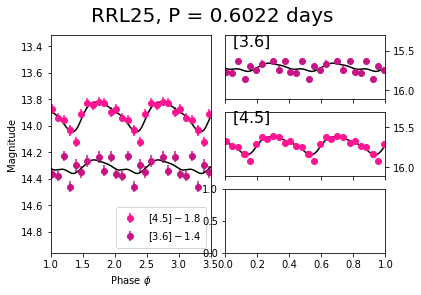

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, nan, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, nan, 0.015935665113477143, nan, nan, nan, 0.01684938417110719, nan, 0.009366173836899076]
new error ch1: 0.009366173836899076
new error ch2: 0.018726279838450804



RRab
Channel 1 mags:  []
Channel 2 mags:  [] 

RRab
Channel 1 mags:  [15.95387412 15.98772608 15.9083224  15.96346818 15.91580267 15.99468315
 16.18493836 16.25093491 16.24635668 15.89840978 15.95293189 16.00145894]
Channel 2 mags:  [15.94410141 16.01662856 15.99125039 15.98910978 15.95392355 15.96398587
 15.93084424 16.10884465 16.19582228 16.02511219 15.98065287 15.89302687] 

RRL27 ---- Period = 0.5068 days
------------------------------------------------------
12 12
<[3.6]> = 16.036    std dev = 0.107     amplitude = 0.305


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 16.002    std dev = 0.057     amplitude = 0.174
<[3.6] - [4.5]> = 0.034    std dev = 0.075     amplitude = 0.228


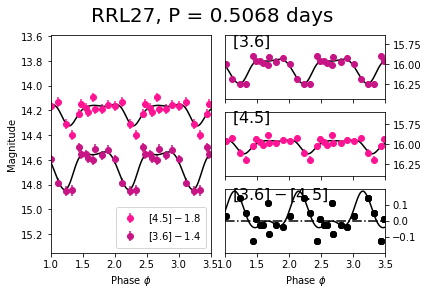

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, nan, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, nan, 0.015935665113477143, nan, nan, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902]
new error ch1: 0.02541749839552902
new error ch2: 0.014474421280207187




Star in forbidden zone (or isnt RRab/RRc)


Star in forbidden zone (or isnt RRab/RRc)

RRab
Channel 1 mags:  [15.97025726 15.95140177 16.04741672 16.15890477 15.92648448 15.86141791
 15.82823838 15.89946849 15.96382094 15.85076061 15.94037749 15.92628286]
Channel 2 mags:  [15.90692868 15.93870751 15.95557797 16.03397121 16.07360269 15.75089831
 15.82013524 15.94265569 15.93733676 99.         15.91880692 15.99558284] 

RRL30 ---- Period = 0.5289 days
------------------------------------------------------
12 11


C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[3.6]> = 15.938    std dev = 0.066     amplitude = 0.218
<[4.5]> = 15.930    std dev = 0.061     amplitude = 0.220
Channels don't have the same number of measurements, so colour curve couldn't be plotted


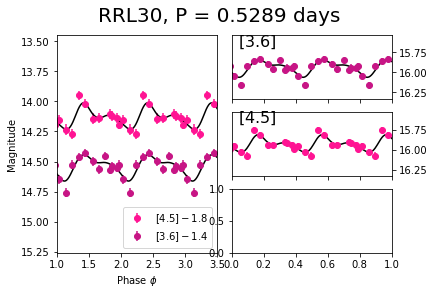

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, nan, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, nan, 0.015935665113477143, nan, nan, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218]
new error ch1: 0.01819808922893218
new error ch2: 0.019174929170803608




Star in forbidden zone (or isnt RRab/RRc)


Star in forbidden zone (or isnt RRab/RRc)

RRab
Channel 1 mags:  []
Channel 2 mags:  [] 

RRab
Channel 1 mags:  [15.97988845 16.15073737 16.29583087 16.1781573  16.35742392 16.1205889
 16.02761412 15.94190527 15.91750876 16.1301271  15.94594196 16.06103249]
Channel 2 mags:  [16.06109544 16.12353543 16.1396938  16.3240075  16.3469577  16.17813223
 15.97557952 16.00623463 16.03918909 16.15013134 16.08228352 16.04245704] 

RRL34 ---- Period = 0.4936 days
------------------------------------------------------
12 12
<[3.6]> = 16.089

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 16.130    std dev = 0.102     amplitude = 0.334
<[3.6] - [4.5]> = -0.041    std dev = 0.031     amplitude = 0.104


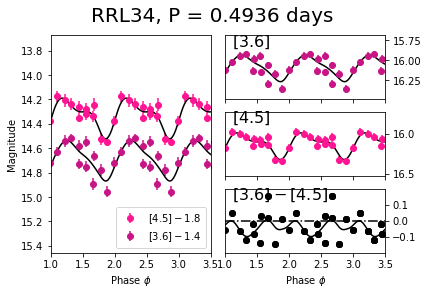

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, nan, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, nan, 0.015935665113477143, nan, nan, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106]
new error ch1: 0.02764399924573106
new error ch2: 0.027818886560578477



RRab
Channel 1 mags:  [15.66933892 15.57136231 99.         15.65802211 99.         15.72534349
 15.77764695 99.         15.61772908 15.62697717 15.48417989 15.5812578 ]
Channel 2 mags:  [15.61068108 15.52381405 15.63823519 15.61255174 15.6955665  15.77290169
 15.74389445 15.76316602 15.65253768 15.57023174 15.56244993 15.61898462] 

RRL35 ---- Period = 0.6498 days
------------------------------------------------------
9 12


C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 15.644    std dev = 0.061     amplitude = 0.195


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.648    std dev = 0.066     amplitude = 0.182
Channels don't have the same number of measurements, so colour curve couldn't be plotted


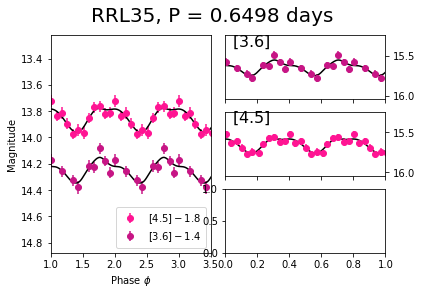

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, nan, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, nan, 0.015935665113477143, nan, nan, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126]
new error ch1: 0.01871798176793126
new error ch2: 0.015188076796218475




Star in forbidden zone (or isnt RRab/RRc)

RRab
Channel 1 mags:  [15.83111498 15.85749669 15.98519357 16.00203594 15.97752274 16.05446752
 15.95251833 15.86777475 15.8006041  15.77401312 15.82193415 15.80843883]
Channel 2 mags:  [15.80789687 15.83681441 15.83849566 15.86223482 15.8606728  16.02256729
 15.80072402 15.81978603 15.76254367 15.71528749 15.74364861 15.77121519] 

RRL37 ---- Period = 0.6123 days
------------------------------------------------------
12 12
<[3.6]> = 15.900    std dev = 0.083     amplitude

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.822    std dev = 0.058     amplitude = 0.178
<[3.6] - [4.5]> = 0.078    std dev = 0.029     amplitude = 0.091


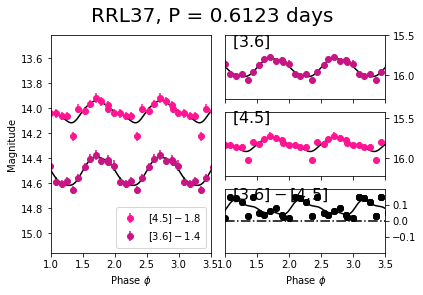

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, nan, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, nan, 0.015935665113477143, nan, nan, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126, nan, 0.018725618383013416]
new error ch1: 0.018725618383013416
new error ch2: 0.014858072864653534



RRab
Channel 1 mags:  []
Channel 2 mags:  [] 

RRab
Channel 1 mags:  [15.8317743  15.80978728 15.83315739 15.72685108 15.82916105 15.88124492
 15.91467411 16.0590859  16.04551271 15.82443524 15.74608172 15.8092162 ]
Channel 2 mags:  [15.72321813 15.80821513 15.78055972 15.85148049 15.81911963 15.84310356
 15.86432647 15.89229625 16.02168334 15.97337878 15.8064542  15.87523304] 

RRL39 ---- Period = 0.5365 days
------------------------------------------------------
12 12
<[3.6]> = 15.871  

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.862    std dev = 0.052     amplitude = 0.163
<[3.6] - [4.5]> = 0.009    std dev = 0.046     amplitude = 0.145


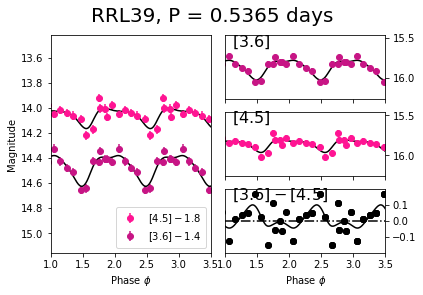

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, nan, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, nan, 0.015935665113477143, nan, nan, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126, nan, 0.018725618383013416, nan, 0.020445225143792545]
new error ch1: 0.020445225143792545
new error ch2: 0.013573617713134775




Star in forbidden zone (or isnt RRab/RRc)

RRab
Channel 1 mags:  []
Channel 2 mags:  [] 

RRab
Channel 1 mags:  [14.70788894 14.81568745 14.76411963 14.68279937 14.78648506 14.65489477
 14.74636727 14.69054285 14.73948173 14.70929989 14.77927021 14.74152668]
Channel 2 mags:  [14.57470855 14.50099609 14.50142862 14.52531272 14.53975509 14.58148106
 14.53323711 14.58077105 14.57226101 14.56830434 14.51183585 14.51448228] 

RRL42 ---- Period = 0.5254 days
--------

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 14.546    std dev = 0.023     amplitude = 0.071
<[3.6] - [4.5]> = 0.185    std dev = 0.042     amplitude = 0.123


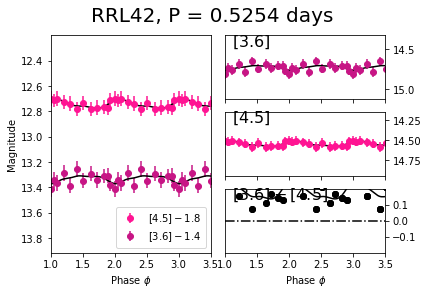

RRab
Channel 1 mags:  []
Channel 2 mags:  [] 

RRab
Channel 1 mags:  []
Channel 2 mags:  [17.73411079 15.94072604 16.0758434  16.17007593 15.80151541 17.8712648
 15.80308531 15.77930492 15.74004876 15.88156317 15.85002115 16.41619445] 

RRL44 ---- Period = 0.5599 days
------------------------------------------------------
0 12


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.940    std dev = 0.133     amplitude = 0.374
Channels don't have the same number of measurements, so colour curve couldn't be plotted


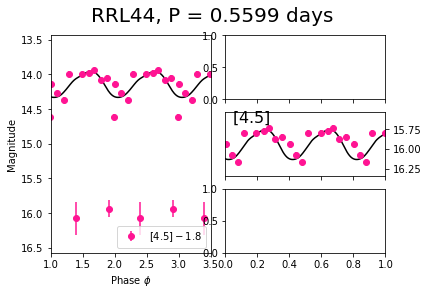

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, nan, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, nan, 0.015935665113477143, nan, nan, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126, nan, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan]
new error ch1: nan
new error ch2: 0.03118914559677736



RRab
Channel 1 mags:  [15.9288828  15.89522965 16.02898789 16.00918344 16.04507279 16.01712176
 15.89275189 15.8699589  15.86902281 15.7053566  15.86182734 15.92202804]
Channel 2 mags:  [15.7569994  15.87603073 15.88381047 15.96087481 15.97302714 15.84543989
 15.84845023 15.74517222 15.8581738  15.8582946  15.85801302 15.81407632] 

RRL45 ---- Period = 0.5833 days
------------------------------------------------------
12 12
<[3.6]> = 15.920    std dev = 0

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.861    std dev = 0.046     amplitude = 0.140
<[3.6] - [4.5]> = 0.059    std dev = 0.053     amplitude = 0.170


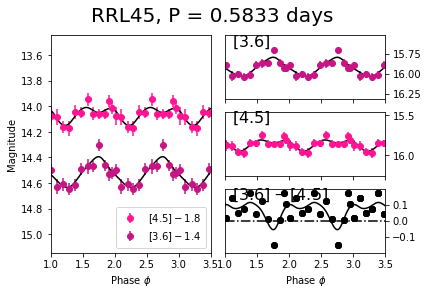

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, nan, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, nan, 0.015935665113477143, nan, nan, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126, nan, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092]
new error ch1: 0.01997602667697092
new error ch2: 0.011689666638514229




Star in forbidden zone (or isnt RRab/RRc)

RRab
Channel 1 mags:  [16.07025425 16.12910685 16.07091523 16.07488746 16.17250724 15.91816459
 16.05563539 16.02433611 16.00992125 15.98581279 16.02457067 16.09299816]
Channel 2 mags:  [16.01029348 16.07621485 16.01569755 16.13564741 16.12827493 16.01392981
 15.9409924  15.99530883 15.97378953 99.         15.97946836 16.15571914] 

RRL47 ---- Period = 0.4991 days
----------

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[3.6]> = 16.048    std dev = 0.036     amplitude = 0.106
<[4.5]> = 16.033    std dev = 0.056     amplitude = 0.163
Channels don't have the same number of measurements, so colour curve couldn't be plotted


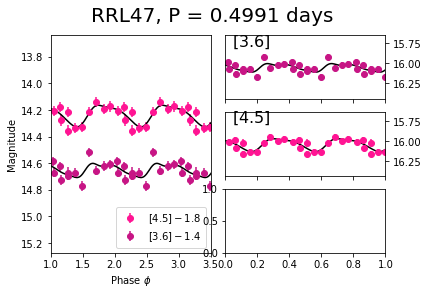

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, nan, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, nan, 0.015935665113477143, nan, nan, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126, nan, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, nan, 0.008871178682373268]
new error ch1: 0.008871178682373268
new error ch2: 0.014174223551094628



RRab
Channel 1 mags:  [15.80027791 99.         15.97115833 15.74125266 15.79513887 15.87820864
 16.35627622 99.         15.65471656 15.86034004 15.74792846 15.80463547]
Channel 2 mags:  [99.         99.         99.         16.0193543  15.84955871 15.86186344
 99.         99.         15.88880381 99.         99.         99.        ] 

RRL48 ---- Period = 0.5658 days
--------------------------

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 15.844    std dev = 0.095     amplitude = 0.338
<[4.5]> = 15.948    std dev = 0.101     amplitude = 0.297
Channels don't have the same number of measurements, so colour curve couldn't be plotted


C:\Users\Jake\MPhys-code\MPhys-RRL\final_scripts\gloess_fits.py:69: RuntimeWarning: invalid value encountered in sqrt
  sigma_c3=np.sqrt(ai33)
C:\Users\Jake\MPhys-code\MPhys-RRL\final_scripts\gloess_fits.py:67: RuntimeWarning: invalid value encountered in sqrt
  sigma_c1=np.sqrt(ai11)
C:\Users\Jake\MPhys-code\MPhys-RRL\final_scripts\gloess_fits.py:68: RuntimeWarning: invalid value encountered in sqrt
  sigma_c2=np.sqrt(ai22)
C:\Users\Jake\MPhys-code\MPhys-RRL\final_scripts\gloess_fits.py:51: RuntimeWarning: invalid value encountered in double_scalars
  ai11=cofa11/det
C:\Users\Jake\MPhys-code\MPhys-RRL\final_scripts\gloess_fits.py:52: RuntimeWarning: invalid value encountered in double_scalars
  ai12=cofa21/det
C:\Users\Jake\MPhys-code\MPhys-RRL\final_scripts\gloess_fits.py:53: RuntimeWarning: invalid value encountered in double_scalars
  ai13=cofa31/det
C:\Users\Jake\MPhys-code\MPhys-RRL\final_scripts\gloess_fits.py:55: RuntimeWarning: invalid value encountered in double_scalars
  ai2

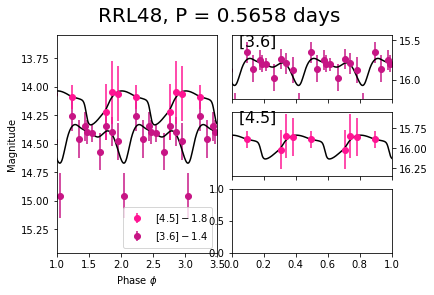

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, nan, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, nan, 0.015935665113477143, nan, nan, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126, nan, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, nan, 0.008871178682373268, 0.03083994437805023]
new error ch1: 0.03083994437805023
new error ch2: 0.042936318545389




Star in forbidden zone (or isnt RRab/RRc)

RRab
Channel 1 mags:  [16.00354504 16.07692224 16.0324734  16.10340186 15.85439123 15.99353532
 15.98494879 15.93412868 15.93862553 16.0170203  16.04561582 15.9357012 ]
Channel 2 mags:  [15.9767837  16.02554036 16.02261863 16.10442633 15.99131945 16.02998774
 15.90792241 15.95653034 16.0444405  15.87216005 15.91448227 16.01049553]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


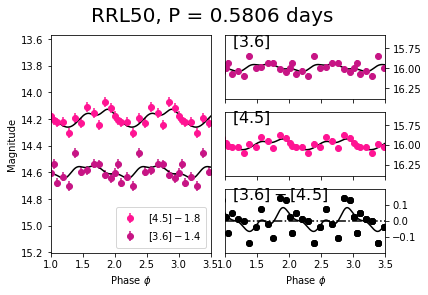

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, nan, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, nan, 0.015935665113477143, nan, nan, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126, nan, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, nan, 0.008871178682373268, 0.03083994437805023, nan, 0.007891469496489556]
new error ch1: 0.007891469496489556
new error ch2: 0.011171376290898186



RRab
Channel 1 mags:  [15.64577209 15.99093971 15.75101838 15.78715174 15.92555535 15.78285624
 16.35478792 15.91848182 15.87189235 15.86330924 15.68581833 15.72147221]
Channel 2 mags:  [15.73942973 15.94439633 15.82461484 15.81289676 99.         15.90767468
 15.98788872 15.79742418 99.         99.         15.66212776 15.78815745] 

RRL51 ----

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[3.6]> = 15.859    std dev = 0.096     amplitude = 0.316
<[4.5]> = 15.817    std dev = 0.081     amplitude = 0.268
Channels don't have the same number of measurements, so colour curve couldn't be plotted


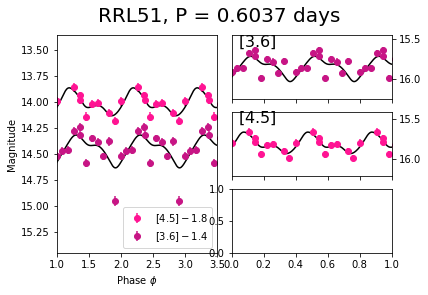

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, nan, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, nan, 0.015935665113477143, nan, nan, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126, nan, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, nan, 0.008871178682373268, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696]
new error ch1: 0.0263297047389696
new error ch2: 0.025807150919949257



RRab
Channel 1 mags:  []
Channel 2 mags:  [] 


Star in forbidden zone (or isnt RRab/RRc)


Star in forbidden zone (or isnt RRab/RRc)


Star in forbidden zone (or isnt RRab/RRc)

RRab
Channel 1 mags:  [15.8288475  15.98132427 16.10804907 16.120271   15.98013645 15.96643531
 16.09210971 15.93412188 15.9757253  15.91646403 16.0

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.972    std dev = 0.047     amplitude = 0.145
<[3.6] - [4.5]> = 0.009    std dev = 0.040     amplitude = 0.135


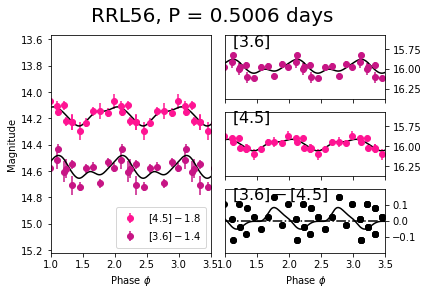

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, nan, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, nan, 0.015935665113477143, nan, nan, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126, nan, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, nan, 0.008871178682373268, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, nan, nan, nan, 0.01441594851329612]
new error ch1: 0.01441594851329612
new error ch2: 0.012081822523256106




Star in forbidden zone (or isnt RRab/RRc)


Star in forbidden zone (or isnt RRab/RRc)

RRab
Channel 1 mags:  []
Channel 2 mags:  [] 


Star in forbidden zone (or isnt RRab/RRc)

RRab
Channel 1 mags:  [15.8848578  15.99890518 15.95912398 16.02974915 15.74395865 15.87357579
 15.8511457

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 15.874    std dev = 0.054     amplitude = 0.179


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.809    std dev = 0.109     amplitude = 0.328
Channels don't have the same number of measurements, so colour curve couldn't be plotted


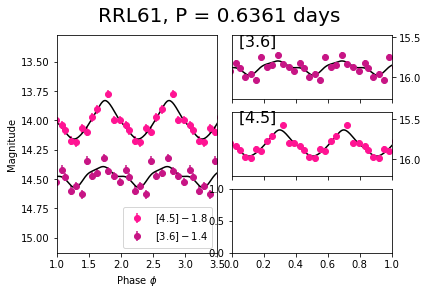

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, nan, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, nan, 0.015935665113477143, nan, nan, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126, nan, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, nan, 0.008871178682373268, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, nan, nan, nan, 0.01441594851329612, nan, nan, nan, nan, 0.014927759422480738]
new error ch1: 0.014927759422480738
new error ch2: 0.028568573721776406




Star in forbidden zone (or isnt RRab/RRc)

RRab
Channel 1 mags:  [15.94019329 15.96420487 15.87654548 15.81981649 15.6819578  15.75107359
 15.79074855 15.75504768 15.83742729 15.99414389 15.97985151 15.81484973]
Channel 2 mags:  [16.00967092

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



<[3.6] - [4.5]> = 0.052    std dev = 0.072     amplitude = 0.226


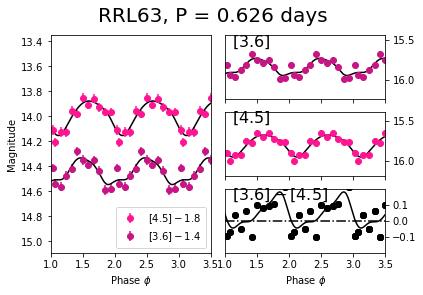

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, nan, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, nan, 0.015935665113477143, nan, nan, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126, nan, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, nan, 0.008871178682373268, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, nan, nan, nan, 0.01441594851329612, nan, nan, nan, nan, 0.014927759422480738, nan, 0.01779479145943637]
new error ch1: 0.01779479145943637
new error ch2: 0.02303313497244878



RRc
Channel 1 mags:  [16.01821594 16.13412928 16.28265769 16.38464605 16.61152932 16.59606138
 16.15415477 16.2919999  16.533605   16.46687713 16.33607981 16.19868494]
Channel 2 mags:  [16.20615251 16.17696761 16.24727

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



<[3.6] - [4.5]> = 0.017    std dev = 0.121     amplitude = 0.355


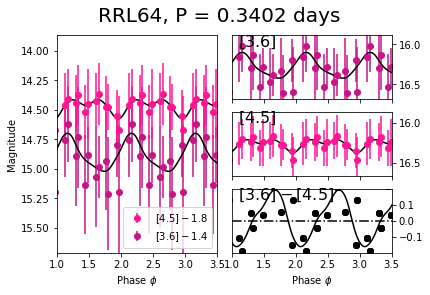

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, nan, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, nan, 0.015935665113477143, nan, nan, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126, nan, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, nan, 0.008871178682373268, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, nan, nan, nan, 0.01441594851329612, nan, nan, nan, nan, 0.014927759422480738, nan, 0.01779479145943637, 0.02679323088976589]
new error ch1: 0.02679323088976589
new error ch2: 0.013400786506440276




Star in forbidden zone (or isnt RRab/RRc)


Star in forbidden zone (or isnt RRab/RRc)


Star in forbidden zone (or isnt RRab/RRc)


Star in forbidden zone (or isnt RRab/RRc)


Star in forbidden z

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[3.6]> = 15.836    std dev = 0.068     amplitude = 0.187
Channels don't have the same number of measurements, so colour curve couldn't be plotted


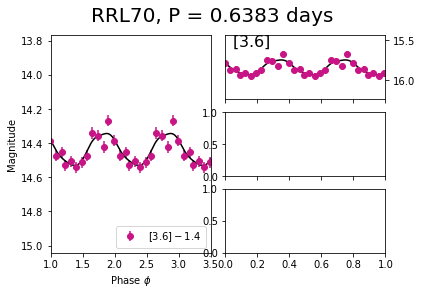

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, nan, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, nan, 0.015935665113477143, nan, nan, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126, nan, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, nan, 0.008871178682373268, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, nan, nan, nan, 0.01441594851329612, nan, nan, nan, nan, 0.014927759422480738, nan, 0.01779479145943637, 0.02679323088976589, nan, nan, nan, nan, nan, 0.015547056280382924]
new error ch1: 0.015547056280382924
new error ch2: nan



RRc
Channel 1 mags:  [16.05595861 16.10962625 16.16575095 16.24510568 16.17401004 16.14121826
 16.24293351 16.10279407 16.14774248 16.13611033 16.18579136 16.1506254

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 16.089    std dev = 0.039     amplitude = 0.114
<[3.6] - [4.5]> = 0.064    std dev = 0.028     amplitude = 0.090


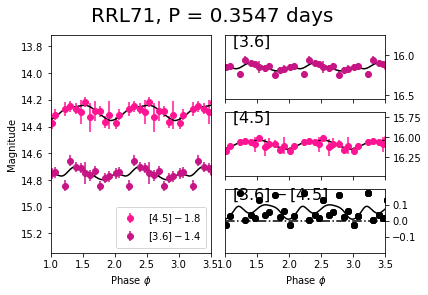

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, nan, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, nan, 0.015935665113477143, nan, nan, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126, nan, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, nan, 0.008871178682373268, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, nan, nan, nan, 0.01441594851329612, nan, nan, nan, nan, 0.014927759422480738, nan, 0.01779479145943637, 0.02679323088976589, nan, nan, nan, nan, nan, 0.015547056280382924, 0.008230332497542866]
new error ch1: 0.008230332497542866
new error ch2: 0.009491446050346871




Star in forbidden zone (or isnt RRab/RRc)

RRab
Channel 1 mags:  []
Channel 2 mags:  [] 


Star in forbidden zone (or isnt RR

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[3.6] - [4.5]> = 0.068    std dev = 0.037     amplitude = 0.117


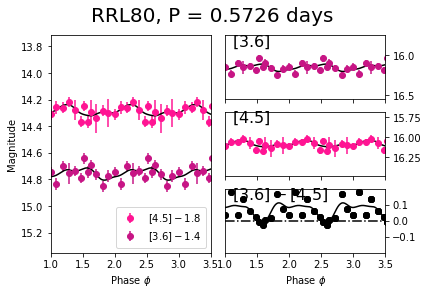

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, nan, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, nan, 0.015935665113477143, nan, nan, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126, nan, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, nan, 0.008871178682373268, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, nan, nan, nan, 0.01441594851329612, nan, nan, nan, nan, 0.014927759422480738, nan, 0.01779479145943637, 0.02679323088976589, nan, nan, nan, nan, nan, 0.015547056280382924, 0.008230332497542866, nan, nan, nan, nan, nan, nan, nan, nan, 0.007677137609318763]
new error ch1: 0.007677137609318763
new error ch2: 0.006945685148213106




Star in forbidden zone (or isnt RRab/RRc)


Star in forbidden z

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 16.196    std dev = 0.020     amplitude = 0.065
<[4.5]> = 16.140    std dev = 0.100     amplitude = 0.339

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Channels don't have the same number of measurements, so colour curve couldn't be plotted


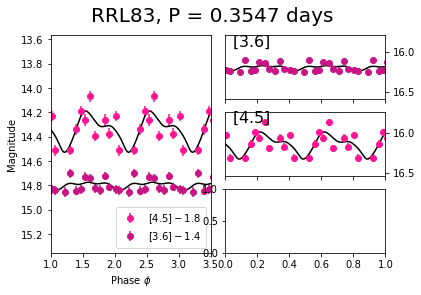

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, nan, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, nan, 0.015935665113477143, nan, nan, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126, nan, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, nan, 0.008871178682373268, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, nan, nan, nan, 0.01441594851329612, nan, nan, nan, nan, 0.014927759422480738, nan, 0.01779479145943637, 0.02679323088976589, nan, nan, nan, nan, nan, 0.015547056280382924, 0.008230332497542866, nan, nan, nan, nan, nan, nan, nan, nan, 0.007677137609318763, nan, nan, 0.005395401355338336]
new error ch1: 0.005395401355338336
new error ch2: 0.030922672649735583




Star in forbidden zone (or isnt

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[3.6] - [4.5]> = 0.070    std dev = 0.043     amplitude = 0.141


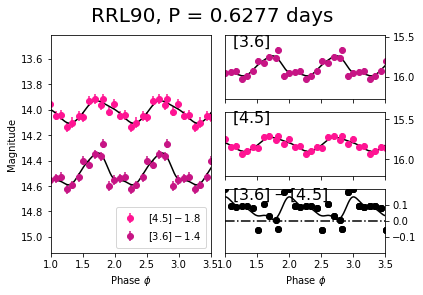

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, nan, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, nan, 0.015935665113477143, nan, nan, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126, nan, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, nan, 0.008871178682373268, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, nan, nan, nan, 0.01441594851329612, nan, nan, nan, nan, 0.014927759422480738, nan, 0.01779479145943637, 0.02679323088976589, nan, nan, nan, nan, nan, 0.015547056280382924, 0.008230332497542866, nan, nan, nan, nan, nan, nan, nan, nan, 0.007677137609318763, nan, nan, 0.005395401355338336, nan, nan, nan, nan, nan, nan, 0.020924811657135518]
new error ch1: 0.020924811657135518
new error ch2: 0.01

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.647    std dev = 0.052     amplitude = 0.146
<[3.6] - [4.5]> = 0.027    std dev = 0.015     amplitude = 0.062


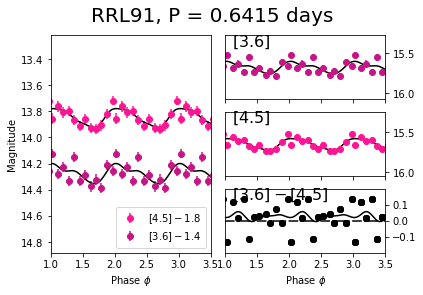

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, nan, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, nan, 0.015935665113477143, nan, nan, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126, nan, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, nan, 0.008871178682373268, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, nan, nan, nan, 0.01441594851329612, nan, nan, nan, nan, 0.014927759422480738, nan, 0.01779479145943637, 0.02679323088976589, nan, nan, nan, nan, nan, 0.015547056280382924, 0.008230332497542866, nan, nan, nan, nan, nan, nan, nan, nan, 0.007677137609318763, nan, nan, 0.005395401355338336, nan, nan, nan, nan, nan, nan, 0.020924811657135518, 0.012842999751020509]
new error ch1: 0.0128429997510205

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 16.168    std dev = 0.132     amplitude = 0.414
<[4.5]> = 16.192    std dev = 0.043     amplitude = 0.143


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[3.6] - [4.5]> = -0.024    std dev = 0.156     amplitude = 0.517


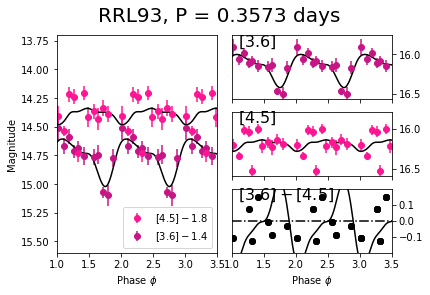

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, nan, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, nan, 0.015935665113477143, nan, nan, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126, nan, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, nan, 0.008871178682373268, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, nan, nan, nan, 0.01441594851329612, nan, nan, nan, nan, 0.014927759422480738, nan, 0.01779479145943637, 0.02679323088976589, nan, nan, nan, nan, nan, 0.015547056280382924, 0.008230332497542866, nan, nan, nan, nan, nan, nan, nan, nan, 0.007677137609318763, nan, nan, 0.005395401355338336, nan, nan, nan, nan, nan, nan, 0.020924811657135518, 0.012842999751020509, nan, 0.03607591954777576]
new err

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 12.737    std dev = 0.066     amplitude = 0.225
<[4.5]> = 12.809    std dev = 0.036     amplitude = 0.105

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Channels don't have the same number of measurements, so colour curve couldn't be plotted


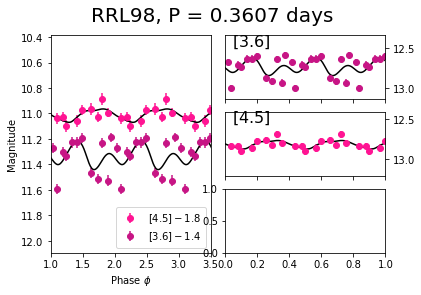

98
[nan, 16.062549046114, 16.07514475715958, nan, nan, nan, 15.7801954817224, nan, 15.679308001507556, nan, 15.761648965163737, 15.928938471000391, nan, nan, nan, 15.837110240504098, nan, nan, 15.987823548500344, nan, nan, nan, 15.999854031494975, nan, 15.67024307628635, nan, 15.99737901538643, nan, nan, 15.898605252823803, nan, nan, nan, 16.049486433483978, 15.604707889222606, nan, 15.859879574307694, nan, 15.830914024157257, nan, nan, nan, nan, nan, 15.880644667004951, nan, 16.00928849310882, 15.803672489732563, nan, 15.951438296780513, 15.819271321621434, nan, nan, nan, nan, 15.940986078869626, nan, nan, nan, nan, 15.835330861876374, nan, 15.806821181066642, 16.246031686418394, nan, nan, nan, nan, nan, 15.79539268398306, 16.114394912989045, nan, nan, nan, nan, nan, nan, nan, nan, 16.115466633272938, nan, nan, 16.15673790440372, nan, nan, nan, nan, nan, nan, 15.844792548093572, 15.635446237264775, nan, 16.127293308584097, nan, nan, nan, nan, nan]


ID            RA           dec units  period  mean_mag_CC  amplitude  \
0     1  15h00m53.07s  -82d12m49.8s    R0  0.6099       17.612       0.74   
1     2  15h00m34.18s  -82d14m25.0s    R0  0.4936       17.670       1.21   
2     3  14h59m28.92s  -82d14m39.6s    R0  0.4832       17.697       1.21   
3     4  14h59m54.70s  -82d12m38.1s    R0  0.6236       17.676       0.80   
4     5  14h59m54.37s  -82d13m39.7s    R0  0.5569       17.656       1.11   
..  ...           ...           ...   ...     ...          ...        ...   
93  112  14h59m55.31s  -82d11m50.3s    R0  0.6113       17.717       0.44   
94  153  14h59m10.31s  -82d15m46.8s    R0  0.2851       17.678       0.31   
95  167  15h00m26.10s  -82d12m35.0s    R0  0.7067       17.524       0.56   
96  171  15h00m42.31s  -82d13m45.2s    R0  0.2797       17.666       0.22   
97  173  14h59m09.00s  -82d11m11.3s    R0  0.3607       14.200        NaN   

   colour type  id_new  ...  mean_photerr_amp_ch2  mean_photerr_mon_ch1  \
0       V  RR0       0  ...                   NaN                   NaN   
1       V  RR0       1  ...              0.017552              0.015702   
2       V  RR0       2  ...              0.024977              0.011315   
3       V  RR0       3  ...                   NaN                   NaN   
4       V  RR0       4  ...                   NaN                   NaN   
..    ...  ...     ...  ...                   ...                   ...   
93      V  RR0      93  ...                   NaN                   NaN   
94      V  RR2      94  ...                   NaN                   NaN   
95      V  RR0      95  ...                   NaN                   NaN   
96      V  RR2      96  ...                   NaN                   NaN   
97      V  RR1      97  ...                   NaN                   NaN   

    mean_photerr_mon_ch2  mean_photerr_hen_ch1  mean_photerr_hen_ch2  \
0                    NaN                   NaN                   NaN   
1               0.017038              0.016066              0.017793   
2               0.012151              0.011382              0.012224   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
..                   ...                   ...                   ...   
93                   NaN                   NaN                   NaN   
94                   NaN                   NaN                   NaN   
95                   NaN                   NaN                   NaN   
96                   NaN                   NaN                   NaN   
97                   NaN                   NaN                   NaN   

    period_PL  A_ch1  A_ch2   amp_ch1   amp_ch2  
0         NaN    NaN    NaN       NaN       NaN  
1    0.493600  0.039  0.033  0.264692  0.201659  
2    0.483200  0.040  0.033  0.325371  0.273611  
3         NaN    NaN    NaN       NaN       NaN  
4         NaN    NaN    NaN       NaN       NaN  
..        ...    ...    ...       ...       ...  
93        NaN    NaN    NaN       NaN       NaN  
94        NaN    NaN    NaN       NaN       NaN  
95        NaN    NaN    NaN       NaN       NaN  
96        NaN    NaN    NaN       NaN       NaN  
97   0.483221  0.040  0.033       NaN       NaN  

[98 rows x 27 columns]

In [16]:
load_name_ch1 = 'phot_tables/'+cluster+'/individual/big_table_all_'+method+'_3p6um.pickle'
load_name_ch2 = 'phot_tables/'+cluster+'/individual/big_table_all_'+method+'_4p5um.pickle'

pickle_in = open(load_name_ch1, 'rb')
big_table_ch1 = pickle.load(pickle_in)
pickle_in = open(load_name_ch2, 'rb')
big_table_ch2 = pickle.load(pickle_in)

#file_CC = 'data/reference/CVSGC_'+cluster+'_readable.txt'
file_CC = 'data/reference/CVSGC_'+cluster+'_reduced_readable.txt'
df_CC = pd.read_csv(file_CC, sep=',', header=0)

LC_time_gloess = []
for filename in glob.glob(base_dir+'*/'+cluster+'__e[0-9]_'+channel+'.fits', recursive=True) + glob.glob(base_dir+'*/'+cluster+'__e[0-9][0-9]_'+channel+'.fits', recursive=True):
    with fits.open(filename) as hdu_list:        
        hdr = hdu_list[0].header
    LC_time_gloess.append(Time(hdr['DATE_OBS'], format='isot', scale='utc').mjd)


ch1_smooth = 0.25
ch2_smooth = 0.25

means_ch1 = []
means_ch2 = []
stds_ch1 = []
stds_ch2 = []
photerr_mean_ch1 = []
photerr_mean_ch2 = []
photerr_amps_ch1 = []
photerr_amps_ch2 = []
photerr_mean_ch1_monson = []
photerr_mean_ch2_monson = []
photerr_mean_ch1_hendel = []
photerr_mean_ch2_hendel = []
amps_ch1 = []
amps_ch2 = []
periods = []
periods_PL = []
A_ch1 = []
A_ch2 = []

for star in range(len(df_CC)):
    
    if df_CC['type'][star] == 'SR?' or df_CC['type'][star] == 'RR01' or df_CC['type'][star] == 'RR2' or star in inmask:
        
        print('\nStar in forbidden zone (or isnt RRab/RRc)\n')
        
        means_ch1.append(float('NaN'))
        means_ch2.append(float('NaN'))
        stds_ch1.append(float('NaN'))
        stds_ch2.append(float('NaN'))
        photerr_amps_ch1.append(float('NaN'))
        photerr_amps_ch2.append(float('NaN'))
        photerr_mean_ch1_monson.append(float('NaN'))
        photerr_mean_ch2_monson.append(float('NaN'))
        photerr_mean_ch1_hendel.append(float('NaN'))
        photerr_mean_ch2_hendel.append(float('NaN'))
        amps_ch1.append(float('NaN'))
        amps_ch2.append(float('NaN'))
        photerr_mean_ch1.append(float('NaN'))
        photerr_mean_ch2.append(float('NaN'))
        periods.append(float('NaN'))
        periods_PL.append(float('NaN'))
        A_ch1.append(float('NaN'))
        A_ch2.append(float('NaN'))
        
        continue
    
    '''if df_CC['gaia_ID'][star] != 0:
        id1 = df_CC['gaia_ID_1'][star]
        id2 = df_CC['gaia_ID_2'][star]
        gaia_id = int(str(int(id1)) + str(int(id2)))  # this method is so fucked but it's the only way to avoid int precision errors using pandas :)))))
        print('Gaia DR2 ID:', gaia_id)'''
    
    c_CC = SkyCoord(df_CC['RA'][star], df_CC['dec'][star], frame='icrs', unit='deg')

    if df_CC['type'][star] == 'RR0':
        P = df_CC['period'][star]
        P_PL = P
        print('RRab')
    elif df_CC['type'][star] == 'RR1':
        P = df_CC['period'][star]
        P_PL = P * 10**0.127
        print('RRc')
    elif df_CC['type'][star] == 'RR01':
        P = df_CC['period'][star]
        P_PL = P * 10**0.127
        print('RRd')
    elif df_CC['type'][star] == 'RR2':
        P = df_CC['period'][star]
        P_PL = P * 10**0.127
        print('RRe (lol)')
    
    periods.append(P)
    periods_PL.append(P_PL)
    temp = [i / P for i in LC_time_gloess]
    phase = temp - np.floor(temp)
    
    big_table_ch1_f = copy.copy(big_table_ch1.filled(99))
    big_table_ch2_f = copy.copy(big_table_ch2.filled(99))

    mags_ch1 = []
    mags_ch2 = []
    errs_ch1 = []
    errs_ch2 = []
    for j in range(1,13):
        if star in ch1_list:
            mags_ch1.append(big_table_ch1['mag_e'+str(j)][star])
            errs_ch1.append(big_table_ch1['err_e'+str(j)][star])
        if star in ch2_list:
            mags_ch2.append(big_table_ch2['mag_e'+str(j)][star])
            errs_ch2.append(big_table_ch2['err_e'+str(j)][star])
    
    '''if cluster == 'PAL13' and star == 1:
        print('hello')
        remove_pls = [1, 3, 6, 7]  # EPOCH number of bad point
        for j in remove_pls:
            mags_ch2[j-1] = 99
            print(mags_ch2)
        print(mags_ch2)'''
        
    '''if cluster == 'PAL13' and star == 1:
        print('hello')
        remove_pls = [2, 4, 5, 8, 9, 10, 11, 12]  # EPOCH number of bad point
        for j in remove_pls:
            mags_ch2[j-1] = 99
            print(mags_ch2)
        print(mags_ch2)'''
    
    # Since GLOESS already discards bunk magnitudes, I need to leave them in as 99:
    mags_ch1 = np.nan_to_num(mags_ch1, nan=99)
    mags_ch2 = np.nan_to_num(mags_ch2, nan=99)
    errs_ch1 = np.nan_to_num(errs_ch1, nan=99)
    errs_ch2 = np.nan_to_num(errs_ch2, nan=99)

    print('Channel 1 mags: ', mags_ch1)
    print('Channel 2 mags: ', mags_ch2, '\n')
    
    ###   EXTINCTION   ###
    
    ex_table = IrsaDust.get_extinction_table(c_CC)
    ex_table.add_index('Filter_name')
    idx_ch1 = ex_table.loc_indices[['IRAC-1']]
    idx_ch2 = ex_table.loc_indices[['IRAC-2']]
    ext_ch1 = ex_table['A_SandF'][idx_ch1]
    ext_ch2 = ex_table['A_SandF'][idx_ch2]
    A_ch1.append(ext_ch1)
    A_ch2.append(ext_ch2)
    
    try:
        mean_ch1, amp_ch1, std_ch1, N_ch1, mean_ch2, amp_ch2, std_ch2, N_ch2 = jg.runGloess(mags_ch1, errs_ch1, mags_ch2, errs_ch2, LC_time_gloess, P, 'RRL'+str(star+1), ch1_smooth, ch2_smooth, wantcolour='yes')
        #mean_ch1, amp_ch1, std_ch1, mean_ch2, amp_ch2, std_ch2 = runGloesstest(mags_ch1, errs_ch1, mags_ch2, errs_ch2, LC_time_gloess, P, 'RRL'+str(star+1), ch1_smooth, ch2_smooth, wantcolour='yes')
    except ValueError:
        means_ch1.append(float('NaN'))
        means_ch2.append(float('NaN'))
        stds_ch1.append(float('NaN'))
        stds_ch2.append(float('NaN'))
        photerr_amps_ch1.append(float('NaN'))
        photerr_amps_ch2.append(float('NaN'))
        photerr_mean_ch1_monson.append(float('NaN'))
        photerr_mean_ch2_monson.append(float('NaN'))
        photerr_mean_ch1_hendel.append(float('NaN'))
        photerr_mean_ch2_hendel.append(float('NaN'))
        amps_ch1.append(float('NaN'))
        amps_ch2.append(float('NaN'))
        photerr_mean_ch1.append(float('NaN'))
        photerr_mean_ch2.append(float('NaN'))
        #periods.append(float('NaN'))
        #periods_PL.append(float('NaN'))
        #A_ch1.append(float('NaN'))
        #A_ch2.append(float('NaN'))
        
        continue
    
    if mean_ch1 <= 15. or mean_ch2 <= 15. or mean_ch1 >= 16.4 or mean_ch2 >= 16.4 or star == 96:
        means_ch1.append(float('NaN'))
        means_ch2.append(float('NaN'))
        stds_ch1.append(float('NaN'))
        stds_ch2.append(float('NaN'))
        photerr_amps_ch1.append(float('NaN'))
        photerr_amps_ch2.append(float('NaN'))
        photerr_mean_ch1_monson.append(float('NaN'))
        photerr_mean_ch2_monson.append(float('NaN'))
        photerr_mean_ch1_hendel.append(float('NaN'))
        photerr_mean_ch2_hendel.append(float('NaN'))
        amps_ch1.append(float('NaN'))
        amps_ch2.append(float('NaN'))
        photerr_mean_ch1.append(float('NaN'))
        photerr_mean_ch2.append(float('NaN'))
        #periods.append(float('NaN'))
        #periods_PL.append(float('NaN'))
        #A_ch1.append(float('NaN'))
        #A_ch2.append(float('NaN'))
        
        continue
    
    # Correcting for extinction:
    mean_ch1 -= ext_ch1
    mean_ch2 -= ext_ch2
    
    means_ch1.append(mean_ch1)
    means_ch2.append(mean_ch2)
    stds_ch1.append(std_ch1)   # uncertainty in gloess fit
    stds_ch2.append(std_ch2)
    amps_ch1.append(amp_ch1)
    amps_ch2.append(amp_ch2)
    
    ###   ERROR IN MEAN MAGNITUDE   ###
    
    # Monson 2017 approach:
    ch1_temp = [(1. / e**2) for e in errs_ch1]
    ch2_temp = [(1. / e**2) for e in errs_ch2]
    
    if ch1_temp:
        photerr_ch1_monson = np.sqrt(1. / sum(ch1_temp))
    else:
        photerr_ch1_monson = float('NaN')
    if ch2_temp:
        photerr_ch2_monson = np.sqrt(1. / sum(ch2_temp))
    else:
        photerr_ch2_monson = float('NaN')
        
    photerr_mean_ch1_monson.append(photerr_ch1_monson)
    photerr_mean_ch2_monson.append(photerr_ch2_monson)
    
    errs_ch1 = np.ma.masked_equal(errs_ch1, 99)
    errs_ch2 = np.ma.masked_equal(errs_ch2, 99)
    
    # Hendel 2018 approach:
    ch1_temp_h = [e**2 for e in errs_ch1.compressed()]
    ch2_temp_h = [e**2 for e in errs_ch2.compressed()]
    
    if ch1_temp_h:
        photerr_ch1_hendel = np.sqrt(sum(ch1_temp_h) / len(errs_ch1.compressed())**2)
    else:
        photerr_ch1_hendel = float('NaN')
    if ch2_temp_h:
        photerr_ch2_hendel = np.sqrt(sum(ch2_temp_h) / len(errs_ch2.compressed())**2)
    else:
        photerr_ch2_hendel = float('NaN')
        
    photerr_mean_ch1_hendel.append(photerr_ch1_hendel)
    photerr_mean_ch2_hendel.append(photerr_ch2_hendel)
        

    # My initial approach:
    if len(errs_ch1) != 0:
        photerr_ch1 = sum(errs_ch1.compressed()) / len(errs_ch1.compressed())
    else:
        photerr_ch1 = float('NaN')
    if len(errs_ch2) != 0:
        photerr_ch2 = sum(errs_ch2.compressed()) / len(errs_ch2.compressed())
    else:
        photerr_ch2 = float('NaN')
    
    photerr_mean_ch1.append(photerr_ch1)
    photerr_mean_ch2.append(photerr_ch2)
        
    # Fit error amplitude approach (instead of std:        
    photerr_amp_ch1 = amp_ch1 / np.sqrt(12 * N_ch1)
    photerr_amp_ch2 = amp_ch2 / np.sqrt(12 * N_ch2)
    
    photerr_amps_ch1.append(photerr_amp_ch1)
    photerr_amps_ch2.append(photerr_amp_ch2)
    print(photerr_amps_ch1)
    
    print('new error ch1:', photerr_amp_ch1)
    print('new error ch2:', photerr_amp_ch2)
    
    
    print('\n\n')

print(len(means_ch1))
print(means_ch1)

df_CC['mean_mag_ch1'] = means_ch1
df_CC['mean_mag_ch2'] = means_ch2
df_CC['mean_std_ch1'] = stds_ch1
df_CC['mean_std_ch2'] = stds_ch2
df_CC['mean_photerr_ch1'] = photerr_mean_ch1
df_CC['mean_photerr_ch2'] = photerr_mean_ch2
df_CC['mean_photerr_amp_ch1'] = photerr_amps_ch1
df_CC['mean_photerr_amp_ch2'] = photerr_amps_ch2
df_CC['mean_photerr_mon_ch1'] = photerr_mean_ch1_monson
df_CC['mean_photerr_mon_ch2'] = photerr_mean_ch2_monson
df_CC['mean_photerr_hen_ch1'] = photerr_mean_ch1_hendel
df_CC['mean_photerr_hen_ch2'] = photerr_mean_ch2_hendel
#df_CC['period_used'] = periods
df_CC['period_PL'] = periods_PL
df_CC['A_ch1'] = A_ch1
df_CC['A_ch2'] = A_ch2
df_CC['amp_ch1'] = amps_ch1
df_CC['amp_ch2'] = amps_ch2

df_CC


In [44]:
tbl_CC_final = Table().from_pandas(df_CC)
tbl_CC_final = Table(tbl_CC_final, masked=True, copy=False)
#tbl_CC_final['mean_mag_ch1'].filled(-99.)
#tbl_CC_final['mean_mag_ch2'].filled(-99.)

tbl_CC_final

#for i in range(len(tbl_CC_final)):
#    if tbl_CC_final['mean_mag_ch1'][i] == -99 and tbl_CC_final['mean_mag_ch1'][i] == -99:
#        print('i am masked')

goodlist = []
byelist = []
for i in range(len(tbl_CC_final)):
    if isinstance(tbl_CC_final['mean_mag_ch1'][i], float) == False and isinstance(tbl_CC_final['mean_mag_ch2'][i], float) == False:
        byelist.append(i)
    else:
        goodlist.append(i)

tbl_CC_final.remove_rows(byelist)

print(goodlist)
print(len(goodlist))
tbl_CC_final.show_in_notebook()

[1, 2, 6, 8, 10, 11, 15, 18, 22, 24, 26, 29, 33, 34, 36, 38, 43, 44, 46, 47, 49, 50, 55, 60, 62, 63, 69, 70, 79, 82, 89, 90, 92]
33


In [25]:
print(df_CC[['mean_std_ch1', 'mean_photerr_hen_ch1', 'mean_std_ch2', 'mean_photerr_hen_ch2']])

print('Median phot err ch1: {:.4f}'.format(np.nanmedian(df_CC['mean_photerr_hen_ch1'])))
print('Median phot err ch2: {:.4f}'.format(np.nanmedian(df_CC['mean_photerr_hen_ch2'])))
print('Median fit err ch1:  {:.4f}'.format(np.nanmedian(df_CC['mean_std_ch1'])))
print('Median fit err ch2:  {:.4f}'.format(np.nanmedian(df_CC['mean_std_ch2'])))

print('Mean phot err ch1: {:.4f}'.format(np.nanmean(df_CC['mean_photerr_hen_ch1'])))
print('Mean phot err ch2: {:.4f}'.format(np.nanmean(df_CC['mean_photerr_hen_ch2'])))
print('Mean fit err ch1:  {:.4f}'.format(np.nanmean(df_CC['mean_std_ch1'])))
print('Mean fit err ch2:  {:.4f}'.format(np.nanmean(df_CC['mean_std_ch2'])))

    mean_std_ch1  mean_photerr_hen_ch1  mean_std_ch2  mean_photerr_hen_ch2
0            NaN                   NaN           NaN                   NaN
1       0.086179              0.016066      0.062413              0.017793
2       0.104319              0.011382      0.096471              0.012224
3            NaN                   NaN           NaN                   NaN
4            NaN                   NaN           NaN                   NaN
..           ...                   ...           ...                   ...
93           NaN                   NaN           NaN                   NaN
94           NaN                   NaN           NaN                   NaN
95           NaN                   NaN           NaN                   NaN
96           NaN                   NaN           NaN                   NaN
97           NaN                   NaN           NaN                   NaN

[98 rows x 4 columns]
Median phot err ch1: 0.0114
Median phot err ch2: 0.0123
Median fit err ch1:  

### Plotting PL relation (unweighted fit):
Note: star in both channels on right of PL is RRL5 (RRab) - very close to another mahoosive bright star, hence the massive error bars

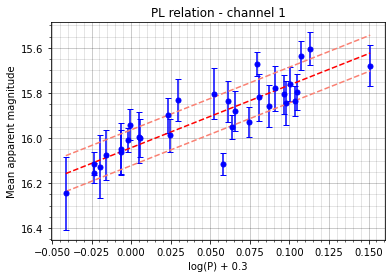

Intercept, a: 16.04
Error in a:    0.01
Std. dev.:     0.08

Distance modulus: 16.44 ± 0.03 (random) ± 0.12 (systematic)
Distance: 19.44 ± 0.30 (random) ± 1.06 (systematic) kpc




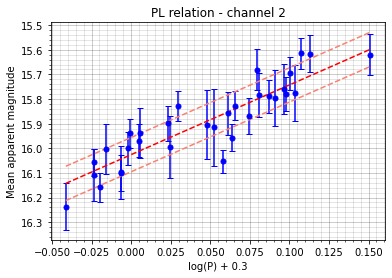

Intercept, a: 16.03
Error in a:    0.01
Std. dev.:     0.07

Distance modulus: 16.44 ± 0.03 (random) ± 0.12 (systematic)
Distance: 19.37 ± 0.29 (random) ± 1.08 (systematic) kpc
No. of ch1 stars used: 32
No. of ch2 stars used: 32


In [17]:
which_photerr = 'hendel'  # final decision: using 'hendel'
which_fiterr = 'std'      # final decision: using 'std'

a_ch1 = -0.40  # Neeley 2019 intercept for absolute mag, M
a_ch2 = -0.41
b_ch1 = -2.78  # Neeley 2019 slope for PL relation
b_ch2 = -2.83

aerr_ch1 = 0.03
aerr_ch2 = 0.03
berr_ch1 = 0.38
berr_ch2 = 0.39
disp_ch1 = 0.21
disp_ch2 = 0.21

def PL_fit_ch1(P, a):  # note this a is DIFFERENT to a_ch1 above; this a is the variable being fit
    return a + b_ch1 * (np.log10(P) + 0.3)
def PL_fit_ch2(P, a):
    return a + b_ch2 * (np.log10(P) + 0.3)


means_ch1 = np.ma.masked_invalid(df_CC['mean_mag_ch1'])
means_ch2 = np.ma.masked_invalid(df_CC['mean_mag_ch2'])
photerr_mean_ch1 = np.ma.masked_array(df_CC['mean_photerr_ch1'], means_ch1.mask)
photerr_mean_ch2 = np.ma.masked_array(df_CC['mean_photerr_ch2'], means_ch2.mask)
photerr_mean_ch1_monson = np.ma.masked_array(df_CC['mean_photerr_mon_ch1'], means_ch1.mask)
photerr_mean_ch2_monson = np.ma.masked_array(df_CC['mean_photerr_mon_ch2'], means_ch2.mask)
photerr_mean_ch1_hendel = np.ma.masked_array(df_CC['mean_photerr_hen_ch1'], means_ch1.mask)
photerr_mean_ch2_hendel = np.ma.masked_array(df_CC['mean_photerr_hen_ch2'], means_ch2.mask)
photerr_amps_ch1 = np.ma.masked_array(df_CC['mean_photerr_amp_ch1'], means_ch1.mask)
photerr_amps_ch2 = np.ma.masked_array(df_CC['mean_photerr_amp_ch2'], means_ch2.mask)
stds_ch1 = np.ma.masked_array(df_CC['mean_std_ch1'], means_ch1.mask)
stds_ch2 = np.ma.masked_array(df_CC['mean_std_ch2'], means_ch2.mask)
A_ch1 = np.ma.masked_array(df_CC['A_ch1'], means_ch1.mask)
A_ch2 = np.ma.masked_array(df_CC['A_ch2'], means_ch2.mask)
periods_ch1 = np.ma.masked_array(df_CC['period_PL'], means_ch1.mask)
periods_ch2 = np.ma.masked_array(df_CC['period_PL'], means_ch2.mask)

if which_fiterr == 'std':
    fiterr_ch1 = stds_ch1
    fiterr_ch2 = stds_ch2
else:
    fiterr_ch1 = photerr_amps_ch1
    fiterr_ch2 = photerr_amps_ch2

if which_photerr == 'monson':
    photerr_ch1 = photerr_mean_ch1_monson
    photerr_ch2 = photerr_mean_ch2_monson
if which_photerr == 'hendel':
    photerr_ch1 = photerr_mean_ch1_hendel
    photerr_ch2 = photerr_mean_ch2_hendel
else:
    photerr_ch1 = photerr_mean_ch1
    photerr_ch2 = photerr_mean_ch2

err_mean_ch1 = np.sqrt(photerr_ch1**2 + fiterr_ch1**2 + A_ch1**2)
err_mean_ch2 = np.sqrt(photerr_ch2**2 + fiterr_ch2**2 + A_ch2**2)

###   CHANNEL 1 PL   ###

popt, pcov = curve_fit(PL_fit_ch1, periods_ch1.compressed(), means_ch1.compressed())
intercept_ch1 = popt[0]
err_int_ch1 = np.sqrt(pcov[0][0])

devs_ch1 = [(m - PL_fit_ch1(p, intercept_ch1))**2 for m, p in zip(means_ch1.compressed(), periods_ch1.compressed())]
std_ch1 = np.sqrt(np.mean(devs_ch1))

plt.errorbar(np.log10(periods_ch1.compressed()) + 0.3, means_ch1.compressed(), yerr=err_mean_ch1.compressed(), fmt='o', color='blue', capsize=3, markersize=5)
plt.plot(np.log10(sorted(periods_ch1.compressed())) + 0.3, PL_fit_ch1(sorted(periods_ch1.compressed()), intercept_ch1), 'r--')
plt.plot(np.log10(sorted(periods_ch1.compressed())) + 0.3, PL_fit_ch1(sorted(periods_ch1.compressed()), intercept_ch1 + std_ch1), c='salmon', ls='--')
plt.plot(np.log10(sorted(periods_ch1.compressed())) + 0.3, PL_fit_ch1(sorted(periods_ch1.compressed()), intercept_ch1 - std_ch1), c='salmon', ls='--')

plt.minorticks_on()
plt.grid(b=True, which='major', lw=.5, alpha=.4, color='black')
plt.grid(b=True, which='minor', lw=.5, alpha=.2, color='black')
plt.gca().invert_yaxis()
plt.xlabel('log(P) + 0.3')
plt.ylabel('Mean apparent magnitude')
plt.title('PL relation - channel 1')
plt.savefig('images/'+cluster+'/PL/PL_ch1.png', dpi=150)
plt.show()
print('Intercept, a: {0:.2f}\nError in a:    {1:.2f}\nStd. dev.:     {2:.2f}\n'.format(intercept_ch1, err_int_ch1, std_ch1))

distmod_ch1 = intercept_ch1 - a_ch1
dist_ch1 = 10 ** ((distmod_ch1 / 5.) + 1.)

distmod_randerr_ch1 = np.sqrt(err_int_ch1**2 + aerr_ch1**2)
dist_randerr_ch1 = abs(dist_ch1) * abs(0.2 * np.log(10.) * distmod_randerr_ch1)

distmod_syserr_ch1 = np.sqrt(aerr_ch1**2 + (0.3**2 * berr_ch1**2))
dist_syserr_ch1 = abs(dist_ch1) * abs(0.2 * np.log(10.) * distmod_syserr_ch1)  # 0.3^2 from PL equation

print('Distance modulus: {0:.2f} ± {1:.2f} (random) ± {2:.2f} (systematic)'.format(distmod_ch1, distmod_randerr_ch1, distmod_syserr_ch1))
print('Distance: {0:.2f} ± {1:.2f} (random) ± {2:.2f} (systematic) kpc\n\n'.format(dist_ch1/1000, dist_randerr_ch1/1000, dist_syserr_ch1/1000))

###   CHANNEL 2 PL   ###

popt, pcov = curve_fit(PL_fit_ch2, periods_ch2.compressed(), means_ch2.compressed())
intercept_ch2 = popt[0]
err_int_ch2 = np.sqrt(pcov[0][0])

devs_ch2 = [(m - PL_fit_ch2(p, intercept_ch2))**2 for m, p in zip(means_ch2.compressed(), periods_ch2.compressed())]
std_ch2 = np.sqrt(np.mean(devs_ch2))

plt.errorbar(np.log10(periods_ch2.compressed()) + 0.3, means_ch2.compressed(), yerr=err_mean_ch2.compressed(), fmt='o', color='blue', capsize=3, markersize=5)
plt.plot(np.log10(sorted(periods_ch2.compressed())) + 0.3, PL_fit_ch2(sorted(periods_ch2.compressed()), intercept_ch2), 'r--')
plt.plot(np.log10(sorted(periods_ch2.compressed())) + 0.3, PL_fit_ch2(sorted(periods_ch2.compressed()), intercept_ch2 + std_ch2), c='salmon', ls='--')
plt.plot(np.log10(sorted(periods_ch2.compressed())) + 0.3, PL_fit_ch2(sorted(periods_ch2.compressed()), intercept_ch2 - std_ch2), c='salmon', ls='--')
plt.minorticks_on()
plt.grid(b=True, which='major', lw=.5, alpha=.4, color='black')
plt.grid(b=True, which='minor', lw=.5, alpha=.2, color='black')
plt.gca().invert_yaxis()
plt.xlabel('log(P) + 0.3')
plt.ylabel('Mean apparent magnitude')
plt.title('PL relation - channel 2')
plt.savefig('images/'+cluster+'/PL/PL_ch2.png', dpi=150)
plt.show()
print('Intercept, a: {0:.2f}\nError in a:    {1:.2f}\nStd. dev.:     {2:.2f}\n'.format(intercept_ch2, err_int_ch2, std_ch2))

distmod_ch2 = intercept_ch2 - a_ch2
dist_ch2 = 10 ** ((distmod_ch2 / 5.) + 1.)

distmod_randerr_ch2 = np.sqrt(err_int_ch2**2 + aerr_ch2**2)
dist_randerr_ch2 = abs(dist_ch2) * abs(0.2 * np.log(10.) * distmod_randerr_ch2)

distmod_syserr_ch2 = np.sqrt(aerr_ch2**2 + (0.3**2 * berr_ch2**2))
dist_syserr_ch2 = abs(dist_ch2) * abs(0.2 * np.log(10.) * distmod_syserr_ch2)  # 0.3^2 from PL equation

print('Distance modulus: {0:.2f} ± {1:.2f} (random) ± {2:.2f} (systematic)'.format(distmod_ch2, distmod_randerr_ch2, distmod_syserr_ch2))
print('Distance: {0:.2f} ± {1:.2f} (random) ± {2:.2f} (systematic) kpc'.format(dist_ch2/1000, dist_randerr_ch2/1000, dist_syserr_ch2/1000))

print('No. of ch1 stars used:', len(means_ch1.compressed()))
print('No. of ch2 stars used:', len(means_ch2.compressed()))

In [18]:
df_CC

ID            RA           dec units  period  mean_mag_CC  amplitude  \
0     1  15h00m53.07s  -82d12m49.8s    R0  0.6099       17.612       0.74   
1     2  15h00m34.18s  -82d14m25.0s    R0  0.4936       17.670       1.21   
2     3  14h59m28.92s  -82d14m39.6s    R0  0.4832       17.697       1.21   
3     4  14h59m54.70s  -82d12m38.1s    R0  0.6236       17.676       0.80   
4     5  14h59m54.37s  -82d13m39.7s    R0  0.5569       17.656       1.11   
..  ...           ...           ...   ...     ...          ...        ...   
93  112  14h59m55.31s  -82d11m50.3s    R0  0.6113       17.717       0.44   
94  153  14h59m10.31s  -82d15m46.8s    R0  0.2851       17.678       0.31   
95  167  15h00m26.10s  -82d12m35.0s    R0  0.7067       17.524       0.56   
96  171  15h00m42.31s  -82d13m45.2s    R0  0.2797       17.666       0.22   
97  173  14h59m09.00s  -82d11m11.3s    R0  0.3607       14.200        NaN   

   colour type  id_new  ...  mean_photerr_amp_ch2  mean_photerr_mon_ch1  \
0       V  RR0       0  ...                   NaN                   NaN   
1       V  RR0       1  ...              0.017552              0.015702   
2       V  RR0       2  ...              0.024977              0.011315   
3       V  RR0       3  ...                   NaN                   NaN   
4       V  RR0       4  ...                   NaN                   NaN   
..    ...  ...     ...  ...                   ...                   ...   
93      V  RR0      93  ...                   NaN                   NaN   
94      V  RR2      94  ...                   NaN                   NaN   
95      V  RR0      95  ...                   NaN                   NaN   
96      V  RR2      96  ...                   NaN                   NaN   
97      V  RR1      97  ...                   NaN                   NaN   

    mean_photerr_mon_ch2  mean_photerr_hen_ch1  mean_photerr_hen_ch2  \
0                    NaN                   NaN                   NaN   
1               0.017038              0.016066              0.017793   
2               0.012151              0.011382              0.012224   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
..                   ...                   ...                   ...   
93                   NaN                   NaN                   NaN   
94                   NaN                   NaN                   NaN   
95                   NaN                   NaN                   NaN   
96                   NaN                   NaN                   NaN   
97                   NaN                   NaN                   NaN   

    period_PL  A_ch1  A_ch2   amp_ch1   amp_ch2  
0         NaN    NaN    NaN       NaN       NaN  
1    0.493600  0.039  0.033  0.264692  0.201659  
2    0.483200  0.040  0.033  0.325371  0.273611  
3         NaN    NaN    NaN       NaN       NaN  
4         NaN    NaN    NaN       NaN       NaN  
..        ...    ...    ...       ...       ...  
93        NaN    NaN    NaN       NaN       NaN  
94        NaN    NaN    NaN       NaN       NaN  
95        NaN    NaN    NaN       NaN       NaN  
96        NaN    NaN    NaN       NaN       NaN  
97   0.483221  0.040  0.033       NaN       NaN  

[98 rows x 27 columns]

In [15]:
print(means_ch1.argmax())
print(means_ch2.argmax())

print(means_ch1)
print(means_ch2)

21
19
[-- 16.062549046114 16.07514475715958 -- -- -- 15.7801954817224 --
 15.679308001507556 -- 15.761648965163737 15.928938471000391 -- -- --
 15.837110240504098 -- -- 15.987823548500344 15.81736728537804 --
 16.45552946130165 15.999854031494975 -- 15.67024307628635 --
 15.99737901538643 -- -- 15.898605252823803 -- -- -- 16.049486433483978
 15.604707889222606 -- 15.859879574307694 -- 15.830914024157257 -- -- --
 -- -- 15.880644667004951 -- 16.00928849310882 15.803672489732563 --
 15.951438296780513 15.819271321621434 -- -- -- -- 15.940986078869626 --
 -- -- -- 15.835330861876374 -- 15.806821181066642 16.246031686418394 --
 -- -- -- -- 15.79539268398306 16.114394912989045 -- -- -- -- -- -- -- --
 16.115466633272938 -- -- 16.15673790440372 -- -- -- -- -- --
 15.844792548093572 15.635446237264775 -- 16.127293308584097 -- -- -- --
 --]
[-- 16.102004469319123 16.00364754953156 -- -- -- 15.796539034375428 --
 15.620809612011106 -- 15.696069420554766 15.869718209551584 -- -- --
 15.857930773

In [16]:
t_CC = Table.from_pandas(df_CC)
#t_CC.sort('mean_mag_ch1')

checkthesebright = []
checkthesedim = []
for i in range(len(t_CC)):
    if t_CC['mean_mag_ch1'][i] < 15.4:
        checkthesebright.append(t_CC['id_new'][i])
    if t_CC['mean_mag_ch1'][i] > 16.4 or t_CC['mean_mag_ch2'][i] > 16.4:
        checkthesedim.append(t_CC['id_new'][i])

print(checkthesebright)
print(checkthesedim)
t_CC.show_in_notebook()

[]
[19, 21]


In [14]:
gaia_IC = 'data/reference/ic4499-gaia-variables-10arcmin-v2.csv'
gaia_tbl = Table.read(gaia_IC, format='ascii.csv')

gaia_tbl['parallax_rel_err'] = float('NaN')
median_list = []

for i in range(len(gaia_tbl)):
    gaia_tbl['parallax_rel_err'][i] = abs(gaia_tbl['parallax_error'][i] / gaia_tbl['parallax'][i])
    median_list.append(gaia_tbl['parallax_rel_err'][i])

median_list.extend([2.73,1.96,0.895,0.796,1.41,0.645,0.741,0.485,0.333,1.61,1.92])

print(median_list)
print(np.median(median_list))
#gaia_tbl

[2.278789312116506, 0.9091108846027731, 1.5540529219427897, 6.209253960797463, 4.7032238718244415, 0.9515346347881769, 6.162451969212462, 4.2185868723764814, 0.3063363013623922, 0.45568590614688353, 0.2986188300588987, 1.457918106730581, 0.3422865942292731, 1.8283984891878358, 1.4217443660772904, 0.8749722411202576, 8.24750358002625, 0.5588266206021657, 0.07799153713598596, 2.711948548420205, 0.36380072537664243, 48.65614447700243, 1.0008773548699628, 1.3938467123857807, 0.6172817133776395, 22.67344101922174, 0.803250992229518, 1.2363354904956863, 3.101856594415879, 1.2111946427612652, 20.588522666771706, 1.1624494933812468, 0.4232835764912002, 0.23121773401224216, 0.4599722162541289, 1.6240916175543667, 0.7091326532052876, 0.7795146342546386, 1.2814419981428018, 0.36543259263909733, 0.5190017131020243, 0.43376724448095144, 3.565615661238083, 1.920585712864627, 0.6100323060948434, 2.4446336062204566, 1.2701827046507799, 390.56745171864037, 1.4450912514459795, 1.814529077983207, 0.40192

### Plotting PL relation (weighted fit):
Note: star in both channels on right of PL is RRL5 (RRab) - very close to another mahoosive bright star, hence the massive error bars

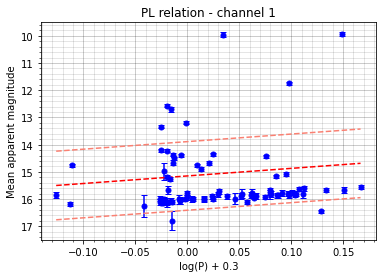

Intercept, a: 15.15
Error in a:    0.15
Std. dev.:     1.26

Distance modulus: 15.55 ± 0.15 (random) ± 0.12 (systematic)
Distance: 12.88 ± 0.90 (random) ± 0.70 (systematic) kpc




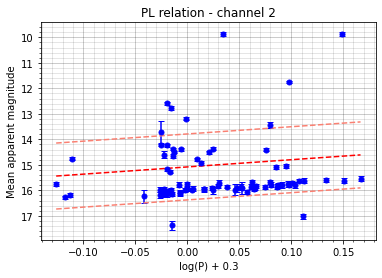

Intercept, a: 15.08
Error in a:    0.15
Std. dev.:     1.29

Distance modulus: 15.49 ± 0.15 (random) ± 0.12 (systematic)
Distance: 12.55 ± 0.88 (random) ± 0.70 (systematic) kpc


In [15]:
a_ch1 = -0.40  # Neeley 2019 intercept for absolute mag, M
a_ch2 = -0.41
b_ch1 = -2.78  # Neeley 2019 slope for PL relation
b_ch2 = -2.83

aerr_ch1 = 0.03
aerr_ch2 = 0.03
berr_ch1 = 0.38
berr_ch2 = 0.39
disp_ch1 = 0.21
disp_ch2 = 0.21

def PL_fit_ch1(P, a):  # note this a is DIFFERENT to a_ch1 above; this a is the variable being fit
    return a + b_ch1 * (np.log10(P) + 0.3)
def PL_fit_ch2(P, a):
    return a + b_ch2 * (np.log10(P) + 0.3)


means_ch1 = np.ma.masked_invalid(means_ch1)
means_ch2 = np.ma.masked_invalid(means_ch2)
photerr_mean_ch1 = np.ma.masked_array(photerr_mean_ch1, means_ch1.mask)
photerr_mean_ch2 = np.ma.masked_array(photerr_mean_ch2, means_ch2.mask)
stds_ch1 = np.ma.masked_array(stds_ch1, means_ch1.mask)
stds_ch2 = np.ma.masked_array(stds_ch2, means_ch2.mask)
A_ch1 = np.ma.masked_array(A_ch1, means_ch1.mask)
A_ch2 = np.ma.masked_array(A_ch2, means_ch2.mask)
periods_ch1 = np.ma.masked_array(periods_PL, means_ch1.mask)
periods_ch2 = np.ma.masked_array(periods_PL, means_ch2.mask)

err_mean_ch1 = np.sqrt(photerr_mean_ch1**2 + stds_ch1**2 + A_ch1**2)
err_mean_ch2 = np.sqrt(photerr_mean_ch2**2 + stds_ch2**2 + A_ch2**2)

###   CHANNEL 1 PL   ###

#popt, pcov = curve_fit(PL_fit_ch1, periods_ch1.compressed(), means_ch1.compressed())
popt, pcov = curve_fit(PL_fit_ch1, periods_ch1.compressed(), means_ch1.compressed(), sigma=err_mean_ch1.compressed())
intercept_ch1 = popt[0]
err_int_ch1 = np.sqrt(pcov[0][0])

devs_ch1 = [(m - PL_fit_ch1(p, intercept_ch1))**2 for m, p in zip(means_ch1.compressed(), periods_ch1.compressed())]
std_ch1 = np.sqrt(np.mean(devs_ch1))

plt.errorbar(np.log10(periods_ch1.compressed()) + 0.3, means_ch1.compressed(), yerr=err_mean_ch1.compressed(), fmt='o', color='blue', capsize=3, markersize=5)
plt.plot(np.log10(sorted(periods_ch1.compressed())) + 0.3, PL_fit_ch1(sorted(periods_ch1.compressed()), intercept_ch1), 'r--')
plt.plot(np.log10(sorted(periods_ch1.compressed())) + 0.3, PL_fit_ch1(sorted(periods_ch1.compressed()), intercept_ch1 + std_ch1), c='salmon', ls='--')
plt.plot(np.log10(sorted(periods_ch1.compressed())) + 0.3, PL_fit_ch1(sorted(periods_ch1.compressed()), intercept_ch1 - std_ch1), c='salmon', ls='--')

plt.minorticks_on()
plt.grid(b=True, which='major', lw=.5, alpha=.4, color='black')
plt.grid(b=True, which='minor', lw=.5, alpha=.2, color='black')
plt.gca().invert_yaxis()
plt.xlabel('log(P) + 0.3')
plt.ylabel('Mean apparent magnitude')
plt.title('PL relation - channel 1')
plt.show()
print('Intercept, a: {0:.2f}\nError in a:    {1:.2f}\nStd. dev.:     {2:.2f}\n'.format(intercept_ch1, err_int_ch1, std_ch1))

distmod_ch1 = intercept_ch1 - a_ch1
dist_ch1 = 10 ** ((distmod_ch1 / 5.) + 1.)

distmod_randerr_ch1 = np.sqrt(err_int_ch1**2 + aerr_ch1**2)
dist_randerr_ch1 = abs(dist_ch1) * abs(0.2 * np.log(10.) * distmod_randerr_ch1)

distmod_syserr_ch1 = np.sqrt(aerr_ch1**2 + (0.3**2 * berr_ch1**2))
dist_syserr_ch1 = abs(dist_ch1) * abs(0.2 * np.log(10.) * distmod_syserr_ch1)  # 0.3^2 from PL equation

print('Distance modulus: {0:.2f} ± {1:.2f} (random) ± {2:.2f} (systematic)'.format(distmod_ch1, distmod_randerr_ch1, distmod_syserr_ch1))
print('Distance: {0:.2f} ± {1:.2f} (random) ± {2:.2f} (systematic) kpc\n\n'.format(dist_ch1/1000, dist_randerr_ch1/1000, dist_syserr_ch1/1000))

###   CHANNEL 2 PL   ###

#popt, pcov = curve_fit(PL_fit_ch2, periods_ch2.compressed(), means_ch2.compressed())
popt, pcov = curve_fit(PL_fit_ch2, periods_ch2.compressed(), means_ch2.compressed(), sigma=err_mean_ch2.compressed())
intercept_ch2 = popt[0]
err_int_ch2 = np.sqrt(pcov[0][0])

devs_ch2 = [(m - PL_fit_ch2(p, intercept_ch2))**2 for m, p in zip(means_ch2.compressed(), periods_ch2.compressed())]
std_ch2 = np.sqrt(np.mean(devs_ch2))

plt.errorbar(np.log10(periods_ch2.compressed()) + 0.3, means_ch2.compressed(), yerr=err_mean_ch2.compressed(), fmt='o', color='blue', capsize=3, markersize=5)
plt.plot(np.log10(sorted(periods_ch2.compressed())) + 0.3, PL_fit_ch2(sorted(periods_ch2.compressed()), intercept_ch2), 'r--')
plt.plot(np.log10(sorted(periods_ch2.compressed())) + 0.3, PL_fit_ch2(sorted(periods_ch2.compressed()), intercept_ch2 + std_ch2), c='salmon', ls='--')
plt.plot(np.log10(sorted(periods_ch2.compressed())) + 0.3, PL_fit_ch2(sorted(periods_ch2.compressed()), intercept_ch2 - std_ch2), c='salmon', ls='--')
plt.minorticks_on()
plt.grid(b=True, which='major', lw=.5, alpha=.4, color='black')
plt.grid(b=True, which='minor', lw=.5, alpha=.2, color='black')
plt.gca().invert_yaxis()
plt.xlabel('log(P) + 0.3')
plt.ylabel('Mean apparent magnitude')
plt.title('PL relation - channel 2')
plt.show()
print('Intercept, a: {0:.2f}\nError in a:    {1:.2f}\nStd. dev.:     {2:.2f}\n'.format(intercept_ch2, err_int_ch2, std_ch2))

distmod_ch2 = intercept_ch2 - a_ch2
dist_ch2 = 10 ** ((distmod_ch2 / 5.) + 1.)

distmod_randerr_ch2 = np.sqrt(err_int_ch2**2 + aerr_ch2**2)
dist_randerr_ch2 = abs(dist_ch2) * abs(0.2 * np.log(10.) * distmod_randerr_ch2)

distmod_syserr_ch2 = np.sqrt(aerr_ch2**2 + (0.3**2 * berr_ch2**2))
dist_syserr_ch2 = abs(dist_ch2) * abs(0.2 * np.log(10.) * distmod_syserr_ch2)  # 0.3^2 from PL equation

print('Distance modulus: {0:.2f} ± {1:.2f} (random) ± {2:.2f} (systematic)'.format(distmod_ch2, distmod_randerr_ch2, distmod_syserr_ch2))
print('Distance: {0:.2f} ± {1:.2f} (random) ± {2:.2f} (systematic) kpc'.format(dist_ch2/1000, dist_randerr_ch2/1000, dist_syserr_ch2/1000))



Star in forbidden zone (or isnt RRab/RRc)

RRab
Channel 1 mags:  [15.88541167 16.05769977 16.07177089 16.09764974 16.18633865 16.2814333
 16.22701549 15.94814217 16.00825338 16.09921674 16.08682154 16.1001556 ]
Channel 2 mags:  [16.06883936 99.         15.99904832 16.26282197 16.15486921 16.08615357
 16.28201236 16.19239225 16.10889582 16.11827646 16.05145948 15.97921278] 

RRL2 ---- Period = 0.4936 days
------------------------------------------------------
12 11


C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 16.102    std dev = 0.086     amplitude = 0.265


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 16.135    std dev = 0.062     amplitude = 0.202
Channels don't have the same number of measurements, so colour curve couldn't be plotted


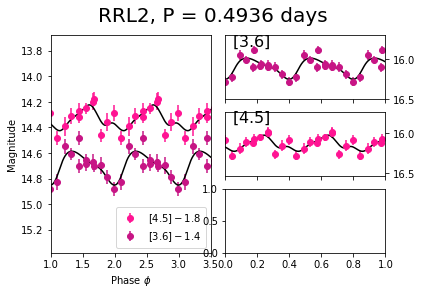

[nan, 0.02205767930696941]
new error ch1: 0.02205767930696941
new error ch2: 0.017552141856224394



RRab
Channel 1 mags:  [16.08996703 16.11011432 16.33861892 16.30359418 16.33947924 15.97145306
 15.9829214  15.99151626 16.08253132 99.         16.0945453  16.13183081]
Channel 2 mags:  [16.02047438 99.         16.08872279 16.16113679 16.1840448  15.97889293
 15.8823258  15.92557494 99.         15.99926547 16.14238768 16.18593872] 

RRL3 ---- Period = 0.4832 days
------------------------------------------------------
11 10


C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 16.115    std dev = 0.104     amplitude = 0.325


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 16.037    std dev = 0.096     amplitude = 0.274
Channels don't have the same number of measurements, so colour curve couldn't be plotted


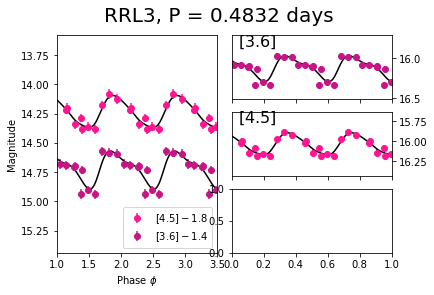

[nan, 0.02205767930696941, 0.028319874287772044]
new error ch1: 0.028319874287772044
new error ch2: 0.02497713111702254




Star in forbidden zone (or isnt RRab/RRc)


Star in forbidden zone (or isnt RRab/RRc)


Star in forbidden zone (or isnt RRab/RRc)

RRab
Channel 1 mags:  [15.95559097 15.67021373 16.01646958 15.93302003 15.9874559  15.64174126
 15.74567976 15.63849563 15.7897407  15.62167335 15.93015702 16.0707946 ]
Channel 2 mags:  [99.         99.         99.         99.         99.         99.
 15.7905455  15.7526059  99.         15.63992023 15.79764138 99.        ] 

RRL7 ---- Period = 0.6179 days
------------------------------------------------------
12 4


C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 15.820    std dev = 0.092     amplitude = 0.256
<[4.5]> = 15.830    std dev = 0.107     amplitude = 0.354
Channels don't have the same number of measurements, so colour curve couldn't be plotted


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


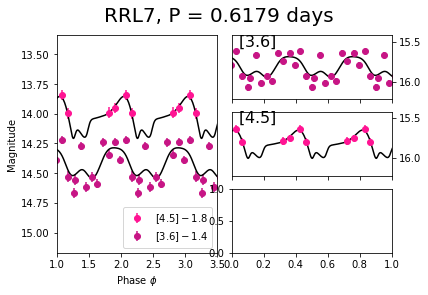

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446]
new error ch1: 0.021307906023734446
new error ch2: 0.05103889015521645



RRd
Channel 1 mags:  [15.82198823 15.90844379 15.89425384 16.00879137 99.         15.75326828
 15.97606081 16.97941237 15.89399337 15.8373441  16.56847136 15.96217553]
Channel 2 mags:  [15.78724102 15.91587326 15.87244284 15.93898533 15.88031125 15.73124514
 15.68397305 15.7341828  15.77993107 15.90538342 99.         15.78170217] 

RRL8 ---- Period = 0.3674 days
------------------------------------------------------
11 11


C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 16.053    std dev = 0.163     amplitude = 0.480
<[4.5]> = 15.816    std dev = 0.075     amplitude = 0.219

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



<[3.6] - [4.5]> = 0.237    std dev = 0.158     amplitude = 0.540


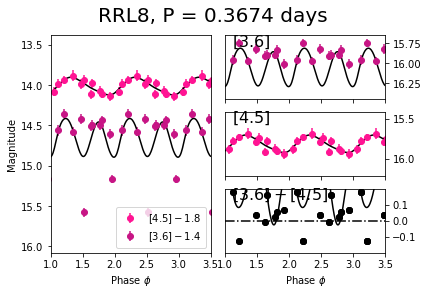

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088]
new error ch1: 0.04178438451200088
new error ch2: 0.019073310143958175



RRab
Channel 1 mags:  [15.90919773 15.83086191 15.86801284 15.71206129 15.74244345 15.65133956
 15.54932481 15.69675432 15.71818672 15.64519707 15.59478953 15.71694141]
Channel 2 mags:  [15.84789418 15.74419376 15.67793867 15.66355599 15.63420794 15.50785011
 15.55968517 15.53462327 15.64589698 15.61612879 15.70828673 15.62401232] 

RRL9 ---- Period = 0.7096 days
------------------------------------------------------
12 12
<[3.6]> = 15.718    std dev = 0.080     amplitude = 0.236
<[4.5]> = 15.654    std dev = 0.075     amplitude = 0.236


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[3.6] - [4.5]> = 0.064    std dev = 0.034     amplitude = 0.108


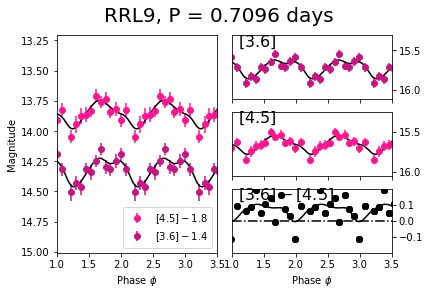

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741]
new error ch1: 0.0196692504600741
new error ch2: 0.019705055925177756




Star in forbidden zone (or isnt RRab/RRc)

RRab
Channel 1 mags:  [15.75817388 15.72535474 15.73864063 15.80943113 15.85092704 15.89813438
 15.87847135 15.90463321 15.84941483 15.7598148  15.731949   15.68129407]
Channel 2 mags:  [15.69420247 15.60498307 15.72668309 15.64916908 15.77147605 15.85691876
 15.81121888 15.79176175 15.73427925 15.7175583  15.68787449 15.65678855] 

RRL11 ---- Period = 0.6315 days
------------------------------------------------------
12 12
<[3.6]> = 15.801    std dev = 0.064     amplitude = 0.175
<[4.5]> = 15.728    std dev = 0.057     amplitude = 0.166


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[3.6] - [4.5]> = 0.073    std dev = 0.016     amplitude = 0.052


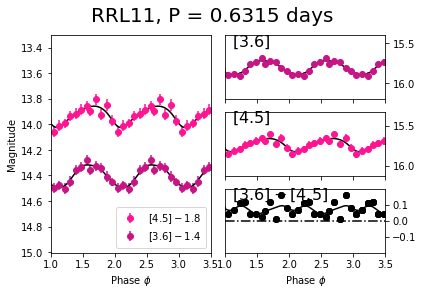

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329]
new error ch1: 0.014595259382162329
new error ch2: 0.01382719556600446



RRab
Channel 1 mags:  [15.97034625 15.95621248 15.98723901 15.91155494 15.93471648 15.94618696
 15.84159963 15.98726273 16.01211639 16.14925145 15.98975872 15.91862064]
Channel 2 mags:  [15.90879524 15.94323608 15.89020614 15.89099223 15.72446898 15.82921832
 15.86021582 15.91187948 16.00208338 15.9547324  16.00025816 15.97872521] 

RRL12 ---- Period = 0.5948 days
------------------------------------------------------
12 12
<[3.6]> = 15.968    std dev = 0.052     amplitude = 0.173


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.903    std dev = 0.065     amplitude = 0.191
<[3.6] - [4.5]> = 0.065    std dev = 0.036     amplitude = 0.123


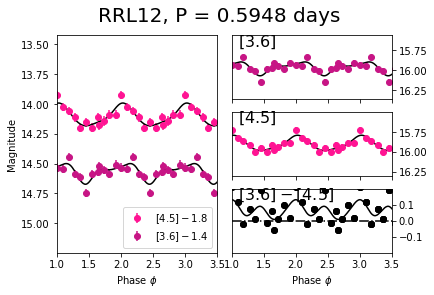

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757]
new error ch1: 0.014451822395278757
new error ch2: 0.01591443826410292




Star in forbidden zone (or isnt RRab/RRc)


Star in forbidden zone (or isnt RRab/RRc)


Star in forbidden zone (or isnt RRab/RRc)

RRab
Channel 1 mags:  [15.77053705 15.7674642  15.93960602 15.93376283 15.8298617  15.95564944
 16.01310218 15.98082186 15.86551851 15.79486066 15.7203626  15.80394838]
Channel 2 mags:  [15.77987166 15.78652817 15.84657042 15.86402428 15.94194193 15.98751186
 16.02012993 15.97123529 15.90302303 15.86030602 15.83476132 15.77183569] 

RRL16 ---- Period = 0.5773 days
------------------------------------------------------
12 12
<[3.6]> = 15.877    std dev = 0.078     amplitude = 0.242


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.891    std dev = 0.077     amplitude = 0.221
<[3.6] - [4.5]> = -0.014    std dev = 0.039     amplitude = 0.131


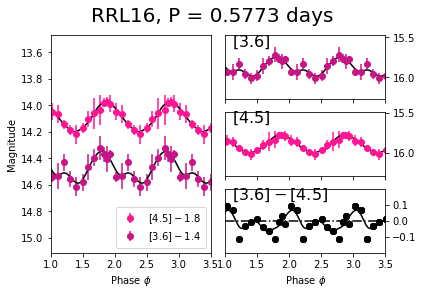

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957]
new error ch1: 0.02016614829715957
new error ch2: 0.01840078415101794




Star in forbidden zone (or isnt RRab/RRc)


Star in forbidden zone (or isnt RRab/RRc)

RRab
Channel 1 mags:  [16.28592702 16.11200813 15.99539348 15.99243616 15.89638505 16.02035399
 15.97722936 16.0586189  16.09434212 15.91782652 16.20195101 15.9586876 ]
Channel 2 mags:  [16.25743206 16.23255992 16.19655849 15.98278664 15.94133423 15.86636645
 15.87186192 16.0420035  15.94753548 15.96033159 16.24355203 16.20032595] 

RRL19 ---- Period = 0.5306 days
------------------------------------------------------
12 12
<[3.6]> = 16.028    std dev = 0.060     amplitude = 0.191


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 16.029    std dev = 0.120     amplitude = 0.358
<[3.6] - [4.5]> = -0.001    std dev = 0.096     amplitude = 0.285


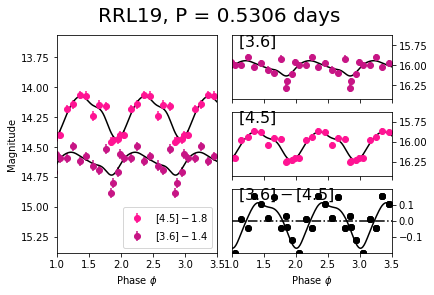

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, nan, 0.015935665113477143]
new error ch1: 0.015935665113477143
new error ch2: 0.02979787873573425



RRab
Channel 1 mags:  [15.76265842 15.84605193 15.68654859 15.76859427 15.65332493 15.87566882
 15.75941451 15.95880647 16.13019289 15.97649264 15.98498934 15.97177793]
Channel 2 mags:  [17.20397359 16.9963746  17.21233183 17.01461615 17.01134934 17.10038591
 16.98383462 17.11023256 16.90226702 17.0363812  16.96471578 17.19546   ] 

RRL20 ---- Period = 0.6482 days
------------------------------------------------------
12 12
<[3.6]> = 15.857    std dev = 0.116     amplitude = 0.333


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 17.055    std dev = 0.042     amplitude = 0.144
<[3.6] - [4.5]> = -1.198    std dev = 0.140     amplitude = 0.396


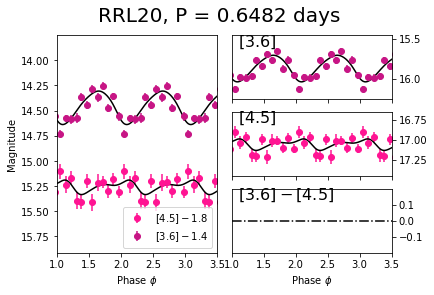

RRd
Channel 1 mags:  [16.02175483 16.15185426 16.23075773 16.31684879 16.14484101 16.13918879
 16.03642926 16.20688523 16.1260963  16.13222399 16.12050561 16.19629984]
Channel 2 mags:  [16.2256924  16.16353843 16.12564975 16.05284932 16.082998   16.05311107
 16.01030431 16.08816214 15.9611192  16.03224731 16.11163984 16.17860122] 

RRL21 ---- Period = 0.3533 days
------------------------------------------------------
12 12
<[3.6]> = 16.142    std dev = 0.046     amplitude = 0.148


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 16.085    std dev = 0.022     amplitude = 0.070
<[3.6] - [4.5]> = 0.057    std dev = 0.059     amplitude = 0.188


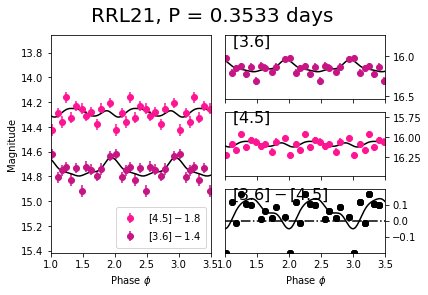

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, nan, 0.015935665113477143, nan, 0.012358852875342366]
new error ch1: 0.012358852875342366
new error ch2: 0.005847356093989416



RRab
Channel 1 mags:  [16.45002514 16.46959824 16.5568807  16.50527014 16.46246809 16.53885453
 16.43709203 16.48629472 16.462642   16.36308576 16.54256596 16.65217959]
Channel 2 mags:  [] 

RRL22 ---- Period = 0.6747 days
------------------------------------------------------
12 0


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[3.6]> = 16.495    std dev = 0.033     amplitude = 0.123
Channels don't have the same number of measurements, so colour curve couldn't be plotted


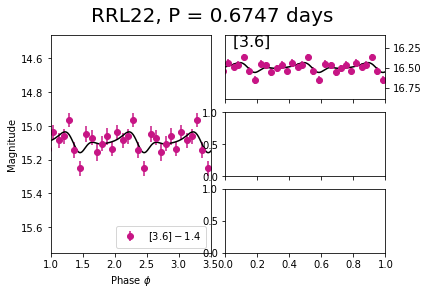

RRab
Channel 1 mags:  [16.17617653 16.14464581 16.08683989 15.95471747 15.91349249 16.0009054
 15.92318156 16.0817096  16.10294641 16.04404961 16.14824257 16.10517928]
Channel 2 mags:  [16.06883456 16.16183955 15.92836989 15.78866142 15.91900852 15.89024843
 15.87562451 15.8894838  16.05359232 16.12969128 16.14605557 16.06212166] 

RRL23 ---- Period = 0.5077 days
------------------------------------------------------
12 12
<[3.6]> = 16.039    std dev = 0.072     amplitude = 0.202
<[4.5]> = 15.969    std dev = 0.097     amplitude = 0.266

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



<[3.6] - [4.5]> = 0.069    std dev = 0.034     amplitude = 0.110


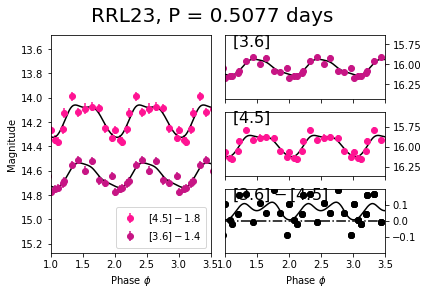

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, nan, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719]
new error ch1: 0.01684938417110719
new error ch2: 0.022165795155387524




Star in forbidden zone (or isnt RRab/RRc)

RRab
Channel 1 mags:  [99.         15.69962267 15.74928898 15.66606431 99.         15.63511391
 15.73881422 15.63284513 15.76485288 15.77880757 15.62817766 15.85986978]
Channel 2 mags:  [15.83536925 15.92512779 15.70846746 15.63030661 15.64733412 15.61779887
 15.62536458 15.69908229 15.67434028 15.74049154 15.75355783 15.83573223] 

RRL25 ---- Period = 0.6022 days
------------------------------------------------------
10 12
<[3.6]> = 15.710    std dev = 0.033     amplitude = 0.103


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.714    std dev = 0.076     amplitude = 0.225
Channels don't have the same number of measurements, so colour curve couldn't be plotted


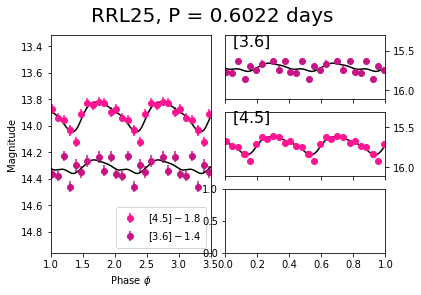

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, nan, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076]
new error ch1: 0.009366173836899076
new error ch2: 0.018726279838450804



RRab
Channel 1 mags:  []
Channel 2 mags:  [] 

RRab
Channel 1 mags:  [15.95387412 15.98772608 15.9083224  15.96346818 15.91580267 15.99468315
 16.18493836 16.25093491 16.24635668 15.89840978 15.95293189 16.00145894]
Channel 2 mags:  [15.94410141 16.01662856 15.99125039 15.98910978 15.95392355 15.96398587
 15.93084424 16.10884465 16.19582228 16.02511219 15.98065287 15.89302687] 

RRL27 ---- Period = 0.5068 days
------------------------------------------------------
12 12
<[3.6]> = 16.036    std dev = 0.107     amplitude = 0.305


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 16.002    std dev = 0.057     amplitude = 0.174
<[3.6] - [4.5]> = 0.034    std dev = 0.075     amplitude = 0.228


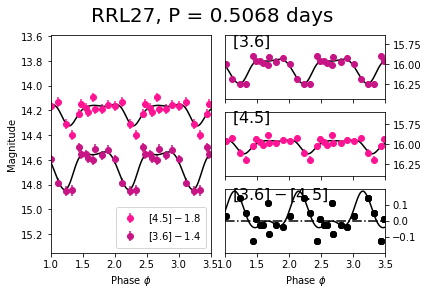

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, nan, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902]
new error ch1: 0.02541749839552902
new error ch2: 0.014474421280207187




Star in forbidden zone (or isnt RRab/RRc)


Star in forbidden zone (or isnt RRab/RRc)

RRab
Channel 1 mags:  [15.97025726 15.95140177 16.04741672 16.15890477 15.92648448 15.86141791
 15.82823838 15.89946849 15.96382094 15.85076061 15.94037749 15.92628286]
Channel 2 mags:  [15.90692868 15.93870751 15.95557797 16.03397121 16.07360269 15.75089831
 15.82013524 15.94265569 15.93733676 99.         15.91880692 15.99558284] 

RRL30 ---- Period = 0.5289 days
------------------------------------------------------
12 11


C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 15.938    std dev = 0.066     amplitude = 0.218


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.930    std dev = 0.061     amplitude = 0.220
Channels don't have the same number of measurements, so colour curve couldn't be plotted


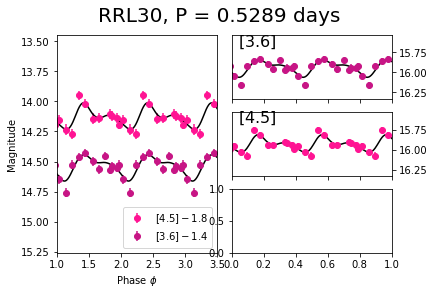

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, nan, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218]
new error ch1: 0.01819808922893218
new error ch2: 0.019174929170803608




Star in forbidden zone (or isnt RRab/RRc)


Star in forbidden zone (or isnt RRab/RRc)

RRab
Channel 1 mags:  []
Channel 2 mags:  [] 

RRab
Channel 1 mags:  [15.97988845 16.15073737 16.29583087 16.1781573  16.35742392 16.1205889
 16.02761412 15.94190527 15.91750876 16.1301271  15.94594196 16.06103249]
Channel 2 mags:  [16.06109544 16.12353543 16.1396938  16.3240075  16.3469577  16.17813223
 15.97557952 16.00623463 16.03918909 16.15013134 16.08228352 16.04245704] 

RRL34 ---- Period = 0.4936 days
--------------------------------------------

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 16.130    std dev = 0.102     amplitude = 0.334
<[3.6] - [4.5]> = -0.041    std dev = 0.031     amplitude = 0.104


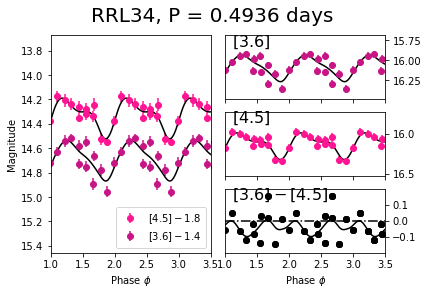

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, nan, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106]
new error ch1: 0.02764399924573106
new error ch2: 0.027818886560578477



RRab
Channel 1 mags:  [15.66933892 15.57136231 99.         15.65802211 99.         15.72534349
 15.77764695 99.         15.61772908 15.62697717 15.48417989 15.5812578 ]
Channel 2 mags:  [15.61068108 15.52381405 15.63823519 15.61255174 15.6955665  15.77290169
 15.74389445 15.76316602 15.65253768 15.57023174 15.56244993 15.61898462] 

RRL35 ---- Period = 0.6498 days
------------------------------------------------------
9 12


C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 15.644    std dev = 0.061     amplitude = 0.195


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.648    std dev = 0.066     amplitude = 0.182
Channels don't have the same number of measurements, so colour curve couldn't be plotted


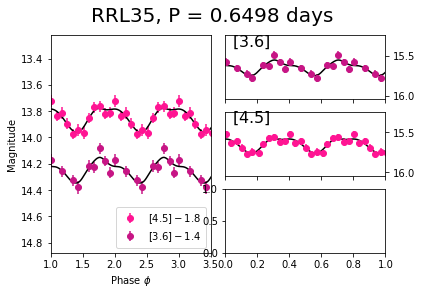

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, nan, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126]
new error ch1: 0.01871798176793126
new error ch2: 0.015188076796218475




Star in forbidden zone (or isnt RRab/RRc)

RRab
Channel 1 mags:  [15.83111498 15.85749669 15.98519357 16.00203594 15.97752274 16.05446752
 15.95251833 15.86777475 15.8006041  15.77401312 15.82193415 15.80843883]
Channel 2 mags:  [15.80789687 15.83681441 15.83849566 15.86223482 15.8606728  16.02256729
 15.80072402 15.81978603 15.76254367 15.71528749 15.74364861 15.77121519] 

RRL37 ---- Period = 0.6123 days
------------------------------------------------------
12 12
<[3.6]> = 15.900

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[3.6] - [4.5]> = 0.078    std dev = 0.029     amplitude = 0.091


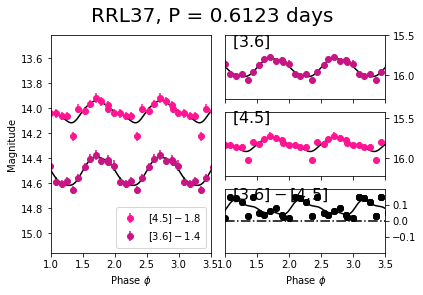

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, nan, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126, nan, 0.018725618383013416]
new error ch1: 0.018725618383013416
new error ch2: 0.014858072864653534



RRab
Channel 1 mags:  []
Channel 2 mags:  [] 

RRab
Channel 1 mags:  [15.8317743  15.80978728 15.83315739 15.72685108 15.82916105 15.88124492
 15.91467411 16.0590859  16.04551271 15.82443524 15.74608172 15.8092162 ]
Channel 2 mags:  [15.72321813 15.80821513 15.78055972 15.85148049 15.81911963 15.84310356
 15.86432647 15.89229625 16.02168334 15.97337878 15.8064542  15.87523304] 

RRL39 ---- Period = 0.5365 days
----------------------------------------------

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.862    std dev = 0.052     amplitude = 0.163
<[3.6] - [4.5]> = 0.009    std dev = 0.046     amplitude = 0.145


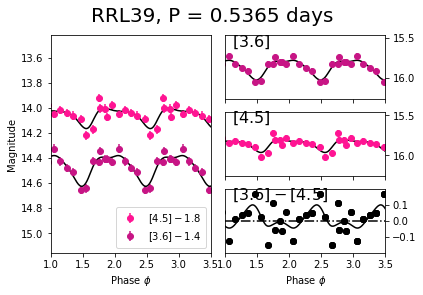

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, nan, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126, nan, 0.018725618383013416, nan, 0.020445225143792545]
new error ch1: 0.020445225143792545
new error ch2: 0.013573617713134775



RRd
Channel 1 mags:  [17.24771252 17.33637531 99.         99.         99.         16.53051947
 16.38332599 17.51542768 99.         16.42704945 99.         17.36206515]
Channel 2 mags:  [99.         17.55785941 99.         17.38240483 17.38743916 99.
 99.         17.42593525 99.         99.         99.         99.        ] 

RRL40 ---- Period = 0.3615 days
------------------------------------------------------
7 4


C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[3.6]> = 16.831    std dev = 0.332     amplitude = 1.029
<[4.5]> = 17.405    std dev = 0.032     amplitude = 0.133
Channels don't have the same number of measurements, so colour curve couldn't be plotted


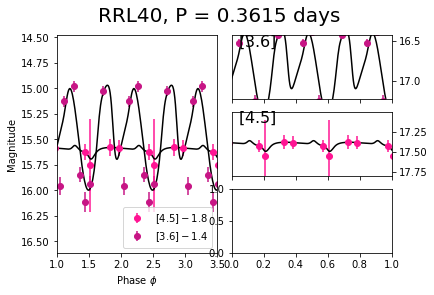

RRab
Channel 1 mags:  []
Channel 2 mags:  [] 

RRab
Channel 1 mags:  [14.70788894 14.81568745 14.76411963 14.68279937 14.78648506 14.65489477
 14.74636727 14.69054285 14.73948173 14.70929989 14.77927021 14.74152668]
Channel 2 mags:  [14.57470855 14.50099609 14.50142862 14.52531272 14.53975509 14.58148106
 14.53323711 14.58077105 14.57226101 14.56830434 14.51183585 14.51448228] 

RRL42 ---- Period = 0.5254 days
------------------------------------------------------
12 12
<[3.6]> = 14.730    std dev = 0.020     amplitude = 0.061


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 14.546    std dev = 0.023     amplitude = 0.071
<[3.6] - [4.5]> = 0.185    std dev = 0.042     amplitude = 0.123


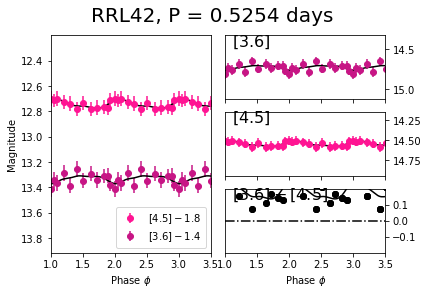

RRab
Channel 1 mags:  []
Channel 2 mags:  [] 

RRab
Channel 1 mags:  []
Channel 2 mags:  [17.73411079 15.94072604 16.0758434  16.17007593 15.80151541 17.8712648
 15.80308531 15.77930492 15.74004876 15.88156317 15.85002115 16.41619445] 

RRL44 ---- Period = 0.5599 days
------------------------------------------------------
0 12


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.940    std dev = 0.133     amplitude = 0.374
Channels don't have the same number of measurements, so colour curve couldn't be plotted


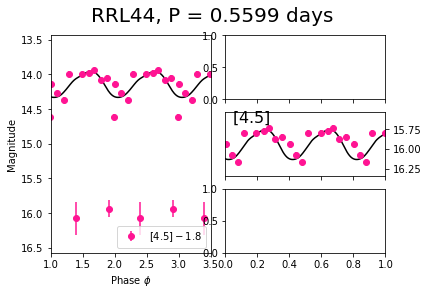

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, nan, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126, nan, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan]
new error ch1: nan
new error ch2: 0.03118914559677736



RRab
Channel 1 mags:  [15.9288828  15.89522965 16.02898789 16.00918344 16.04507279 16.01712176
 15.89275189 15.8699589  15.86902281 15.7053566  15.86182734 15.92202804]
Channel 2 mags:  [15.7569994  15.87603073 15.88381047 15.96087481 15.97302714 15.84543989
 15.84845023 15.74517222 15.8581738  15.8582946  15.85801302 15.81407632] 

RRL45 ---- Period = 0.5833 days
------------------------------------------------------
12 1

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.861    std dev = 0.046     amplitude = 0.140
<[3.6] - [4.5]> = 0.059    std dev = 0.053     amplitude = 0.170


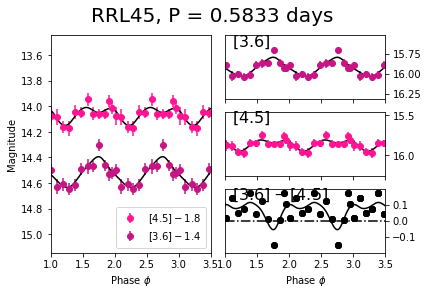

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, nan, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126, nan, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092]
new error ch1: 0.01997602667697092
new error ch2: 0.011689666638514229




Star in forbidden zone (or isnt RRab/RRc)

RRab
Channel 1 mags:  [16.07025425 16.12910685 16.07091523 16.07488746 16.17250724 15.91816459
 16.05563539 16.02433611 16.00992125 15.98581279 16.02457067 16.09299816]
Channel 2 mags:  [16.01029348 16.07621485 16.01569755 16.13564741 16.12827493 16.01392981
 15.9409924  15.99530883 15.97378953 99.         15.97946836 16.15571914] 

RRL47 ---

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 16.048    std dev = 0.036     amplitude = 0.106
<[4.5]> = 16.033    std dev = 0.056     amplitude = 0.163
Channels don't have the same number of measurements, so colour curve couldn't be plotted

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


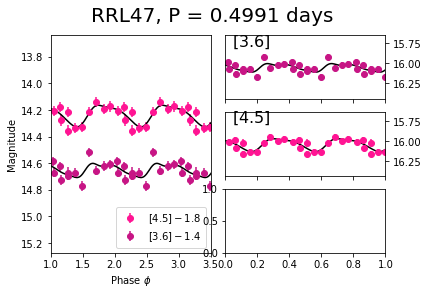

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, nan, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126, nan, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, nan, 0.008871178682373268]
new error ch1: 0.008871178682373268
new error ch2: 0.014174223551094628



RRab
Channel 1 mags:  [15.80027791 99.         15.97115833 15.74125266 15.79513887 15.87820864
 16.35627622 99.         15.65471656 15.86034004 15.74792846 15.80463547]
Channel 2 mags:  [99.         99.         99.         16.0193543  15.84955871 15.86186344
 99.         99.         15.88880381 99.         99.         99.        ] 

RRL48 ---- Period = 0.565

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)
C:\Users\Jake\MPhys-code\MPhys-RRL\final_scripts\gloess_fits.py:69: RuntimeWarning: invalid value encountered in sqrt
  sigma_c3=np.sqrt(ai33)
C:\Users\Jake\MPhys-code\MPhys-RRL\final_scripts\gloess_fits.py:67: RuntimeWarning: invalid value encountered in sqrt
  sigma_c1=np.sqrt(ai11)
C:\Users\Jake\MPhys-code\MPhys-RRL\final_scripts\gloess_fits.py:68: RuntimeWarning: invalid value encountered in sqrt
  sigma_c2=np.sqrt(ai22)
C:\Users\Jake\MPhys-code\MPhys-RRL\final_scripts\gloess_fits.py:51: RuntimeWarning: invalid value encountered in double_scalars
  ai11=cofa11/det
C:\Users\Jake\MPhys-code\MPhys-RRL\final_scripts\gloess_fits.py:52: RuntimeWarning: invalid value encountered in double_scalars
  ai12=cofa21/det
C:\Users\Jake\MPhys-code\MPhys-RRL\final_scripts\gloess_fits.py:53: RuntimeWarning: invalid value encountere

<[3.6]> = 15.844    std dev = 0.095     amplitude = 0.338
<[4.5]> = 15.948    std dev = 0.101     amplitude = 0.297
Channels don't have the same number of measurements, so colour curve couldn't be plotted


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


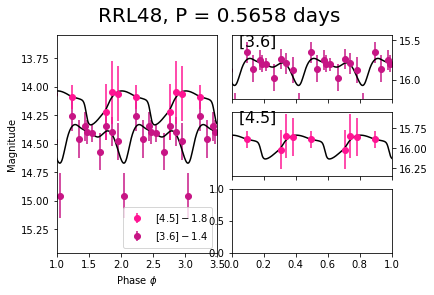

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, nan, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126, nan, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, nan, 0.008871178682373268, 0.03083994437805023]
new error ch1: 0.03083994437805023
new error ch2: 0.042936318545389




Star in forbidden zone (or isnt RRab/RRc)

RRab
Channel 1 mags:  [16.00354504 16.07692224 16.0324734  16.10340186 15.85439123 15.99353532
 15.98494879 15.93412868 15.93862553 16.0170203  16.04561582 15.9357012 ]
Channel 2 mags:  [15.9767837  16.02554036 16.02261863 16.10442633 15.99131945 16.02998774
 15.90792241 15.95653034 16.0444405  15.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[3.6] - [4.5]> = 0.001    std dev = 0.041     amplitude = 0.149


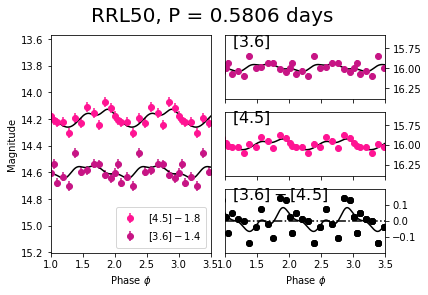

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, nan, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126, nan, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, nan, 0.008871178682373268, 0.03083994437805023, nan, 0.007891469496489556]
new error ch1: 0.007891469496489556
new error ch2: 0.011171376290898186



RRab
Channel 1 mags:  [15.64577209 15.99093971 15.75101838 15.78715174 15.92555535 15.78285624
 16.35478792 15.91848182 15.87189235 15.86330924 15.68581833 15.72147221]
Channel 2 mags:  [15.73942973 15.94439633 15.82461484 15.81289676 99.         15.90767468
 15.98788872 15.79742418 99.         99.         15.6

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 15.859    std dev = 0.096     amplitude = 0.316
<[4.5]> = 15.817    std dev = 0.081     amplitude = 0.268
Channels don't have the same number of measurements, so colour curve couldn't be plotted


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


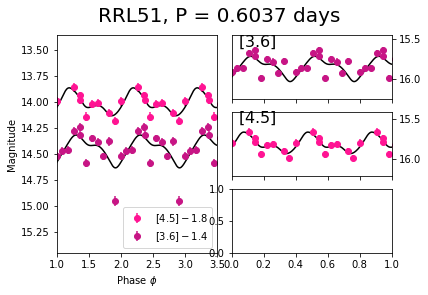

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, nan, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126, nan, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, nan, 0.008871178682373268, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696]
new error ch1: 0.0263297047389696
new error ch2: 0.025807150919949257



RRab
Channel 1 mags:  []
Channel 2 mags:  [] 


Star in forbidden zone (or isnt RRab/RRc)


Star in forbidden zone (or isnt RRab/RRc)


Star in forbidden zone (or isnt RRab/RRc)

RRab
Channel 1 mags:  [15.8288475  15.98132427 16.10804907 16.120271   15.98013645 15.96643531
 16.09210971 15.9341

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.972    std dev = 0.047     amplitude = 0.145
<[3.6] - [4.5]> = 0.009    std dev = 0.040     amplitude = 0.135


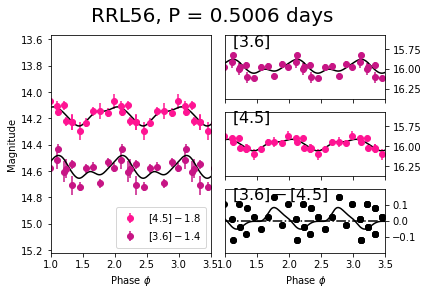

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, nan, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126, nan, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, nan, 0.008871178682373268, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, nan, nan, nan, 0.01441594851329612]
new error ch1: 0.01441594851329612
new error ch2: 0.012081822523256106



RRd
Channel 1 mags:  [12.62294119 12.59545243 12.65985619 12.64731191 12.55086946 12.60646122
 12.57552975 12.61461241 12.66992822 12.56819883 12.60962597 12.56328107]
Channel 2 mags:  [12.58316782 12.56729352 12.64524654 12.64967408 12.69895048 12.537

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 12.623    std dev = 0.032     amplitude = 0.106
<[3.6] - [4.5]> = -0.018    std dev = 0.031     amplitude = 0.115


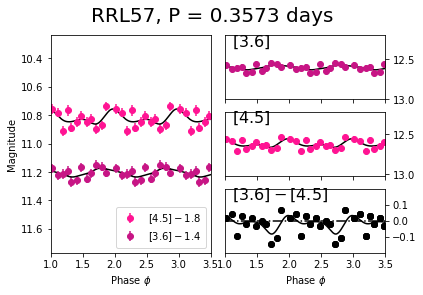


Star in forbidden zone (or isnt RRab/RRc)

RRab
Channel 1 mags:  []
Channel 2 mags:  [] 

RRd
Channel 1 mags:  [16.33177001 16.31187729 16.23064056 16.13024401 16.06856935 16.1100166
 16.1815929  16.29098885 16.19636339 15.98483602 16.0312019  16.10762074]
Channel 2 mags:  [16.16174949 99.         16.10152615 16.03118788 16.01720646 16.0917715
 16.23486599 99.         16.24569791 16.18426347 16.15818806 16.06066337] 

RRL60 ---- Period = 0.3578 days
------------------------------------------------------
12 10


C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 16.162    std dev = 0.087     amplitude = 0.245
<[4.5]> = 16.138    std dev = 0.056     amplitude = 0.160
Channels don't have the same number of measurements, so colour curve couldn't be plotted


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


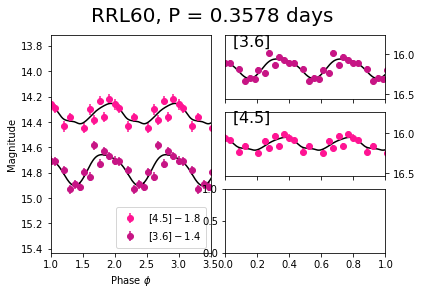

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, nan, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126, nan, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, nan, 0.008871178682373268, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, nan, nan, nan, 0.01441594851329612, nan, nan, nan, 0.020382889740956738]
new error ch1: 0.020382889740956738
new error ch2: 0.014646449698635572



RRab
Channel 1 mags:  [15.8848578  15.99890518 15.95912398 16.02974915 15.74395865 15.87357579
 15.85114578 15.72178228 15.83595355 15.87626744 15.92342489 15.81976794]
Channel 2 mags:  [15.88568653 15.97412353 15.

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 15.874    std dev = 0.054     amplitude = 0.179
<[4.5]> = 15.809    std dev = 0.109     amplitude = 0.328
Channels don't have the same number of measurements, so colour curve couldn't be plotted

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


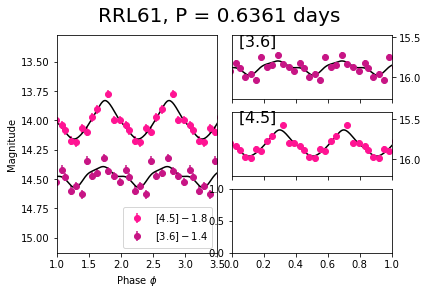

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, nan, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126, nan, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, nan, 0.008871178682373268, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, nan, nan, nan, 0.01441594851329612, nan, nan, nan, 0.020382889740956738, 0.014927759422480738]
new error ch1: 0.014927759422480738
new error ch2: 0.028568573721776406



RRd
Channel 1 mags:  [16.1896533  16.03961562 16.15745228 16.14538789 16.2170566  16.2686903
 16.20330821 16.06819738 16.21469338 15.9948623  16.1868021  16.23449408]
Channel 2 mags:  [16.1466

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 16.162    std dev = 0.011     amplitude = 0.038
<[3.6] - [4.5]> = 0.003    std dev = 0.049     amplitude = 0.141


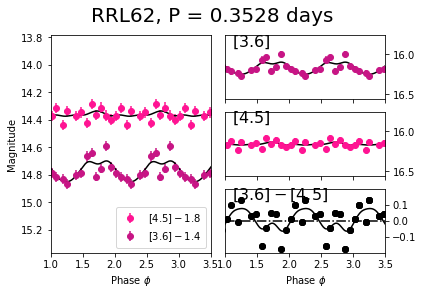

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, nan, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126, nan, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, nan, 0.008871178682373268, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, nan, nan, nan, 0.01441594851329612, nan, nan, nan, 0.020382889740956738, 0.014927759422480738, 0.012620808577274248]
new error ch1: 0.012620808577274248
new error ch2: 0.003170625862118174



RRab
Channel 1 mags:  [15.94019329 15.96420487 15.87654548 15.81981649 15.6819578  15.75107359
 15.79074855 15.75504768 15.83742729 15.99414389 15.97985151 15.81484973]
C

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[3.6]> = 15.846    std dev = 0.075     amplitude = 0.214
<[4.5]> = 15.793    std dev = 0.095     amplitude = 0.276
<[3.6] - [4.5]> = 0.052    std dev = 0.072     amplitude = 0.226


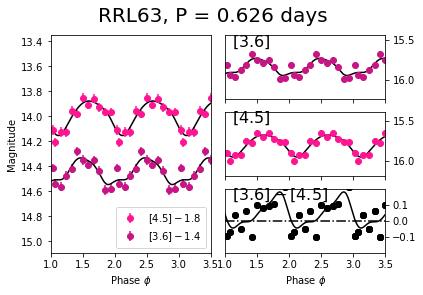

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, nan, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126, nan, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, nan, 0.008871178682373268, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, nan, nan, nan, 0.01441594851329612, nan, nan, nan, 0.020382889740956738, 0.014927759422480738, 0.012620808577274248, 0.01779479145943637]
new error ch1: 0.01779479145943637
new error ch2: 0.02303313497244878



RRc
Channel 1 mags:  [16.01821594 16.13412928 16.28265769 16.38464605 16.61152932 16.59606138
 16.15415477 16.2919999  16.533605   16.46687713 16.33607

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


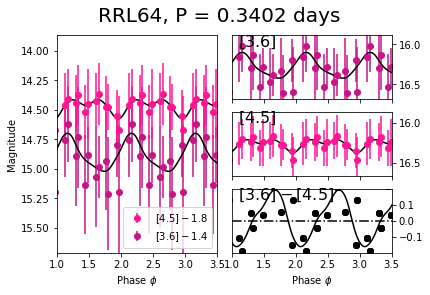

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, nan, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126, nan, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, nan, 0.008871178682373268, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, nan, nan, nan, 0.01441594851329612, nan, nan, nan, 0.020382889740956738, 0.014927759422480738, 0.012620808577274248, 0.01779479145943637, 0.02679323088976589]
new error ch1: 0.02679323088976589
new error ch2: 0.013400786506440276




Star in forbidden zone (or isnt RRab/RRc)


Star in forbidden zone (or isnt RRab/RRc)


Star in forbidden zone (or isnt RRab/RRc

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[3.6]> = 15.836    std dev = 0.068     amplitude = 0.187
Channels don't have the same number of measurements, so colour curve couldn't be plotted


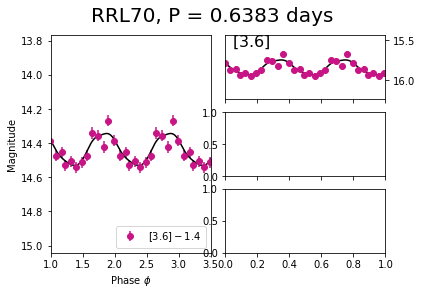

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, nan, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126, nan, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, nan, 0.008871178682373268, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, nan, nan, nan, 0.01441594851329612, nan, nan, nan, 0.020382889740956738, 0.014927759422480738, 0.012620808577274248, 0.01779479145943637, 0.02679323088976589, nan, nan, nan, nan, nan, 0.015547056280382924]
new error ch1: 0.015547056280382924
new error ch2: nan



RRc
Channel 1 mags:  [16.05595861 16.10962625 16.16575095 16.24510568 16.17401004 16.14121826
 16.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 16.089    std dev = 0.039     amplitude = 0.114
<[3.6] - [4.5]> = 0.064    std dev = 0.028     amplitude = 0.090


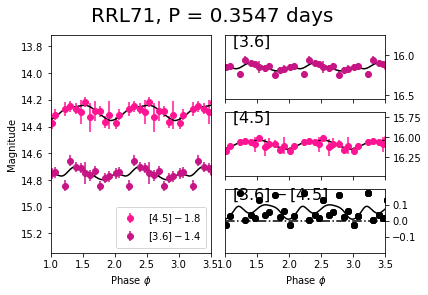

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, nan, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126, nan, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, nan, 0.008871178682373268, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, nan, nan, nan, 0.01441594851329612, nan, nan, nan, 0.020382889740956738, 0.014927759422480738, 0.012620808577274248, 0.01779479145943637, 0.02679323088976589, nan, nan, nan, nan, nan, 0.015547056280382924, 0.008230332497542866]
new error ch1: 0.008230332497542866
new error ch2: 0.009491446050346871



RRd
Channel 1 mags:  [16.32528026 16.17162912 15.97409704 9

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 16.166    std dev = 0.092     amplitude = 0.308
<[4.5]> = 16.214    std dev = 0.065     amplitude = 0.204
Channels don't have the same number of measurements, so colour curve couldn't be plotted


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


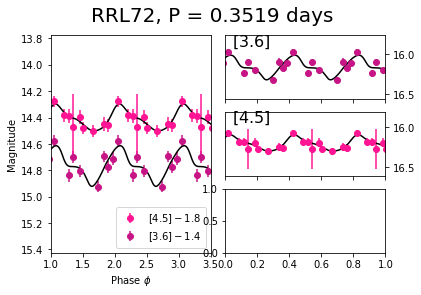

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, nan, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126, nan, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, nan, 0.008871178682373268, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, nan, nan, nan, 0.01441594851329612, nan, nan, nan, 0.020382889740956738, 0.014927759422480738, 0.012620808577274248, 0.01779479145943637, 0.02679323088976589, nan, nan, nan, nan, nan, 0.015547056280382924, 0.008230332497542866, 0.03139227939433837]
new error ch1: 0.03139227939433837
new error ch2: 0.019613735011666748



RRab
Channel 1 mags:  []
Channel 2 mags

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 16.086    std dev = 0.026     amplitude = 0.083
<[3.6] - [4.5]> = 0.068    std dev = 0.037     amplitude = 0.117


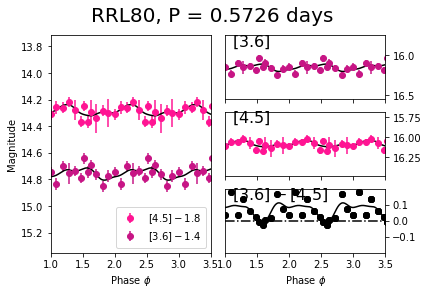

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, nan, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126, nan, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, nan, 0.008871178682373268, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, nan, nan, nan, 0.01441594851329612, nan, nan, nan, 0.020382889740956738, 0.014927759422480738, 0.012620808577274248, 0.01779479145943637, 0.02679323088976589, nan, nan, nan, nan, nan, 0.015547056280382924, 0.008230332497542866, 0.03139227939433837, nan, nan, nan, nan, nan, nan, nan, 0.007677137609318763]
new error ch1: 0.007677137609318763
new error ch2: 0.006

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 16.196    std dev = 0.020     amplitude = 0.065
<[4.5]> = 16.140    std dev = 0.100     amplitude = 0.339
Channels don't have the same number of measurements, so colour curve couldn't be plotted

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


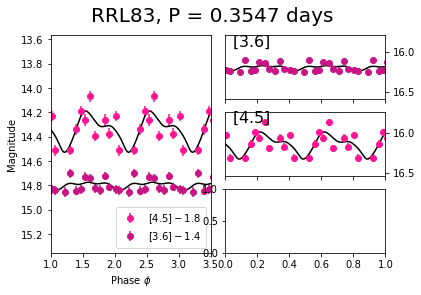

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, nan, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126, nan, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, nan, 0.008871178682373268, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, nan, nan, nan, 0.01441594851329612, nan, nan, nan, 0.020382889740956738, 0.014927759422480738, 0.012620808577274248, 0.01779479145943637, 0.02679323088976589, nan, nan, nan, nan, nan, 0.015547056280382924, 0.008230332497542866, 0.03139227939433837, nan, nan, nan, nan, nan, nan, nan, 0.007677137609318763, nan, nan, 0.005395401355338336]
new error ch1: 0.0053954

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 16.217    std dev = 0.052     amplitude = 0.151
<[4.5]> = 16.210    std dev = 0.061     amplitude = 0.192
Channels don't have the same number of measurements, so colour curve couldn't be plotted

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


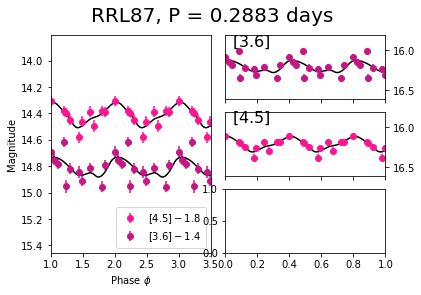

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, nan, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126, nan, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, nan, 0.008871178682373268, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, nan, nan, nan, 0.01441594851329612, nan, nan, nan, 0.020382889740956738, 0.014927759422480738, 0.012620808577274248, 0.01779479145943637, 0.02679323088976589, nan, nan, nan, nan, nan, 0.015547056280382924, 0.008230332497542866, 0.03139227939433837, nan, nan, nan, nan, nan, nan, nan, 0.007677137609318763, nan, nan, 0.005395401355338336, nan, nan, nan, 0.0131053

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


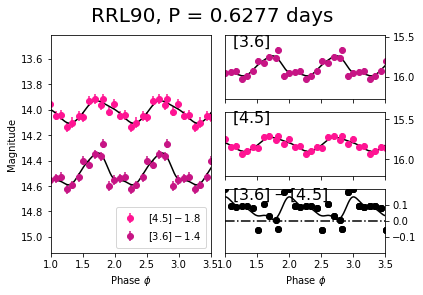

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, nan, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126, nan, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, nan, 0.008871178682373268, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, nan, nan, nan, 0.01441594851329612, nan, nan, nan, 0.020382889740956738, 0.014927759422480738, 0.012620808577274248, 0.01779479145943637, 0.02679323088976589, nan, nan, nan, nan, nan, 0.015547056280382924, 0.008230332497542866, 0.03139227939433837, nan, nan, nan, nan, nan, nan, nan, 0.007677137609318763, nan, nan, 0.005395401355338336, nan, nan, nan, 0.0131053

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.647    std dev = 0.052     amplitude = 0.146
<[3.6] - [4.5]> = 0.027    std dev = 0.015     amplitude = 0.062


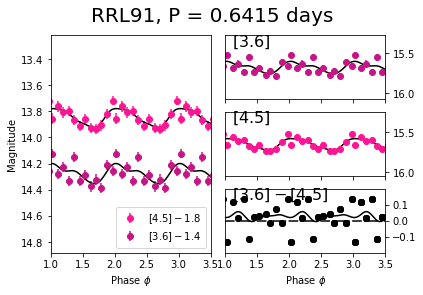

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, nan, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126, nan, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, nan, 0.008871178682373268, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, nan, nan, nan, 0.01441594851329612, nan, nan, nan, 0.020382889740956738, 0.014927759422480738, 0.012620808577274248, 0.01779479145943637, 0.02679323088976589, nan, nan, nan, nan, nan, 0.015547056280382924, 0.008230332497542866, 0.03139227939433837, nan, nan, nan, nan, nan, nan, nan, 0.007677137609318763, nan, nan, 0.005395401355338336, nan, nan, nan, 0.0131053

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 16.120    std dev = 0.066     amplitude = 0.195


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 16.159    std dev = 0.112     amplitude = 0.340
<[3.6] - [4.5]> = -0.039    std dev = 0.068     amplitude = 0.235


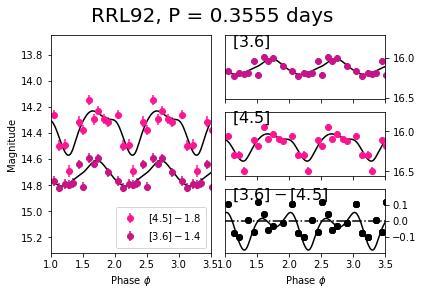

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, nan, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126, nan, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, nan, 0.008871178682373268, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, nan, nan, nan, 0.01441594851329612, nan, nan, nan, 0.020382889740956738, 0.014927759422480738, 0.012620808577274248, 0.01779479145943637, 0.02679323088976589, nan, nan, nan, nan, nan, 0.015547056280382924, 0.008230332497542866, 0.03139227939433837, nan, nan, nan, nan, nan, nan, nan, 0.007677137609318763, nan, nan, 0.005395401355338336, nan, nan, nan, 0.0131053

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 16.168    std dev = 0.132     amplitude = 0.414
<[4.5]> = 16.192    std dev = 0.043     amplitude = 0.143


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[3.6] - [4.5]> = -0.024    std dev = 0.156     amplitude = 0.517


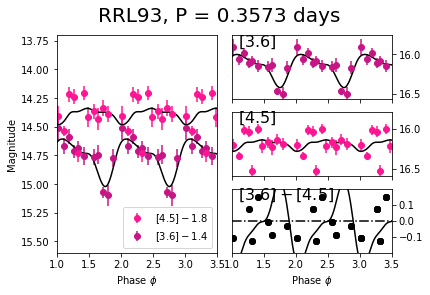

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, nan, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126, nan, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, nan, 0.008871178682373268, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, nan, nan, nan, 0.01441594851329612, nan, nan, nan, 0.020382889740956738, 0.014927759422480738, 0.012620808577274248, 0.01779479145943637, 0.02679323088976589, nan, nan, nan, nan, nan, 0.015547056280382924, 0.008230332497542866, 0.03139227939433837, nan, nan, nan, nan, nan, nan, nan, 0.007677137609318763, nan, nan, 0.005395401355338336, nan, nan, nan, 0.0131053

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 16.309    std dev = 0.033     amplitude = 0.107
Channels don't have the same number of measurements, so colour curve couldn't be plotted


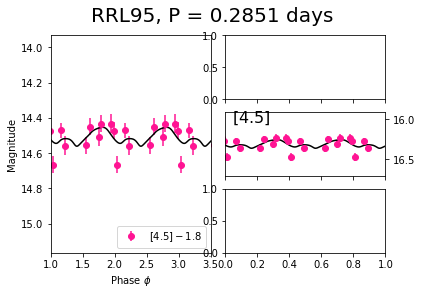

[nan, 0.02205767930696941, 0.028319874287772044, nan, nan, nan, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, nan, nan, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, nan, nan, 0.01819808922893218, nan, nan, nan, 0.02764399924573106, 0.01871798176793126, nan, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, nan, 0.008871178682373268, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, nan, nan, nan, 0.01441594851329612, nan, nan, nan, 0.020382889740956738, 0.014927759422480738, 0.012620808577274248, 0.01779479145943637, 0.02679323088976589, nan, nan, nan, nan, nan, 0.015547056280382924, 0.008230332497542866, 0.03139227939433837, nan, nan, nan, nan, nan, nan, nan, 0.007677137609318763, nan, nan, 0.005395401355338336, nan, nan, nan, 0.0131053

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.795    std dev = 0.026     amplitude = 0.086
<[3.6] - [4.5]> = 0.088    std dev = 0.125     amplitude = 0.371


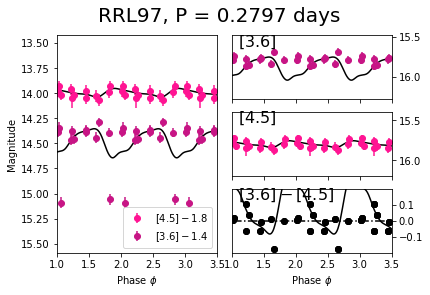

RRc
Channel 1 mags:  [12.91396909 12.92855412 12.67245627 12.70173465 12.62723084 12.59125913
 12.86814507 12.62855301 12.58756584 12.99295035 12.73675083 12.62667131]
Channel 2 mags:  [12.82427599 12.79233471 99.         12.83110764 99.         12.77135066
 12.76280071 12.68692698 99.         12.83742197 12.90013897 12.85768218] 

RRL98 ---- Period = 0.3607 days
------------------------------------------------------
12 9


C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 12.737    std dev = 0.066     amplitude = 0.225
<[4.5]> = 12.809    std dev = 0.036     amplitude = 0.105
Channels don't have the same number of measurements, so colour curve couldn't be plotted


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


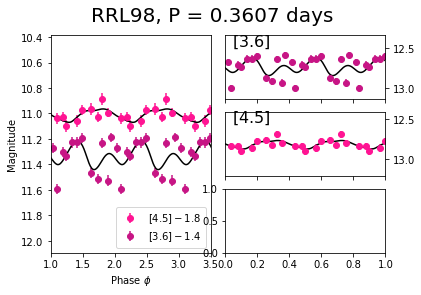

98
[nan, 16.062549046114, 16.07514475715958, nan, nan, nan, 15.7801954817224, 16.01436604890409, 15.679308001507556, nan, 15.761648965163737, 15.928938471000391, nan, nan, nan, 15.837110240504098, nan, nan, 15.987823548500344, nan, 16.10275323071839, nan, 15.999854031494975, nan, 15.67024307628635, nan, 15.99737901538643, nan, nan, 15.898605252823803, nan, nan, nan, 16.049486433483978, 15.604707889222606, nan, 15.859879574307694, nan, 15.830914024157257, nan, nan, nan, nan, nan, 15.880644667004951, nan, 16.00928849310882, 15.803672489732563, nan, 15.951438296780513, 15.819271321621434, nan, nan, nan, nan, 15.940986078869626, nan, nan, nan, 16.122376178691418, 15.835330861876374, 16.126595724252482, 15.806821181066642, 16.246031686418394, nan, nan, nan, nan, nan, 15.79539268398306, 16.114394912989045, 16.125572861156783, nan, nan, nan, nan, nan, nan, nan, 16.115466633272938, nan, nan, 16.15673790440372, nan, nan, nan, 16.17668772975797, nan, nan, 15.844792548093572, 15.635446237264775, 

ID            RA           dec units  period  mean_mag_CC  amplitude  \
0     1  15h00m53.07s  -82d12m49.8s    R0  0.6099       17.612       0.74   
1     2  15h00m34.18s  -82d14m25.0s    R0  0.4936       17.670       1.21   
2     3  14h59m28.92s  -82d14m39.6s    R0  0.4832       17.697       1.21   
3     4  14h59m54.70s  -82d12m38.1s    R0  0.6236       17.676       0.80   
4     5  14h59m54.37s  -82d13m39.7s    R0  0.5569       17.656       1.11   
..  ...           ...           ...   ...     ...          ...        ...   
93  112  14h59m55.31s  -82d11m50.3s    R0  0.6113       17.717       0.44   
94  153  14h59m10.31s  -82d15m46.8s    R0  0.2851       17.678       0.31   
95  167  15h00m26.10s  -82d12m35.0s    R0  0.7067       17.524       0.56   
96  171  15h00m42.31s  -82d13m45.2s    R0  0.2797       17.666       0.22   
97  173  14h59m09.00s  -82d11m11.3s    R0  0.3607       14.200        NaN   

   colour type  id_new  ...  mean_photerr_amp_ch2  mean_photerr_mon_ch1  \
0       V  RR0       0  ...                   NaN                   NaN   
1       V  RR0       1  ...              0.017552              0.015702   
2       V  RR0       2  ...              0.024977              0.011315   
3       V  RR0       3  ...                   NaN                   NaN   
4       V  RR0       4  ...                   NaN                   NaN   
..    ...  ...     ...  ...                   ...                   ...   
93      V  RR0      93  ...                   NaN                   NaN   
94      V  RR2      94  ...              0.010328                   NaN   
95      V  RR0      95  ...                   NaN                   NaN   
96      V  RR2      96  ...                   NaN                   NaN   
97      V  RR1      97  ...                   NaN                   NaN   

    mean_photerr_mon_ch2  mean_photerr_hen_ch1  mean_photerr_hen_ch2  \
0                    NaN                   NaN                   NaN   
1               0.017038              0.016066              0.017793   
2               0.012151              0.011382              0.012224   
3                    NaN                   NaN                   NaN   
4                    NaN                   NaN                   NaN   
..                   ...                   ...                   ...   
93                   NaN                   NaN                   NaN   
94              0.016311                   NaN              0.016480   
95                   NaN                   NaN                   NaN   
96                   NaN                   NaN                   NaN   
97                   NaN                   NaN                   NaN   

    period_PL  A_ch1  A_ch2   amp_ch1   amp_ch2  
0         NaN    NaN    NaN       NaN       NaN  
1    0.493600  0.039  0.033  0.264692  0.201659  
2    0.483200  0.040  0.033  0.325371  0.273611  
3         NaN    NaN    NaN       NaN       NaN  
4         NaN    NaN    NaN       NaN       NaN  
..        ...    ...    ...       ...       ...  
93        NaN    NaN    NaN       NaN       NaN  
94   0.381942  0.041  0.034       NaN  0.107336  
95        NaN    NaN    NaN       NaN       NaN  
96   0.374708  0.039  0.033       NaN       NaN  
97   0.483221  0.040  0.033       NaN       NaN  

[98 rows x 27 columns]

In [52]:
load_name_ch1 = 'phot_tables/'+cluster+'/individual/big_table_all_'+method+'_3p6um.pickle'
load_name_ch2 = 'phot_tables/'+cluster+'/individual/big_table_all_'+method+'_4p5um.pickle'

pickle_in = open(load_name_ch1, 'rb')
big_table_ch1 = pickle.load(pickle_in)
pickle_in = open(load_name_ch2, 'rb')
big_table_ch2 = pickle.load(pickle_in)

#file_CC = 'data/reference/CVSGC_'+cluster+'_readable.txt'
file_CC = 'data/reference/CVSGC_'+cluster+'_reduced_readable.txt'
df_CC_test = pd.read_csv(file_CC, sep=',', header=0)

LC_time_gloess = []
for filename in glob.glob(base_dir+'*/'+cluster+'__e[0-9]_'+channel+'.fits', recursive=True) + glob.glob(base_dir+'*/'+cluster+'__e[0-9][0-9]_'+channel+'.fits', recursive=True):
    with fits.open(filename) as hdu_list:        
        hdr = hdu_list[0].header
    LC_time_gloess.append(Time(hdr['DATE_OBS'], format='isot', scale='utc').mjd)


ch1_smooth = 0.25
ch2_smooth = 0.25

means_ch1 = []
means_ch2 = []
stds_ch1 = []
stds_ch2 = []
photerr_mean_ch1 = []
photerr_mean_ch2 = []
photerr_amps_ch1 = []
photerr_amps_ch2 = []
photerr_mean_ch1_monson = []
photerr_mean_ch2_monson = []
photerr_mean_ch1_hendel = []
photerr_mean_ch2_hendel = []
amps_ch1 = []
amps_ch2 = []
periods = []
periods_PL = []
A_ch1 = []
A_ch2 = []

for star in range(len(df_CC_test)):
    
    if df_CC_test['type'][star] == 'SR?' or star in inmask:
        
        print('\nStar in forbidden zone (or isnt RRab/RRc)\n')
        
        means_ch1.append(float('NaN'))
        means_ch2.append(float('NaN'))
        stds_ch1.append(float('NaN'))
        stds_ch2.append(float('NaN'))
        photerr_amps_ch1.append(float('NaN'))
        photerr_amps_ch2.append(float('NaN'))
        photerr_mean_ch1_monson.append(float('NaN'))
        photerr_mean_ch2_monson.append(float('NaN'))
        photerr_mean_ch1_hendel.append(float('NaN'))
        photerr_mean_ch2_hendel.append(float('NaN'))
        amps_ch1.append(float('NaN'))
        amps_ch2.append(float('NaN'))
        photerr_mean_ch1.append(float('NaN'))
        photerr_mean_ch2.append(float('NaN'))
        periods.append(float('NaN'))
        periods_PL.append(float('NaN'))
        A_ch1.append(float('NaN'))
        A_ch2.append(float('NaN'))
        
        continue
    
    '''if df_CC_test['gaia_ID'][star] != 0:
        id1 = df_CC_test['gaia_ID_1'][star]
        id2 = df_CC_test['gaia_ID_2'][star]
        gaia_id = int(str(int(id1)) + str(int(id2)))  # this method is so fucked but it's the only way to avoid int precision errors using pandas :)))))
        print('Gaia DR2 ID:', gaia_id)'''
    
    c_CC = SkyCoord(df_CC_test['RA'][star], df_CC_test['dec'][star], frame='icrs', unit='deg')

    if df_CC_test['type'][star] == 'RR0':
        P = df_CC_test['period'][star]
        P_PL = P
        print('RRab')
    elif df_CC_test['type'][star] == 'RR1':
        P = df_CC_test['period'][star]
        P_PL = P * 10**0.127
        print('RRc')
    elif df_CC_test['type'][star] == 'RR01':
        P = df_CC_test['period'][star]
        P_PL = P * 10**0.127
        print('RRd')
    elif df_CC_test['type'][star] == 'RR2':
        P = df_CC_test['period'][star]
        P_PL = P * 10**0.127
        print('RRe (lol)')
    
    periods.append(P)
    periods_PL.append(P_PL)
    temp = [i / P for i in LC_time_gloess]
    phase = temp - np.floor(temp)
    
    big_table_ch1_f = copy.copy(big_table_ch1.filled(99))
    big_table_ch2_f = copy.copy(big_table_ch2.filled(99))

    mags_ch1 = []
    mags_ch2 = []
    errs_ch1 = []
    errs_ch2 = []
    for j in range(1,13):
        if star in ch1_list:
            mags_ch1.append(big_table_ch1['mag_e'+str(j)][star])
            errs_ch1.append(big_table_ch1['err_e'+str(j)][star])
        if star in ch2_list:
            mags_ch2.append(big_table_ch2['mag_e'+str(j)][star])
            errs_ch2.append(big_table_ch2['err_e'+str(j)][star])
    
    '''if cluster == 'PAL13' and star == 1:
        print('hello')
        remove_pls = [1, 3, 6, 7]  # EPOCH number of bad point
        for j in remove_pls:
            mags_ch2[j-1] = 99
            print(mags_ch2)
        print(mags_ch2)'''
        
    '''if cluster == 'PAL13' and star == 1:
        print('hello')
        remove_pls = [2, 4, 5, 8, 9, 10, 11, 12]  # EPOCH number of bad point
        for j in remove_pls:
            mags_ch2[j-1] = 99
            print(mags_ch2)
        print(mags_ch2)'''
    
    # Since GLOESS already discards bunk magnitudes, I need to leave them in as 99:
    mags_ch1 = np.nan_to_num(mags_ch1, nan=99)
    mags_ch2 = np.nan_to_num(mags_ch2, nan=99)
    errs_ch1 = np.nan_to_num(errs_ch1, nan=99)
    errs_ch2 = np.nan_to_num(errs_ch2, nan=99)

    print('Channel 1 mags: ', mags_ch1)
    print('Channel 2 mags: ', mags_ch2, '\n')
    
    ###   EXTINCTION   ###
    
    ex_table = IrsaDust.get_extinction_table(c_CC)
    ex_table.add_index('Filter_name')
    idx_ch1 = ex_table.loc_indices[['IRAC-1']]
    idx_ch2 = ex_table.loc_indices[['IRAC-2']]
    ext_ch1 = ex_table['A_SandF'][idx_ch1]
    ext_ch2 = ex_table['A_SandF'][idx_ch2]
    A_ch1.append(ext_ch1)
    A_ch2.append(ext_ch2)
    
    try:
        mean_ch1, amp_ch1, std_ch1, N_ch1, mean_ch2, amp_ch2, std_ch2, N_ch2 = jg.runGloess(mags_ch1, errs_ch1, mags_ch2, errs_ch2, LC_time_gloess, P, 'RRL'+str(star+1), ch1_smooth, ch2_smooth, wantcolour='yes')
        #mean_ch1, amp_ch1, std_ch1, mean_ch2, amp_ch2, std_ch2 = runGloesstest(mags_ch1, errs_ch1, mags_ch2, errs_ch2, LC_time_gloess, P, 'RRL'+str(star+1), ch1_smooth, ch2_smooth, wantcolour='yes')
    except ValueError:
        means_ch1.append(float('NaN'))
        means_ch2.append(float('NaN'))
        stds_ch1.append(float('NaN'))
        stds_ch2.append(float('NaN'))
        photerr_amps_ch1.append(float('NaN'))
        photerr_amps_ch2.append(float('NaN'))
        photerr_mean_ch1_monson.append(float('NaN'))
        photerr_mean_ch2_monson.append(float('NaN'))
        photerr_mean_ch1_hendel.append(float('NaN'))
        photerr_mean_ch2_hendel.append(float('NaN'))
        amps_ch1.append(float('NaN'))
        amps_ch2.append(float('NaN'))
        photerr_mean_ch1.append(float('NaN'))
        photerr_mean_ch2.append(float('NaN'))
        #periods.append(float('NaN'))
        #periods_PL.append(float('NaN'))
        #A_ch1.append(float('NaN'))
        #A_ch2.append(float('NaN'))
        
        continue
    
    if mean_ch1 <= 15. or mean_ch2 <= 15. or mean_ch1 >= 16.4 or mean_ch2 >= 16.4 or star == 96:
        means_ch1.append(float('NaN'))
        means_ch2.append(float('NaN'))
        stds_ch1.append(float('NaN'))
        stds_ch2.append(float('NaN'))
        photerr_amps_ch1.append(float('NaN'))
        photerr_amps_ch2.append(float('NaN'))
        photerr_mean_ch1_monson.append(float('NaN'))
        photerr_mean_ch2_monson.append(float('NaN'))
        photerr_mean_ch1_hendel.append(float('NaN'))
        photerr_mean_ch2_hendel.append(float('NaN'))
        amps_ch1.append(float('NaN'))
        amps_ch2.append(float('NaN'))
        photerr_mean_ch1.append(float('NaN'))
        photerr_mean_ch2.append(float('NaN'))
        #periods.append(float('NaN'))
        #periods_PL.append(float('NaN'))
        #A_ch1.append(float('NaN'))
        #A_ch2.append(float('NaN'))
        
        continue
    
    # Correcting for extinction:
    mean_ch1 -= ext_ch1
    mean_ch2 -= ext_ch2
    
    means_ch1.append(mean_ch1)
    means_ch2.append(mean_ch2)
    stds_ch1.append(std_ch1)   # uncertainty in gloess fit
    stds_ch2.append(std_ch2)
    amps_ch1.append(amp_ch1)
    amps_ch2.append(amp_ch2)
    
    ###   ERROR IN MEAN MAGNITUDE   ###
    
    # Monson 2017 approach:
    ch1_temp = [(1. / e**2) for e in errs_ch1]
    ch2_temp = [(1. / e**2) for e in errs_ch2]
    
    if ch1_temp:
        photerr_ch1_monson = np.sqrt(1. / sum(ch1_temp))
    else:
        photerr_ch1_monson = float('NaN')
    if ch2_temp:
        photerr_ch2_monson = np.sqrt(1. / sum(ch2_temp))
    else:
        photerr_ch2_monson = float('NaN')
        
    photerr_mean_ch1_monson.append(photerr_ch1_monson)
    photerr_mean_ch2_monson.append(photerr_ch2_monson)
    
    errs_ch1 = np.ma.masked_equal(errs_ch1, 99)
    errs_ch2 = np.ma.masked_equal(errs_ch2, 99)
    
    # Hendel 2018 approach:
    ch1_temp_h = [e**2 for e in errs_ch1.compressed()]
    ch2_temp_h = [e**2 for e in errs_ch2.compressed()]
    
    if ch1_temp_h:
        photerr_ch1_hendel = np.sqrt(sum(ch1_temp_h) / len(errs_ch1.compressed())**2)
    else:
        photerr_ch1_hendel = float('NaN')
    if ch2_temp_h:
        photerr_ch2_hendel = np.sqrt(sum(ch2_temp_h) / len(errs_ch2.compressed())**2)
    else:
        photerr_ch2_hendel = float('NaN')
        
    photerr_mean_ch1_hendel.append(photerr_ch1_hendel)
    photerr_mean_ch2_hendel.append(photerr_ch2_hendel)
        

    # My initial approach:
    if len(errs_ch1) != 0:
        photerr_ch1 = sum(errs_ch1.compressed()) / len(errs_ch1.compressed())
    else:
        photerr_ch1 = float('NaN')
    if len(errs_ch2) != 0:
        photerr_ch2 = sum(errs_ch2.compressed()) / len(errs_ch2.compressed())
    else:
        photerr_ch2 = float('NaN')
    
    photerr_mean_ch1.append(photerr_ch1)
    photerr_mean_ch2.append(photerr_ch2)
        
    # Fit error amplitude approach (instead of std:        
    photerr_amp_ch1 = amp_ch1 / np.sqrt(12 * N_ch1)
    photerr_amp_ch2 = amp_ch2 / np.sqrt(12 * N_ch2)
    
    photerr_amps_ch1.append(photerr_amp_ch1)
    photerr_amps_ch2.append(photerr_amp_ch2)
    print(photerr_amps_ch1)
    
    print('new error ch1:', photerr_amp_ch1)
    print('new error ch2:', photerr_amp_ch2)
    
    
    print('\n\n')

print(len(means_ch1))
print(means_ch1)

df_CC_test['mean_mag_ch1'] = means_ch1
df_CC_test['mean_mag_ch2'] = means_ch2
df_CC_test['mean_std_ch1'] = stds_ch1
df_CC_test['mean_std_ch2'] = stds_ch2
df_CC_test['mean_photerr_ch1'] = photerr_mean_ch1
df_CC_test['mean_photerr_ch2'] = photerr_mean_ch2
df_CC_test['mean_photerr_amp_ch1'] = photerr_amps_ch1
df_CC_test['mean_photerr_amp_ch2'] = photerr_amps_ch2
df_CC_test['mean_photerr_mon_ch1'] = photerr_mean_ch1_monson
df_CC_test['mean_photerr_mon_ch2'] = photerr_mean_ch2_monson
df_CC_test['mean_photerr_hen_ch1'] = photerr_mean_ch1_hendel
df_CC_test['mean_photerr_hen_ch2'] = photerr_mean_ch2_hendel
#df_CC_test['period_used'] = periods
df_CC_test['period_PL'] = periods_PL
df_CC_test['A_ch1'] = A_ch1
df_CC_test['A_ch2'] = A_ch2
df_CC_test['amp_ch1'] = amps_ch1
df_CC_test['amp_ch2'] = amps_ch2

df_CC_test


No. of RRL after masking out core:

In [53]:
tbl_CC_final = Table().from_pandas(df_CC_test)
tbl_CC_final = Table(tbl_CC_final, masked=True, copy=False)
#tbl_CC_final['mean_mag_ch1'].filled(-99.)
#tbl_CC_final['mean_mag_ch2'].filled(-99.)

tbl_CC_final

#for i in range(len(tbl_CC_final)):
#    if tbl_CC_final['mean_mag_ch1'][i] == -99 and tbl_CC_final['mean_mag_ch1'][i] == -99:
#        print('i am masked')

goodlist = []
byelist = []
for i in range(len(tbl_CC_final)):
    if isinstance(tbl_CC_final['mean_mag_ch1'][i], float) == False and isinstance(tbl_CC_final['mean_mag_ch2'][i], float) == False:
        byelist.append(i)
    else:
        goodlist.append(i)

tbl_CC_final.remove_rows(byelist)

print(goodlist)
print(len(goodlist))
print(byelist)
print(len(byelist))
tbl_CC_final.show_in_notebook()

[1, 2, 6, 7, 8, 10, 11, 15, 18, 20, 22, 24, 26, 29, 33, 34, 36, 38, 43, 44, 46, 47, 49, 50, 55, 59, 60, 61, 62, 63, 69, 70, 71, 79, 82, 86, 89, 90, 91, 92, 94]
41
[0, 3, 4, 5, 9, 12, 13, 14, 16, 17, 19, 21, 23, 25, 27, 28, 30, 31, 32, 35, 37, 39, 40, 41, 42, 45, 48, 51, 52, 53, 54, 56, 57, 58, 64, 65, 66, 67, 68, 72, 73, 74, 75, 76, 77, 78, 80, 81, 83, 84, 85, 87, 88, 93, 95, 96, 97]
57


RRab
Channel 1 mags:  [15.18725731 15.20584364 15.2243765  15.25732516 15.16272216 15.20512543
 15.18447421 15.2361551  15.26422389 15.16305999 15.20286252 15.13405936]
Channel 2 mags:  [15.10686771 15.09892358 15.12916537 15.18171141 15.14509713 15.08338314
 15.13654477 15.17354168 15.08997703 15.11078462 15.02322579 15.08552245] 

RRL1 ---- Period = 0.6099 days
------------------------------------------------------
12 12


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[3.6]> = 15.205    std dev = 0.019     amplitude = 0.058
<[4.5]> = 15.114    std dev = 0.027     amplitude = 0.087
<[3.6] - [4.5]> = 0.092    std dev = 0.018     amplitude = 0.057


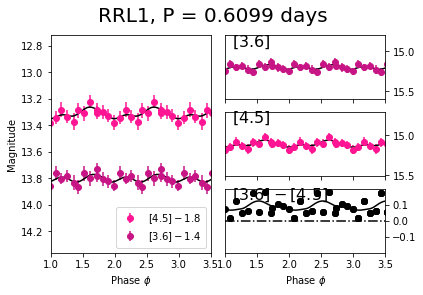

[0.004847262934903451]
new error ch1: 0.004847262934903451
new error ch2: 0.0072797135502399675



RRab
Channel 1 mags:  [15.88541167 16.05769977 16.07177089 16.09764974 16.18633865 16.2814333
 16.22701549 15.94814217 16.00825338 16.09921674 16.08682154 16.1001556 ]
Channel 2 mags:  [16.06883936 99.         15.99904832 16.26282197 16.15486921 16.08615357
 16.28201236 16.19239225 16.10889582 16.11827646 16.05145948 15.97921278] 

RRL2 ---- Period = 0.4936 days
------------------------------------------------------
12 11


C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 16.102    std dev = 0.086     amplitude = 0.265
<[4.5]> = 16.135    std dev = 0.062     amplitude = 0.202
Channels don't have the same number of measurements, so colour curve couldn't be plotted

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


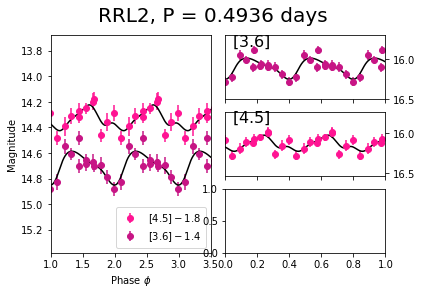

[0.004847262934903451, 0.02205767930696941]
new error ch1: 0.02205767930696941
new error ch2: 0.017552141856224394



RRab
Channel 1 mags:  [16.08996703 16.11011432 16.33861892 16.30359418 16.33947924 15.97145306
 15.9829214  15.99151626 16.08253132 99.         16.0945453  16.13183081]
Channel 2 mags:  [16.02047438 99.         16.08872279 16.16113679 16.1840448  15.97889293
 15.8823258  15.92557494 99.         15.99926547 16.14238768 16.18593872] 

RRL3 ---- Period = 0.4832 days
------------------------------------------------------
11 10


C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 16.115    std dev = 0.104     amplitude = 0.325
<[4.5]> = 16.037    std dev = 0.096     amplitude = 0.274

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Channels don't have the same number of measurements, so colour curve couldn't be plotted


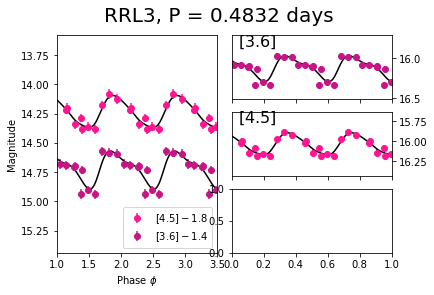

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044]
new error ch1: 0.028319874287772044
new error ch2: 0.02497713111702254



RRab
Channel 1 mags:  [15.03846826 15.12800334 15.11691327 15.0816746  15.05800803 15.14660989
 15.00249509 15.16576687 15.20177701 15.14991964 15.12656771 15.12895152]
Channel 2 mags:  [15.10611861 15.05707381 15.07729154 15.06790133 15.12777991 15.06084186
 15.08578485 15.04846005 15.14349808 15.06734915 15.11863831 15.03242969] 

RRL4 ---- Period = 0.6236 days
------------------------------------------------------
12 12
<[3.6]> = 15.114    std dev = 0.030     amplitude = 0.097


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.083    std dev = 0.012     amplitude = 0.039
<[3.6] - [4.5]> = 0.031    std dev = 0.025     amplitude = 0.085


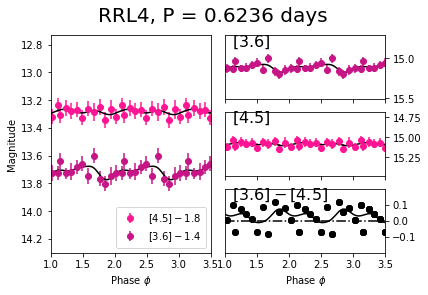

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894]
new error ch1: 0.00806652142730894
new error ch2: 0.00326443101621147



RRab
Channel 1 mags:  [16.13439069 16.10108242 16.14297008 15.96948918 15.99213546 15.82084467
 15.96744635 15.98479197 16.14344632 16.00087971 16.20537668 16.19934915]
Channel 2 mags:  [16.10363544 16.0814847  16.05916679 15.90034833 15.97785929 15.94649645
 15.85969522 16.03404726 16.00593559 16.07821259 16.1437814  16.04289137] 

RRL5 ---- Period = 0.5569 days
------------------------------------------------------
12 12
<[3.6]> = 16.030    std dev = 0.087     amplitude = 0.271


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 16.010    std dev = 0.061     amplitude = 0.182
<[3.6] - [4.5]> = 0.020    std dev = 0.042     amplitude = 0.144


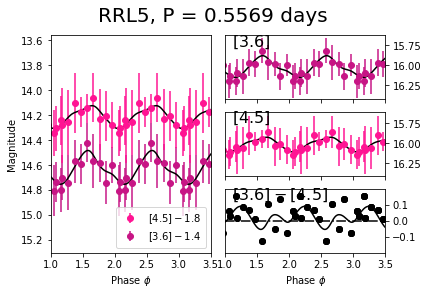

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176]
new error ch1: 0.022566225564902176
new error ch2: 0.015208129521128525



RRab
Channel 1 mags:  [15.6869195  15.73290343 15.83995838 15.85700838 99.         15.88497754
 99.         15.81127177 15.78112317 15.72530566 15.7432209  15.68831746]
Channel 2 mags:  [15.67899142 15.67088622 15.71670269 99.         15.77192128 99.
 99.         99.         15.66259092 15.73247247 15.72889944 15.75852342] 

RRL6 ---- Period = 0.5779 days
------------------------------------------------------
10 8


C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 15.801    std dev = 0.063     amplitude = 0.179
<[4.5]> = 15.717    std dev = 0.031     amplitude = 0.103
Channels don't have the same number of measurements, so colour curve couldn't be plotted


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


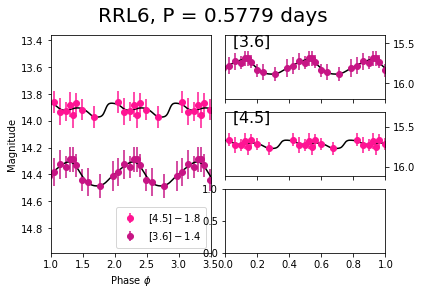

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523]
new error ch1: 0.016354688284023523
new error ch2: 0.010547159332867392



RRab
Channel 1 mags:  [15.95559097 15.67021373 16.01646958 15.93302003 15.9874559  15.64174126
 15.74567976 15.63849563 15.7897407  15.62167335 15.93015702 16.0707946 ]
Channel 2 mags:  [99.         99.         99.         99.         99.         99.
 15.7905455  15.7526059  99.         15.63992023 15.79764138 99.        ] 

RRL7 ---- Period = 0.6179 days
------------------------------------------------------
12 4


C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[3.6]> = 15.820    std dev = 0.092     amplitude = 0.256
<[4.5]> = 15.830    std dev = 0.107     amplitude = 0.354
Channels don't have the same number of measurements, so colour curve couldn't be plotted


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


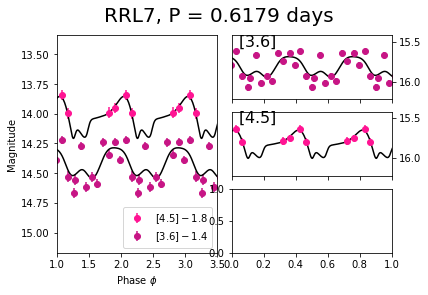

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446]
new error ch1: 0.021307906023734446
new error ch2: 0.05103889015521645



RRd
Channel 1 mags:  [15.82198823 15.90844379 15.89425384 16.00879137 99.         15.75326828
 15.97606081 16.97941237 15.89399337 15.8373441  16.56847136 15.96217553]
Channel 2 mags:  [15.78724102 15.91587326 15.87244284 15.93898533 15.88031125 15.73124514
 15.68397305 15.7341828  15.77993107 15.90538342 99.         15.78170217] 

RRL8 ---- Period = 0.3674 days
------------------------------------------------------
11 11


C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 16.053    std dev = 0.163     amplitude = 0.480
<[4.5]> = 15.816    std dev = 0.075     amplitude = 0.219


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[3.6] - [4.5]> = 0.237    std dev = 0.158     amplitude = 0.540


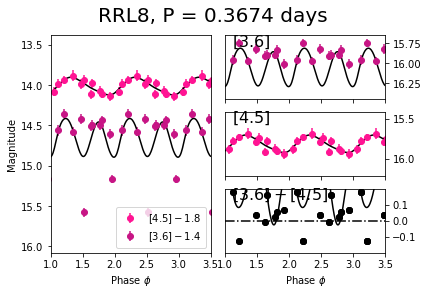

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088]
new error ch1: 0.04178438451200088
new error ch2: 0.019073310143958175



RRab
Channel 1 mags:  [15.90919773 15.83086191 15.86801284 15.71206129 15.74244345 15.65133956
 15.54932481 15.69675432 15.71818672 15.64519707 15.59478953 15.71694141]
Channel 2 mags:  [15.84789418 15.74419376 15.67793867 15.66355599 15.63420794 15.50785011
 15.55968517 15.53462327 15.64589698 15.61612879 15.70828673 15.62401232] 

RRL9 ---- Period = 0.7096 days
------------------------------------------------------
12 12
<[3.6]> = 15.718    std dev = 0.080     amplitude = 0.236


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.654    std dev = 0.075     amplitude = 0.236
<[3.6] - [4.5]> = 0.064    std dev = 0.034     amplitude = 0.108


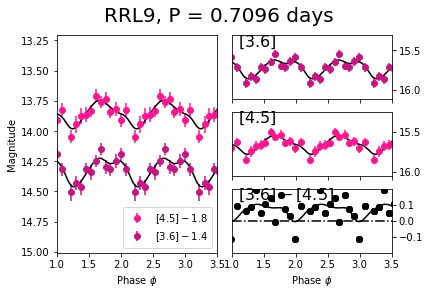

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741]
new error ch1: 0.0196692504600741
new error ch2: 0.019705055925177756



RRd
Channel 1 mags:  [13.37235711 13.34391963 13.41756779 13.34427907 13.40339712 13.33128333
 13.41160285 13.40443931 13.44366968 13.40884305 13.2863655  13.32669772]
Channel 2 mags:  [13.38644343 13.43637733 13.37529688 13.41448045 13.4189897  15.86435199
 16.08499681 13.35337889 13.34546096 15.80924934 15.69382664 15.80829736] 

RRL10 ---- Period = 0.3532 days
------------------------------------------------------
12 12
<[3.6]> = 13.374    std dev = 0.026     amplitude = 0.078


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 13.748    std dev = 0.414     amplitude = 1.429
<[3.6] - [4.5]> = -0.374    std dev = 0.429     amplitude = 1.469


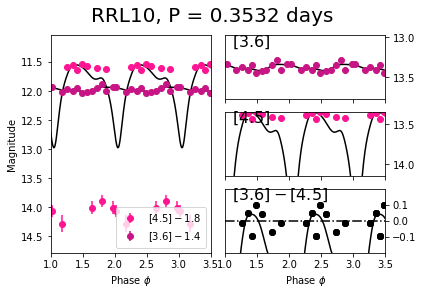

RRab
Channel 1 mags:  [15.75817388 15.72535474 15.73864063 15.80943113 15.85092704 15.89813438
 15.87847135 15.90463321 15.84941483 15.7598148  15.731949   15.68129407]
Channel 2 mags:  [15.69420247 15.60498307 15.72668309 15.64916908 15.77147605 15.85691876
 15.81121888 15.79176175 15.73427925 15.7175583  15.68787449 15.65678855] 

RRL11 ---- Period = 0.6315 days
------------------------------------------------------
12 12
<[3.6]> = 15.801    std dev = 0.064     amplitude = 0.175


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.728    std dev = 0.057     amplitude = 0.166
<[3.6] - [4.5]> = 0.073    std dev = 0.016     amplitude = 0.052


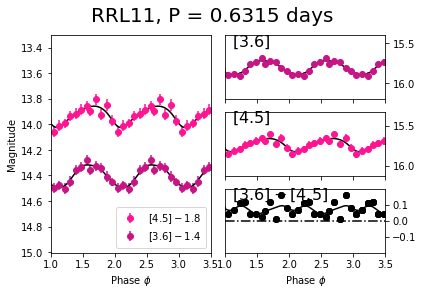

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329]
new error ch1: 0.014595259382162329
new error ch2: 0.01382719556600446



RRab
Channel 1 mags:  [15.97034625 15.95621248 15.98723901 15.91155494 15.93471648 15.94618696
 15.84159963 15.98726273 16.01211639 16.14925145 15.98975872 15.91862064]
Channel 2 mags:  [15.90879524 15.94323608 15.89020614 15.89099223 15.72446898 15.82921832
 15.86021582 15.91187948 16.00208338 15.9547324  16.00025816 15.97872521] 

RRL12 ---- Period = 0.5948 days
------------------------------------------------------
12 12
<[3.6]> = 15.968    std dev = 0.052     amplitude = 0.173
<[4.5]> = 15.903    std dev = 0.065     amplitude = 0.191
<[3.6] - [4.5]> = 0.065    std dev = 0.036     amplitude = 0.123

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


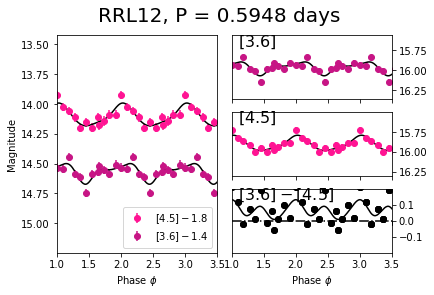

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757]
new error ch1: 0.014451822395278757
new error ch2: 0.01591443826410292



RRab
Channel 1 mags:  [14.88588356 14.73542426 14.81038698 14.84089065 14.72500696 14.87029811
 14.74955213 14.81274457 14.84388797 14.70087455 14.8260878  14.78612647]
Channel 2 mags:  [14.80937114 14.83080337 14.88079987 14.84129552 14.78706505 14.81465202
 14.82438925 14.80432065 14.84939735 14.79955276 14.78880802 14.82067788] 

RRL13 ---- Period = 0.5115 days
------------------------------------------------------
12 12
<[3.6]> = 14.797    std dev = 0.005     amplitude = 0.017


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 14.819    std dev = 0.011     amplitude = 0.037
<[3.6] - [4.5]> = -0.023    std dev = 0.010     amplitude = 0.038


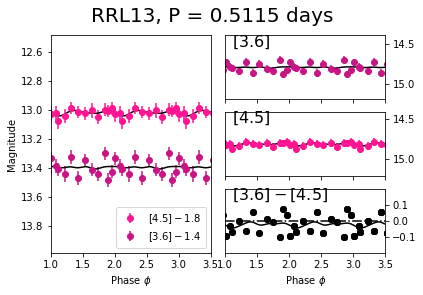

RRab
Channel 1 mags:  [13.18019053 13.32804635 13.32939663 13.28481753 13.24368089 13.23450672
 13.27458426 13.20637142 13.18295186 13.12954929 13.16408429 13.20907368]
Channel 2 mags:  [13.27669576 13.17077554 13.24019799 13.22735973 13.19154172 13.26627739
 13.21328156 13.20338743 13.21825681 13.19970529 13.23512345 13.21851633] 

RRL14 ---- Period = 0.5001 days
------------------------------------------------------
12 12
<[3.6]> = 13.231    std dev = 0.038     amplitude = 0.118


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 13.221    std dev = 0.006     amplitude = 0.024
<[3.6] - [4.5]> = 0.009    std dev = 0.038     amplitude = 0.123


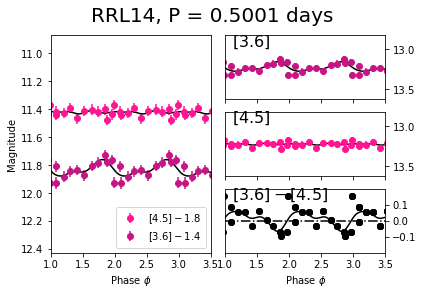

RRab
Channel 1 mags:  [14.55979446 14.47102331 14.47435393 14.48937219 14.5263371  14.42666465
 14.50823712 14.45377744 14.49210356 14.39113734 14.44604428 14.42668881]
Channel 2 mags:  [14.49325247 14.43641406 14.40626087 14.41229083 14.46275943 14.42252599
 14.40392736 14.43995    14.51188756 14.49629615 14.3212111  14.45840415] 

RRL15 ---- Period = 0.5968 days
------------------------------------------------------
12 12
<[3.6]> = 14.472    std dev = 0.018     amplitude = 0.060
<[4.5]> = 14.439    std dev = 0.016     amplitude = 0.055

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



<[3.6] - [4.5]> = 0.033    std dev = 0.029     amplitude = 0.096


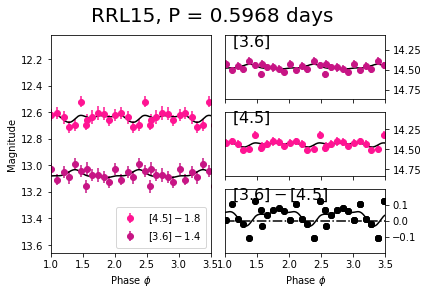

RRab
Channel 1 mags:  [15.77053705 15.7674642  15.93960602 15.93376283 15.8298617  15.95564944
 16.01310218 15.98082186 15.86551851 15.79486066 15.7203626  15.80394838]
Channel 2 mags:  [15.77987166 15.78652817 15.84657042 15.86402428 15.94194193 15.98751186
 16.02012993 15.97123529 15.90302303 15.86030602 15.83476132 15.77183569] 

RRL16 ---- Period = 0.5773 days
------------------------------------------------------
12 12
<[3.6]> = 15.877    std dev = 0.078     amplitude = 0.242


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.891    std dev = 0.077     amplitude = 0.221
<[3.6] - [4.5]> = -0.014    std dev = 0.039     amplitude = 0.131


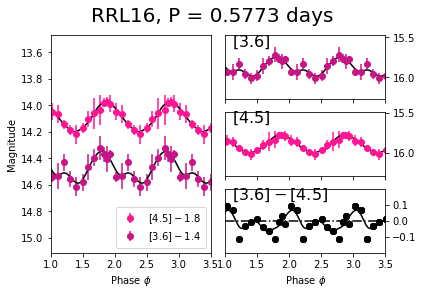

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957]
new error ch1: 0.02016614829715957
new error ch2: 0.01840078415101794



RRab
Channel 1 mags:  [99.         15.70130647 15.95722927 15.8817414  99.         99.
 15.76196144 15.77563737 99.         15.81073479 99.         99.        ]
Channel 2 mags:  [15.79233372 99.         99.         99.         99.         15.77113872
 99.         15.8063084  15.77134057 15.7652823  15.80567104 15.77465599] 

RRL17 ---- Period = 0.5005 days
------------------------------------------------------
6 7


C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 15.812    std dev = 0.051     amplitude = 0.144
<[4.5]> = 15.781    std dev = 0.009     amplitude = 0.031
Channels don't have the same number of measurements, so colour curve couldn't be plotted


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


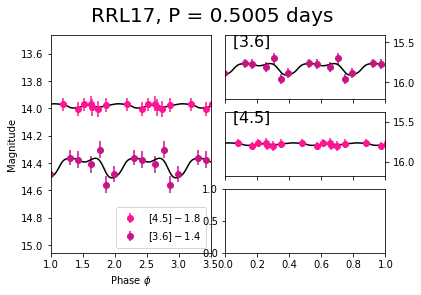

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, 0.016990364836735085]
new error ch1: 0.016990364836735085
new error ch2: 0.003364086803873276



RRd
Channel 1 mags:  [16.07735712 16.11826434 16.13060525 16.02444404 16.00208707 16.00887491
 15.89116834 16.11006869 16.01978221 16.16745173 16.07040323 15.93443986]
Channel 2 mags:  [16.02632857 16.00067997 16.18326305 16.09985978 15.94018681 15.94886527
 15.92988911 15.95008401 16.05612984 16.08631557 15.97723875 15.98897822] 

RRL18 ---- Period = 0.3523 days
------------------------------------------------------
12 12
<[3.6]> = 16.034    std dev = 0.057     amplitude = 0.164
<[4.5]> = 16.010    std dev = 0.053     amplitude = 0.158

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



<[3.6] - [4.5]> = 0.024    std dev = 0.031     amplitude = 0.104


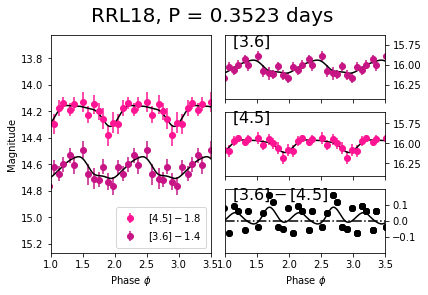

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019]
new error ch1: 0.013631998508266019
new error ch2: 0.013131574007811805



RRab
Channel 1 mags:  [16.28592702 16.11200813 15.99539348 15.99243616 15.89638505 16.02035399
 15.97722936 16.0586189  16.09434212 15.91782652 16.20195101 15.9586876 ]
Channel 2 mags:  [16.25743206 16.23255992 16.19655849 15.98278664 15.94133423 15.86636645
 15.87186192 16.0420035  15.94753548 15.96033159 16.24355203 16.20032595] 

RRL19 ---- Period = 0.5306 days
------------------------------------------------------
12 12
<[3.6]> = 16.028    std dev = 0.060     amplitude = 0.191


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 16.029    std dev = 0.120     amplitude = 0.358
<[3.6] - [4.5]> = -0.001    std dev = 0.096     amplitude = 0.285


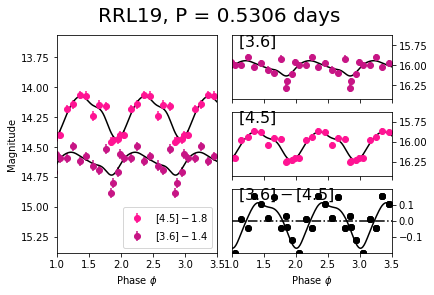

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143]
new error ch1: 0.015935665113477143
new error ch2: 0.02979787873573425



RRab
Channel 1 mags:  [15.76265842 15.84605193 15.68654859 15.76859427 15.65332493 15.87566882
 15.75941451 15.95880647 16.13019289 15.97649264 15.98498934 15.97177793]
Channel 2 mags:  [17.20397359 16.9963746  17.21233183 17.01461615 17.01134934 17.10038591
 16.98383462 17.11023256 16.90226702 17.0363812  16.96471578 17.19546   ] 

RRL20 ---- Period = 0.6482 days
------------------------------------------------------
12 12
<[3.6]> = 15.857    std dev = 0.116     amplitude = 0.333


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 17.055    std dev = 0.042     amplitude = 0.144
<[3.6] - [4.5]> = -1.198    std dev = 0.140     amplitude = 0.396


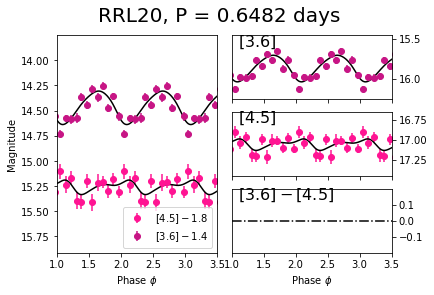

RRd
Channel 1 mags:  [16.02175483 16.15185426 16.23075773 16.31684879 16.14484101 16.13918879
 16.03642926 16.20688523 16.1260963  16.13222399 16.12050561 16.19629984]
Channel 2 mags:  [16.2256924  16.16353843 16.12564975 16.05284932 16.082998   16.05311107
 16.01030431 16.08816214 15.9611192  16.03224731 16.11163984 16.17860122] 

RRL21 ---- Period = 0.3533 days
------------------------------------------------------
12 12


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[3.6]> = 16.142    std dev = 0.046     amplitude = 0.148
<[4.5]> = 16.085    std dev = 0.022     amplitude = 0.070
<[3.6] - [4.5]> = 0.057    std dev = 0.059     amplitude = 0.188


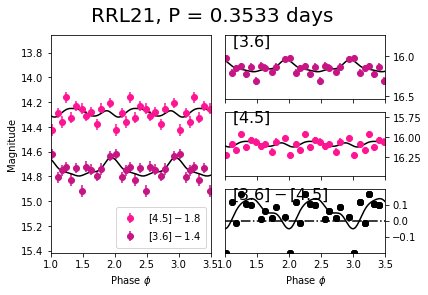

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366]
new error ch1: 0.012358852875342366
new error ch2: 0.005847356093989416



RRab
Channel 1 mags:  [16.45002514 16.46959824 16.5568807  16.50527014 16.46246809 16.53885453
 16.43709203 16.48629472 16.462642   16.36308576 16.54256596 16.65217959]
Channel 2 mags:  [] 

RRL22 ---- Period = 0.6747 days
------------------------------------------------------
12 0


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[3.6]> = 16.495    std dev = 0.033     amplitude = 0.123
Channels don't have the same number of measurements, so colour curve couldn't be plotted


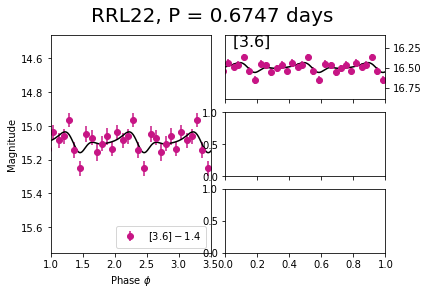

RRab
Channel 1 mags:  [16.17617653 16.14464581 16.08683989 15.95471747 15.91349249 16.0009054
 15.92318156 16.0817096  16.10294641 16.04404961 16.14824257 16.10517928]
Channel 2 mags:  [16.06883456 16.16183955 15.92836989 15.78866142 15.91900852 15.89024843
 15.87562451 15.8894838  16.05359232 16.12969128 16.14605557 16.06212166] 

RRL23 ---- Period = 0.5077 days
------------------------------------------------------
12 12
<[3.6]> = 16.039    std dev = 0.072     amplitude = 0.202


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.969    std dev = 0.097     amplitude = 0.266
<[3.6] - [4.5]> = 0.069    std dev = 0.034     amplitude = 0.110


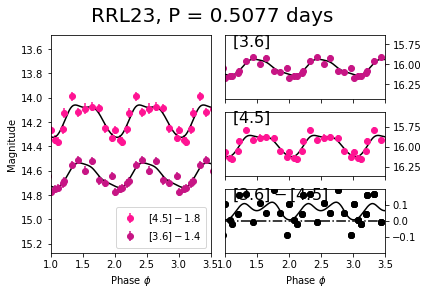

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719]
new error ch1: 0.01684938417110719
new error ch2: 0.022165795155387524



RRab
Channel 1 mags:  [14.8847494  14.9666936  14.97961563 14.97920038 14.90737873 14.83589214
 15.03393276 14.92089428 14.9733732  14.86985507 14.88393348 14.87844624]
Channel 2 mags:  [14.93303741 15.0516185  15.04715282 15.0127763  14.9231139  14.97989896
 15.04189793 14.99941915 14.9992765  14.9579707  14.87633788 14.87610443] 

RRL24 ---- Period = 0.5166 days
------------------------------------------------------
12 12
<[3.6]> = 14.930    std dev = 0.027     amplitude = 0.089
<[4.5]> = 14.967    std dev = 0.030     am

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


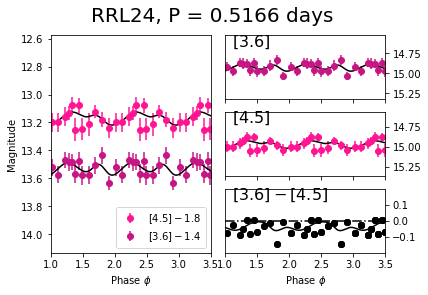

RRab
Channel 1 mags:  [99.         15.69962267 15.74928898 15.66606431 99.         15.63511391
 15.73881422 15.63284513 15.76485288 15.77880757 15.62817766 15.85986978]
Channel 2 mags:  [15.83536925 15.92512779 15.70846746 15.63030661 15.64733412 15.61779887
 15.62536458 15.69908229 15.67434028 15.74049154 15.75355783 15.83573223] 

RRL25 ---- Period = 0.6022 days
------------------------------------------------------
10 12
<[3.6]> = 15.710    std dev = 0.033     amplitude = 0.103


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.714    std dev = 0.076     amplitude = 0.225
Channels don't have the same number of measurements, so colour curve couldn't be plotted


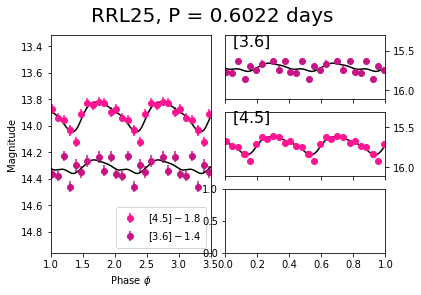

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076]
new error ch1: 0.009366173836899076
new error ch2: 0.018726279838450804



RRab
Channel 1 mags:  []
Channel 2 mags:  [] 

RRab
Channel 1 mags:  [15.95387412 15.98772608 15.9083224  15.96346818 15.91580267 15.99468315
 16.18493836 16.25093491 16.24635668 15.89840978 15.95293189 16.00145894]
Channel 2 mags:  [15.94410141 16.01662856 15.99125039 15.98910978 15.95392355 15.96398587
 15.93084424 16.10884465 16.19582228 16.02511219 15.98065287 15.89302687] 

RRL27 ---- Period = 0.5068 days
------------------------------------------------------
12 12
<[3.6]> = 16.036    std d

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 16.002    std dev = 0.057     amplitude = 0.174
<[3.6] - [4.5]> = 0.034    std dev = 0.075     amplitude = 0.228


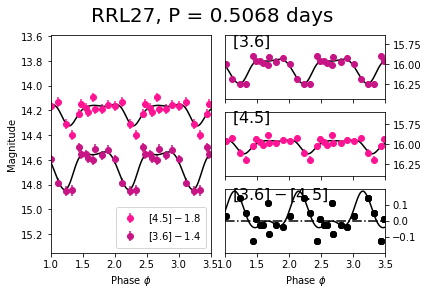

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902]
new error ch1: 0.02541749839552902
new error ch2: 0.014474421280207187



RRab
Channel 1 mags:  [15.80539588 15.91929083 15.94117517 15.90097661 15.84581074 15.92257027
 15.94668713 15.99402248 16.13890585 16.05448468 15.77856847 15.77623458]
Channel 2 mags:  [15.85470314 15.96238249 15.91514627 15.86514319 15.8829444  15.94214037
 16.00471124 16.01811458 16.17799514 16.04375263 15.85612752 15.81141378] 

RRL28 ---- Period = 0.5828 days
------------------------------------------------------
12 12
<[3.6]> = 15.928    std dev = 0.070     amplitu

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.947    std dev = 0.074     amplitude = 0.219
<[3.6] - [4.5]> = -0.018    std dev = 0.019     amplitude = 0.063


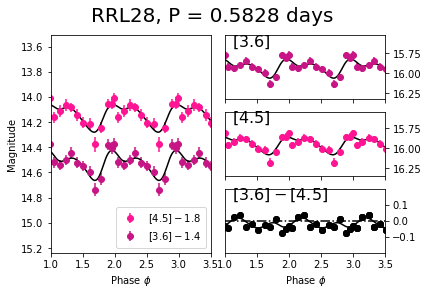

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207]
new error ch1: 0.019855329762522207
new error ch2: 0.018234192063667127



RRc
Channel 1 mags:  [14.39806078 14.4305327  14.41957899 14.36853694 14.45592866 14.41440762
 14.40360084 14.38278301 14.33073535 14.43899982 14.41227786 14.44705357]
Channel 2 mags:  [14.38093765 14.37596354 14.42598346 14.40323738 14.40904117 14.39950122
 14.38967799 14.44059398 14.46709075 14.45155907 14.44148721 14.4050031 ] 

RRL29 ---- Period = 0.3627 days
------------------------------------------------------
12 12
<[3.6]> = 14.410    std d

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 14.414    std dev = 0.017     amplitude = 0.049
<[3.6] - [4.5]> = -0.003    std dev = 0.024     amplitude = 0.072


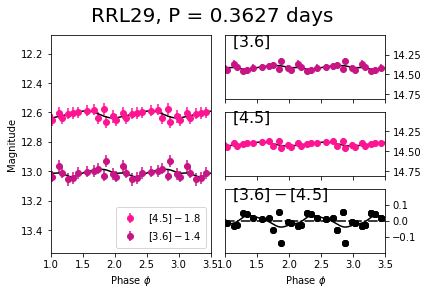

RRab
Channel 1 mags:  [15.97025726 15.95140177 16.04741672 16.15890477 15.92648448 15.86141791
 15.82823838 15.89946849 15.96382094 15.85076061 15.94037749 15.92628286]
Channel 2 mags:  [15.90692868 15.93870751 15.95557797 16.03397121 16.07360269 15.75089831
 15.82013524 15.94265569 15.93733676 99.         15.91880692 15.99558284] 

RRL30 ---- Period = 0.5289 days
------------------------------------------------------
12 11


C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 15.938    std dev = 0.066     amplitude = 0.218
<[4.5]> = 15.930    std dev = 0.061     amplitude = 0.220


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Channels don't have the same number of measurements, so colour curve couldn't be plotted


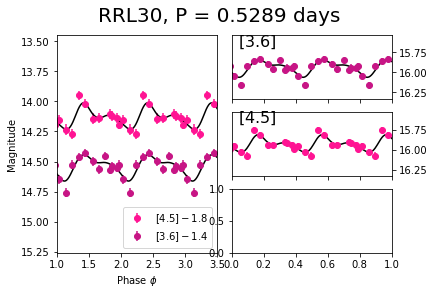

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, nan, 0.01819808922893218]
new error ch1: 0.01819808922893218
new error ch2: 0.019174929170803608



RRd
Channel 1 mags:  [16.07596155 16.06731295 16.04763071 16.11044678 16.13101227 16.19300924
 16.20405106 16.18921179 16.27798212 16.16508645 16.16503211 16.13787983]
Channel 2 mags:  [16.26170077 16.18809477 16.15384613 16.1848427  16.08297992 16.15241579
 16.27378385 16.30968495 16.24014367 16.08116679 16.18741658 16.20010774] 

RRL31 ---- Period = 0.3617 days
------------------------------------------------------
12 12


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 16.188    std dev = 0.053     amplitude = 0.154
<[3.6] - [4.5]> = -0.039    std dev = 0.050     amplitude = 0.152


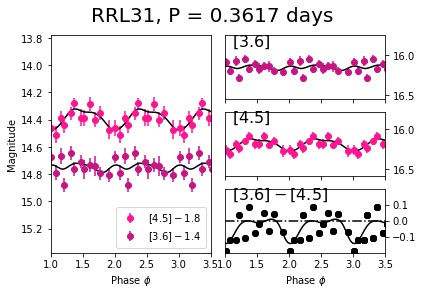

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, nan, 0.01819808922893218, 0.005592642297243285]
new error ch1: 0.005592642297243285
new error ch2: 0.012804471036175435



RRc
Channel 1 mags:  [15.16776336 15.39708943 15.37522943 15.27670246 15.28802723 15.14094462
 15.30317496 15.35586643 15.35406828 15.36869481 15.37833263 15.34242649]
Channel 2 mags:  [15.30969838 15.33203024 15.34041188 15.37788843 15.32300997 15.25919127
 15.22153462 15.29754315 15.34548996 15.24925459 15.300623   15.37294394] 

RRL32 ---- Period = 0.36 days
----------------------------------------

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.305    std dev = 0.027     amplitude = 0.083
<[3.6] - [4.5]> = 0.001    std dev = 0.034     amplitude = 0.107


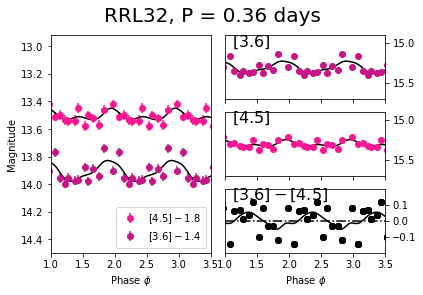

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, nan, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623]
new error ch1: 0.01246905584316623
new error ch2: 0.006955133630885217



RRab
Channel 1 mags:  []
Channel 2 mags:  [] 

RRab
Channel 1 mags:  [15.97988845 16.15073737 16.29583087 16.1781573  16.35742392 16.1205889
 16.02761412 15.94190527 15.91750876 16.1301271  15.94594196 16.06103249]
Channel 2 mags:  [16.06109544 16.12353543 16.1396938  16.3240075  16.3469577  16.17813223
 15.97557952 16.00623463 16.03918909 16.15013134 16.08228352 16.04245704] 

RRL

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[3.6] - [4.5]> = -0.041    std dev = 0.031     amplitude = 0.104


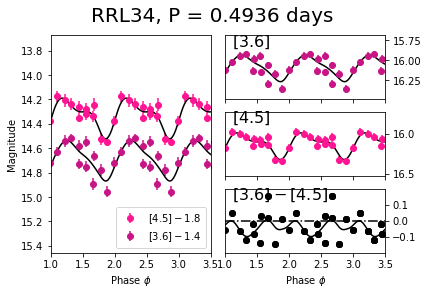

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, nan, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106]
new error ch1: 0.02764399924573106
new error ch2: 0.027818886560578477



RRab
Channel 1 mags:  [15.66933892 15.57136231 99.         15.65802211 99.         15.72534349
 15.77764695 99.         15.61772908 15.62697717 15.48417989 15.5812578 ]
Channel 2 mags:  [15.61068108 15.52381405 15.63823519 15.61255174 15.6955665  15.77290169
 15.74389445 15.76316602 15.65253768 15.57023174 15.56244993 15.61898462] 

RRL35 ---- Period = 0.6

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 15.644    std dev = 0.061     amplitude = 0.195


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.648    std dev = 0.066     amplitude = 0.182
Channels don't have the same number of measurements, so colour curve couldn't be plotted


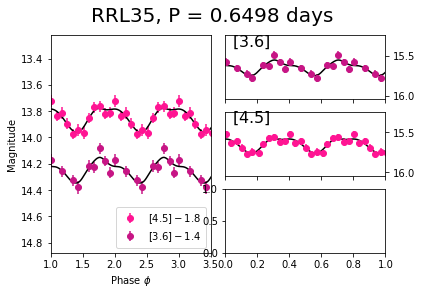

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, nan, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126]
new error ch1: 0.01871798176793126
new error ch2: 0.015188076796218475



RRab
Channel 1 mags:  [15.97357136 15.90599355 15.90456586 15.98360981 15.90671505 16.06458135
 16.24966606 15.97413249 15.86283287 15.81472097 15.87740582 15.82906992]
Channel 2 mags:  [15.85702902 15.79877882 15.87787708 99.         15.98293658 16.03399395
 16.1501752  15.9907788  15.82491547 15.84467278 15.75005916 15.8324601 ] 

RR

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 15.940    std dev = 0.081     amplitude = 0.275


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.903    std dev = 0.087     amplitude = 0.249
Channels don't have the same number of measurements, so colour curve couldn't be plotted


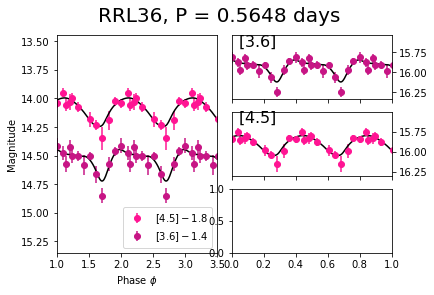

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, nan, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747]
new error ch1: 0.022957344928941747
new error ch2: 0.02164675419614831



RRab
Channel 1 mags:  [15.83111498 15.85749669 15.98519357 16.00203594 15.97752274 16.05446752
 15.95251833 15.86777475 15.8006041  15.77401312 15.82193415 15.80843883]
Channel 2 mags:  [15.80789687 15.83681441 15.83849566 15.86223482 15.8606728  16.02256729
 15.80072402 15.81978603 15.76254367 15.71528749 15.7436

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.822    std dev = 0.058     amplitude = 0.178
<[3.6] - [4.5]> = 0.078    std dev = 0.029     amplitude = 0.091


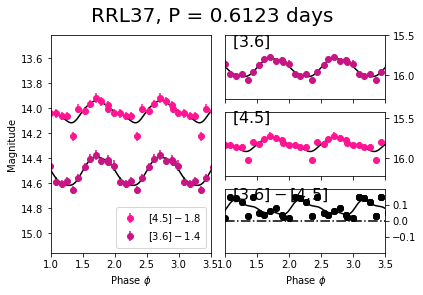

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, nan, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416]
new error ch1: 0.018725618383013416
new error ch2: 0.014858072864653534



RRab
Channel 1 mags:  []
Channel 2 mags:  [] 

RRab
Channel 1 mags:  [15.8317743  15.80978728 15.83315739 15.72685108 15.82916105 15.88124492
 15.91467411 16.0590859  16.04551271 15.82443524 15.74608172 15.8092162 ]
Channel 2 mags:  [15.72321813 15.80821513 15.78055972 15.85148049 15.8191196

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.862    std dev = 0.052     amplitude = 0.163
<[3.6] - [4.5]> = 0.009    std dev = 0.046     amplitude = 0.145


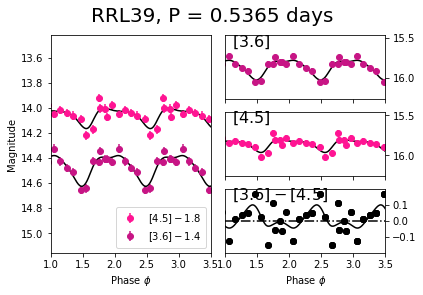

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, nan, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545]
new error ch1: 0.020445225143792545
new error ch2: 0.013573617713134775



RRd
Channel 1 mags:  [17.24771252 17.33637531 99.         99.         99.         16.53051947
 16.38332599 17.51542768 99.         16.42704945 99.         17.36206515]
Channel 2 mags:  [99.         17.55785941 99.         17.38240483 17.38743916 99.
 99.         17

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[3.6]> = 16.831    std dev = 0.332     amplitude = 1.029
<[4.5]> = 17.405    std dev = 0.032     amplitude = 0.133
Channels don't have the same number of measurements, so colour curve couldn't be plotted


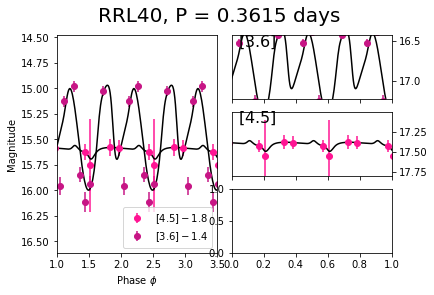

RRab
Channel 1 mags:  []
Channel 2 mags:  [] 

RRab
Channel 1 mags:  [14.70788894 14.81568745 14.76411963 14.68279937 14.78648506 14.65489477
 14.74636727 14.69054285 14.73948173 14.70929989 14.77927021 14.74152668]
Channel 2 mags:  [14.57470855 14.50099609 14.50142862 14.52531272 14.53975509 14.58148106
 14.53323711 14.58077105 14.57226101 14.56830434 14.51183585 14.51448228] 

RRL42 ---- Period = 0.5254 days
------------------------------------------------------
12 12
<[3.6]> = 14.730    std dev = 0.020     amplitude = 0.061


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 14.546    std dev = 0.023     amplitude = 0.071
<[3.6] - [4.5]> = 0.185    std dev = 0.042     amplitude = 0.123


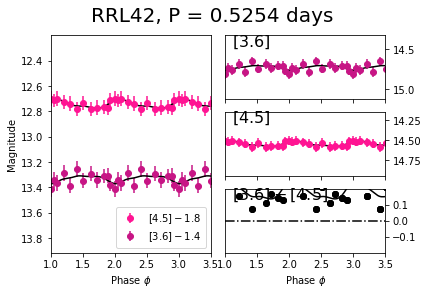

RRab
Channel 1 mags:  []
Channel 2 mags:  [] 

RRab
Channel 1 mags:  []
Channel 2 mags:  [17.73411079 15.94072604 16.0758434  16.17007593 15.80151541 17.8712648
 15.80308531 15.77930492 15.74004876 15.88156317 15.85002115 16.41619445] 

RRL44 ---- Period = 0.5599 days
------------------------------------------------------
0 12


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.940    std dev = 0.133     amplitude = 0.374
Channels don't have the same number of measurements, so colour curve couldn't be plotted


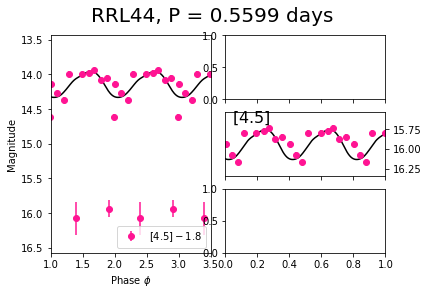

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, nan, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan]
new error ch1: nan
new error ch2: 0.03118914559677736



RRab
Channel 1 mags:  [15.9288828  15.89522965 16.02898789 16.00918344 16.04507279 16.01712176
 15.89275189 15.8699589  15.86902281 15.7053566  15.86182734 15.92202804]
Channel 2 mags:  [15.7569994  15.87603073 15.88381047 15.96087481 15.97302714 15.84543989

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.861    std dev = 0.046     amplitude = 0.140
<[3.6] - [4.5]> = 0.059    std dev = 0.053     amplitude = 0.170


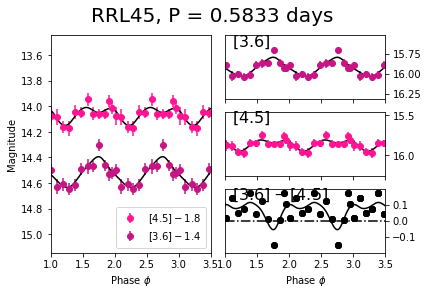

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, nan, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092]
new error ch1: 0.01997602667697092
new error ch2: 0.011689666638514229



RRab
Channel 1 mags:  [15.90471382 15.88221571 16.01548619 15.9398041  16.08926941 16.09322091
 16.01604698 16.17681163 16.06544803 16.03788133 15.93303237 15.85941603]
Channel 2 mags:  [15.83515834 16.04089839 15.979486

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.998    std dev = 0.082     amplitude = 0.273
<[3.6] - [4.5]> = 0.020    std dev = 0.043     amplitude = 0.134


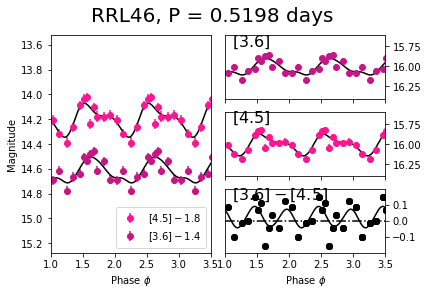

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, nan, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, 0.017381312301694745]
new error ch1: 0.017381312301694745
new error ch2: 0.022787544008592953



RRab
Channel 1 mags:  [16.07025425 16.12910685 16.07091523 16.07488746 16.17250724 15.91816459
 16.05563539 16.02433611 16.00992125 15.98581279 16.02457067 16.09299816]
Channel 2 mags:  [16.0102934

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[3.6]> = 16.048    std dev = 0.036     amplitude = 0.106
<[4.5]> = 16.033    std dev = 0.056     amplitude = 0.163
Channels don't have the same number of measurements, so colour curve couldn't be plotted


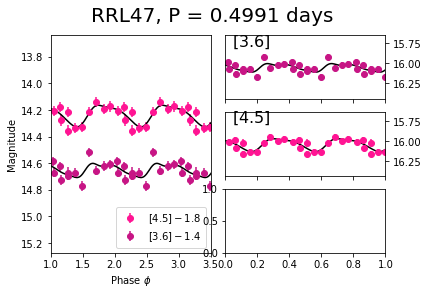

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, nan, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268]
new error ch1: 0.008871178682373268
new error ch2: 0.014174223551094628



RRab
Channel 1 mags:  [15.80027791 99.         15.97115833 15.74125266 15.79513887 15.87820864
 16.35627622 99.         15.65471656 15.86034004 15.74792846 15.80463547]
Channe

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)
C:\Users\Jake\MPhys-code\MPhys-RRL\final_scripts\gloess_fits.py:69: RuntimeWarning: invalid value encountered in sqrt
  sigma_c3=np.sqrt(ai33)
C:\Users\Jake\MPhys-code\MPhys-RRL\final_scripts\gloess_fits.py:67: RuntimeWarning: invalid value encountered in sqrt
  sigma_c1=np.sqrt(ai11)
C:\Users\Jake\MPhys-code\MPhys-RRL\final_scripts\gloess_fits.py:68: RuntimeWarning: invalid value encountered in sqrt
  sigma_c2=np.sqrt(ai22)
C:\Users\Jake\MPhys-code\MPhys-RRL\final_scripts\gloess_fits.py:51: RuntimeWarning: invalid value encountered in double_scalars
  ai11=cofa11/det
C:\Users\Jake\MPhys-code\MPhys-RRL\final_scripts\gloess_fits.py:52: RuntimeWarning: invalid value encountered in double_scalars
  ai12=cofa21/det
C:\Users\Jake\MPhys-code\MPhys-RRL\final_scripts\gloess_fits.py:53: RuntimeWarning: invalid value encountere

<[3.6]> = 15.844    std dev = 0.095     amplitude = 0.338
<[4.5]> = 15.948    std dev = 0.101     amplitude = 0.297
Channels don't have the same number of measurements, so colour curve couldn't be plotted


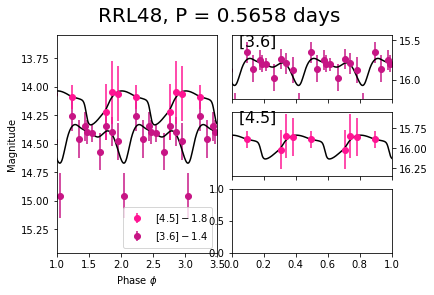

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, nan, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023]
new error ch1: 0.03083994437805023
new error ch2: 0.042936318545389



RRd
Channel 1 mags:  [14.53671039 14.71854115 14.64079964 15.56123745 14.59317661 14.62545162
 14.59519023 14.69335066 99.         15.59208749 14.81365743 15.

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 15.012    std dev = 0.294     amplitude = 0.888
<[4.5]> = 14.629    std dev = 0.015     amplitude = 0.058
Channels don't have the same number of measurements, so colour curve couldn't be plotted


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


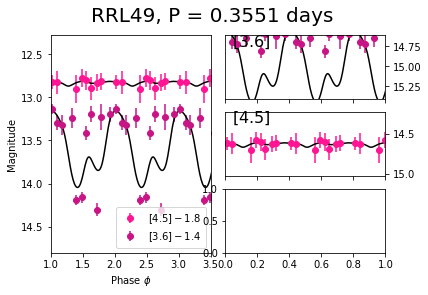

RRab
Channel 1 mags:  [16.00354504 16.07692224 16.0324734  16.10340186 15.85439123 15.99353532
 15.98494879 15.93412868 15.93862553 16.0170203  16.04561582 15.9357012 ]
Channel 2 mags:  [15.9767837  16.02554036 16.02261863 16.10442633 15.99131945 16.02998774
 15.90792241 15.95653034 16.0444405  15.87216005 15.91448227 16.01049553] 

RRL50 ---- Period = 0.5806 days
------------------------------------------------------
12 12
<[3.6]> = 15.991    std dev = 0.031     amplitude = 0.095
<[4.5]> = 15.990    std dev = 0.043     amplitude = 0.134


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[3.6] - [4.5]> = 0.001    std dev = 0.041     amplitude = 0.149


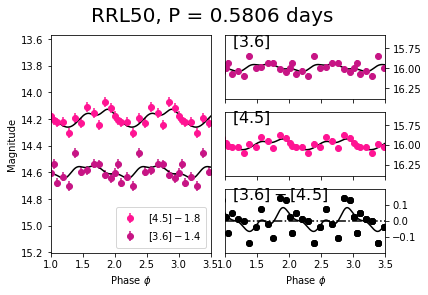

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, nan, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, nan, 0.007891469496489556]
new error ch1: 0.007891469496489556
new error ch2: 0.011171376290898186



RRab
Channel 1 mags:  [15.64577209 15.99093971 15.75101838 15.78715174 15.92555535 15.78285624
 16.35478792 15.91848182 15.8718

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 15.859    std dev = 0.096     amplitude = 0.316
<[4.5]> = 15.817    std dev = 0.081     amplitude = 0.268
Channels don't have the same number of measurements, so colour curve couldn't be plotted


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


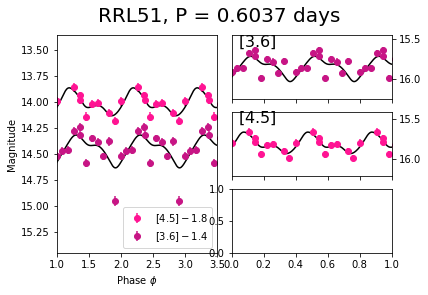

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, nan, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696]
new error ch1: 0.0263297047389696
new error ch2: 0.025807150919949257



RRab
Channel 1 mags:  []
Channel 2 mags:  [] 

RRc
Channel 1 mags:  [16.16892921 16.1824434  16.16806729 16.1

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 16.087    std dev = 0.039     amplitude = 0.105
<[3.6] - [4.5]> = 0.044    std dev = 0.048     amplitude = 0.148


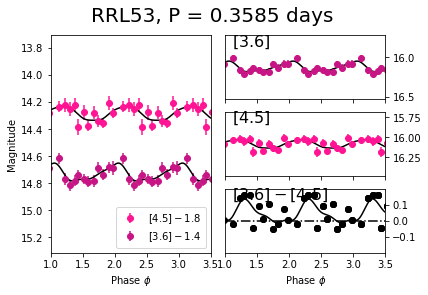

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, nan, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, 0.01098733661842092]
new error ch1: 0.01098733661842092
new error ch2: 0.00872163085435762



RRe (lol)
Channel 1 mags:  [14.73870222 14.78587739 14.87241117 14.79637679 14.7715

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 14.793    std dev = 0.012     amplitude = 0.038
<[3.6] - [4.5]> = 0.002    std dev = 0.034     amplitude = 0.109


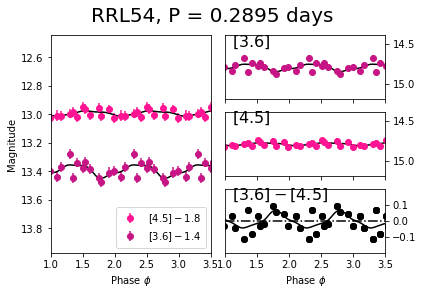

RRab
Channel 1 mags:  [15.92746372 15.9829601  99.         16.00415644 16.04795745 16.0113485
 16.1617025  99.         16.07058275 16.06891149 16.07940812 15.99071253]
Channel 2 mags:  [15.98900486 15.97788969 15.95152677 15.90843426 15.99494294 16.02351558
 16.03279446 99.         99.         15.93219125 15.91078901 15.98678243] 

RRL55 ---- Period = 0.5199 days
------------------------------------------------------
10 10


C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 16.045    std dev = 0.045     amplitude = 0.137
<[4.5]> = 15.977    std dev = 0.032     amplitude = 0.090


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[3.6] - [4.5]> = 0.068    std dev = 0.028     amplitude = 0.087


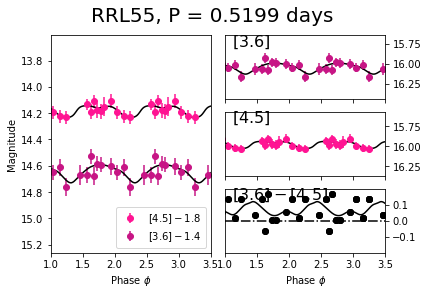

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, nan, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, 0.01098733661842092, nan, 0.012469913349568047]
new error ch1: 0.012469913349568047
new error ch2: 0.008258298137844603



RRab
Channel 1 mags:  [15.8288475  15.98132427 16.1080

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.972    std dev = 0.047     amplitude = 0.145
<[3.6] - [4.5]> = 0.009    std dev = 0.040     amplitude = 0.135


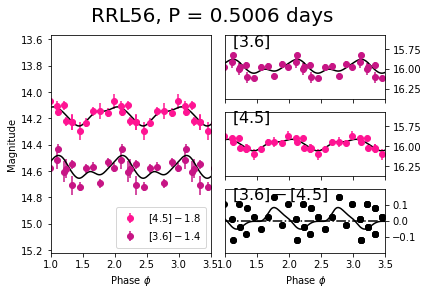

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, nan, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, 0.01098733661842092, nan, 0.012469913349568047, 0.01441594851329612]
new error ch1: 0.01441594851329612
new error ch2: 0.012081822523256106



RRd
Channel 1 mags:  [12.62294119 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 12.623    std dev = 0.032     amplitude = 0.106
<[3.6] - [4.5]> = -0.018    std dev = 0.031     amplitude = 0.115


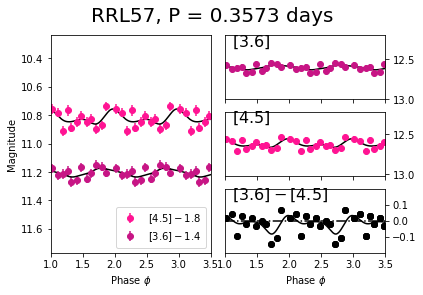

RRab
Channel 1 mags:  [15.86643697 15.85072469 99.         15.86179446 16.02760624 16.02112576
 16.17544594 15.97001423 15.86925858 15.9375003  15.93001863 15.8905434 ]
Channel 2 mags:  [15.79617168 15.91819048 15.87073879 99.         15.94001394 15.94148497
 15.93389926 15.95681672 15.83758066 15.84997324 99.         15.83765693] 

RRL58 ---- Period = 0.5467 days
------------------------------------------------------
11 10


C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 15.939    std dev = 0.065     amplitude = 0.197
<[4.5]> = 15.889    std dev = 0.044     amplitude = 0.125
Channels don't have the same number of measurements, so colour curve couldn't be plotted


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


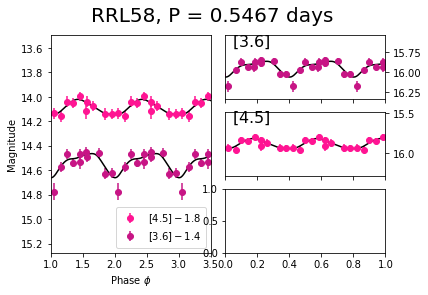

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, nan, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, 0.01098733661842092, nan, 0.012469913349568047, 0.01441594851329612, nan, 0.017151602859603626]
new error ch1: 0.017151602859603626
new error ch2: 0.011426306954582896



RRab
C

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 16.162    std dev = 0.087     amplitude = 0.245
<[4.5]> = 16.138    std dev = 0.056     amplitude = 0.160
Channels don't have the same number of measurements, so colour curve couldn't be plotted

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


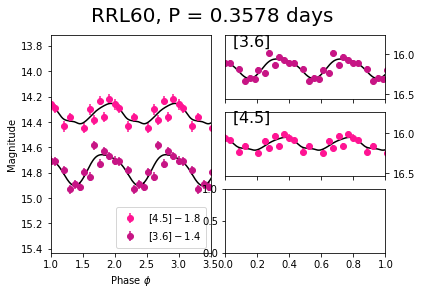

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, nan, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, 0.01098733661842092, nan, 0.012469913349568047, 0.01441594851329612, nan, 0.017151602859603626, nan, 0.020382889740956738]
new error ch1: 0.020382889740956738
new error ch2: 0.0

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[3.6]> = 15.874    std dev = 0.054     amplitude = 0.179
<[4.5]> = 15.809    std dev = 0.109     amplitude = 0.328
Channels don't have the same number of measurements, so colour curve couldn't be plotted


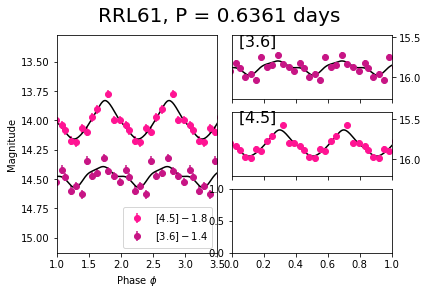

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, nan, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, 0.01098733661842092, nan, 0.012469913349568047, 0.01441594851329612, nan, 0.017151602859603626, nan, 0.020382889740956738, 0.014927759422480738]
new error ch1: 0.014927759422480

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[3.6]> = 16.166    std dev = 0.055     amplitude = 0.151
<[4.5]> = 16.162    std dev = 0.011     amplitude = 0.038
<[3.6] - [4.5]> = 0.003    std dev = 0.049     amplitude = 0.141


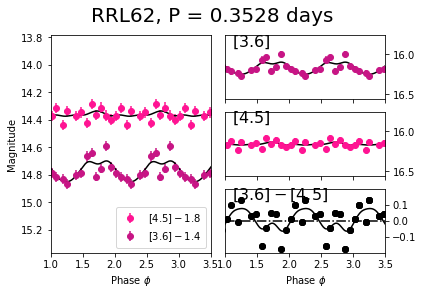

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, nan, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, 0.01098733661842092, nan, 0.012469913349568047, 0.01441594851329612, nan, 0.017151602859603626, nan, 0.020382889740956738, 0.014927759422480738, 0.012620808577274248]
new error 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[3.6]> = 15.846    std dev = 0.075     amplitude = 0.214
<[4.5]> = 15.793    std dev = 0.095     amplitude = 0.276
<[3.6] - [4.5]> = 0.052    std dev = 0.072     amplitude = 0.226


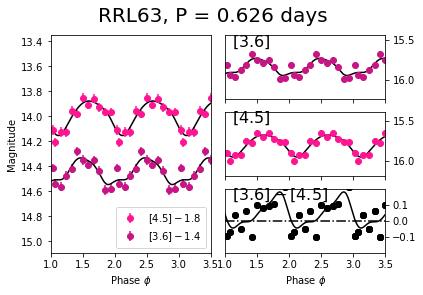

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, nan, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, 0.01098733661842092, nan, 0.012469913349568047, 0.01441594851329612, nan, 0.017151602859603626, nan, 0.020382889740956738, 0.014927759422480738, 0.012620808577274248, 0.01779479

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 16.269    std dev = 0.052     amplitude = 0.161
<[3.6] - [4.5]> = 0.017    std dev = 0.121     amplitude = 0.355


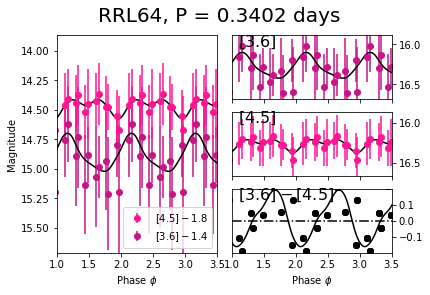

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, nan, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, 0.01098733661842092, nan, 0.012469913349568047, 0.01441594851329612, nan, 0.017151602859603626, nan, 0.020382889740956738, 0.014927759422480738, 0.012620808577274248, 0.01779479

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 15.757    std dev = 0.066     amplitude = 0.196
<[4.5]> = 15.733    std dev = 0.078     amplitude = 0.238

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Channels don't have the same number of measurements, so colour curve couldn't be plotted


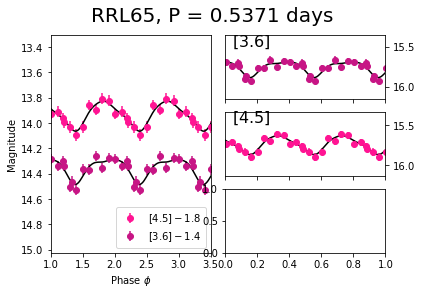

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, nan, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, 0.01098733661842092, nan, 0.012469913349568047, 0.01441594851329612, nan, 0.017151602859603626, nan, 0.020382889740956738, 0.014927759422480738, 0.012620808577274248, 0.01779479

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 14.429    std dev = 0.010     amplitude = 0.034
<[3.6] - [4.5]> = 0.006    std dev = 0.031     amplitude = 0.104


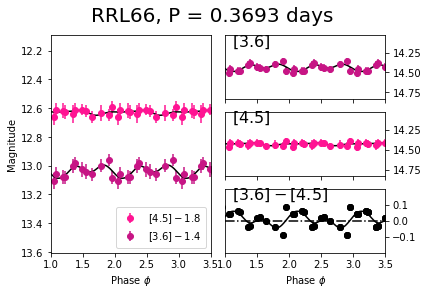

RRab
Channel 1 mags:  [15.77334344 15.61833597 15.64287169 15.61270319 15.61980993 15.64831697
 15.73590331 15.72820434 15.85692424 15.70878307 15.81058773 15.74376852]
Channel 2 mags:  [15.651864   15.61785116 15.57811647 15.65027495 15.55395563 15.59152902
 15.58676013 15.57591594 15.64467736 15.77791835 15.7203937  15.69620816] 

RRL67 ---- Period = 0.6814 days
------------------------------------------------------
12 12
<[3.6]> = 15.708    std dev = 0.062     amplitude = 0.166
<[4.5]> = 15.637    std dev = 0.049     amplitude = 0.146


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[3.6] - [4.5]> = 0.071    std dev = 0.042     amplitude = 0.140


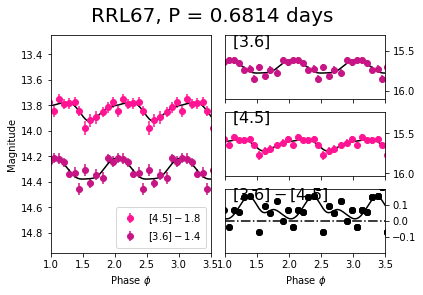

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, nan, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, 0.01098733661842092, nan, 0.012469913349568047, 0.01441594851329612, nan, 0.017151602859603626, nan, 0.020382889740956738, 0.014927759422480738, 0.012620808577274248, 0.01779479

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 15.869    std dev = 0.084     amplitude = 0.259


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 13.480    std dev = 0.095     amplitude = 0.305
Channels don't have the same number of measurements, so colour curve couldn't be plotted


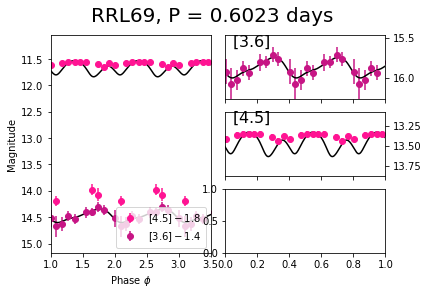

RRab
Channel 1 mags:  [15.92950012 15.90610439 15.94192718 15.9125914  15.87303347 15.74008777
 15.75632822 15.82417552 15.66974507 15.78542276 15.87386579 15.85328103]
Channel 2 mags:  [] 

RRL70 ---- Period = 0.6383 days
------------------------------------------------------
12 0


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[3.6]> = 15.836    std dev = 0.068     amplitude = 0.187
Channels don't have the same number of measurements, so colour curve couldn't be plotted


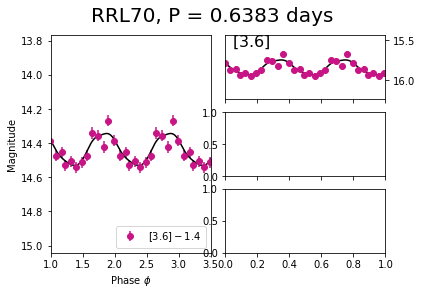

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, nan, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, 0.01098733661842092, nan, 0.012469913349568047, 0.01441594851329612, nan, 0.017151602859603626, nan, 0.020382889740956738, 0.014927759422480738, 0.012620808577274248, 0.01779479

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



<[3.6] - [4.5]> = 0.064    std dev = 0.028     amplitude = 0.090


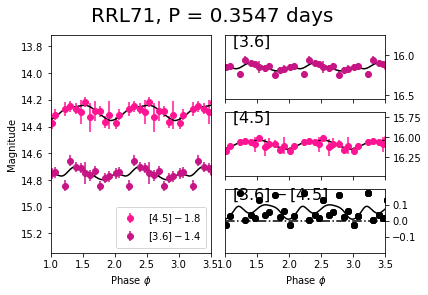

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, nan, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, 0.01098733661842092, nan, 0.012469913349568047, 0.01441594851329612, nan, 0.017151602859603626, nan, 0.020382889740956738, 0.014927759422480738, 0.012620808577274248, 0.01779479

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[3.6]> = 16.166    std dev = 0.092     amplitude = 0.308
<[4.5]> = 16.214    std dev = 0.065     amplitude = 0.204
Channels don't have the same number of measurements, so colour curve couldn't be plotted


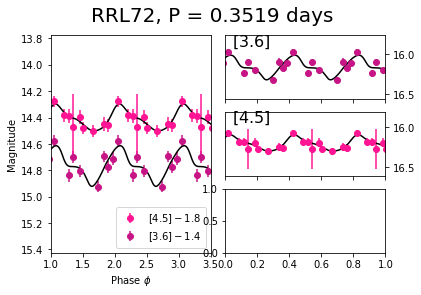

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, nan, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, 0.01098733661842092, nan, 0.012469913349568047, 0.01441594851329612, nan, 0.017151602859603626, nan, 0.020382889740956738, 0.014927759422480738, 0.012620808577274248, 0.01779479

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[3.6]> = 14.399    std dev = 0.017     amplitude = 0.057
<[4.5]> = 14.399    std dev = 0.014     amplitude = 0.039
<[3.6] - [4.5]> = 0.000    std dev = 0.024     amplitude = 0.077


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


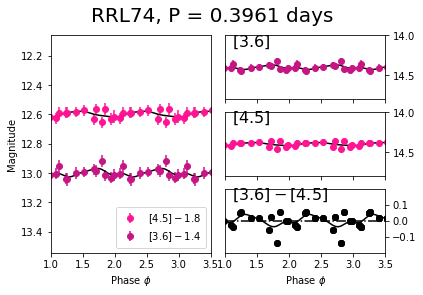

RRab
Channel 1 mags:  [10.00891254  9.88765471 10.02052589 10.07054205 10.09476473 10.08329611
  9.98865344  9.96449517  9.88754095  9.95571898  9.9820143   9.90894379]
Channel 2 mags:  [ 9.98926337  9.70928557  9.87986724  9.89584076  9.93311875  9.83925872
 10.04055563  9.9624856  10.0702313   9.82224266  9.88100526  9.87688587] 

RRL75 ---- Period = 0.5427 days
------------------------------------------------------
12 12
<[3.6]> = 9.993    std dev = 0.056     amplitude = 0.162


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 9.910    std dev = 0.051     amplitude = 0.167
<[3.6] - [4.5]> = 0.082    std dev = 0.082     amplitude = 0.253


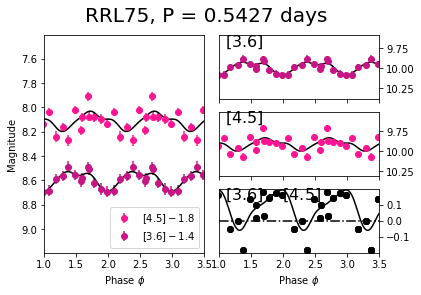

RRab
Channel 1 mags:  [11.8229789  11.78480502 11.82266724 11.80269249 11.80212524 11.7442593
 11.757945   11.79753869 11.76620183 11.80685355 11.73951177 11.78165821]
Channel 2 mags:  [11.80390446 11.75769623 11.77769737 11.77864597 11.79840286 11.82326656
 11.72074683 11.73142342 11.79490904 11.80027429 11.84391343 11.73794381] 

RRL76 ---- Period = 0.6275 days
------------------------------------------------------
12 12
<[3.6]> = 11.786    std dev = 0.015     amplitude = 0.048
<[4.5]> = 11.782    std dev = 0.017     amplitude = 0.062


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[3.6] - [4.5]> = 0.003    std dev = 0.023     amplitude = 0.076


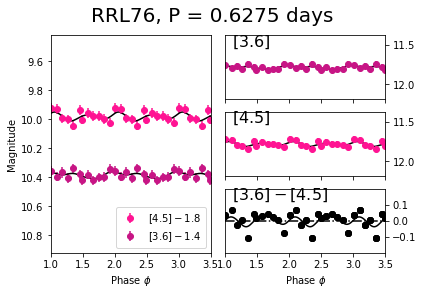

RRab
Channel 1 mags:  [15.6466253  15.65569297 15.42878407 15.63541598 15.58385876 15.6220307
 15.4414002  15.58470832 15.53186891 15.68189214 15.63877679 15.6773734 ]
Channel 2 mags:  [15.64987111 15.69189788 15.68660231 15.60104954 15.52146777 15.48400644
 15.45601853 15.50479025 15.60639716 15.47316602 15.61035142 15.62714107] 

RRL77 ---- Period = 0.7359 days
------------------------------------------------------
12 12
<[3.6]> = 15.600    std dev = 0.048     amplitude = 0.141


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.580    std dev = 0.069     amplitude = 0.203
<[3.6] - [4.5]> = 0.021    std dev = 0.060     amplitude = 0.186


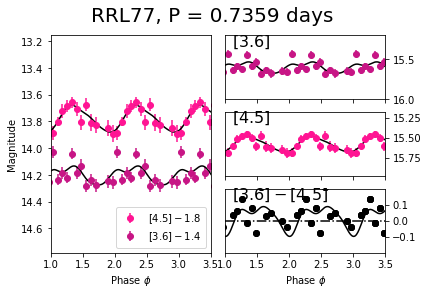

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, nan, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, 0.01098733661842092, nan, 0.012469913349568047, 0.01441594851329612, nan, 0.017151602859603626, nan, 0.020382889740956738, 0.014927759422480738, 0.012620808577274248, 0.01779479

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.209    std dev = 0.026     amplitude = 0.076
<[3.6] - [4.5]> = 0.010    std dev = 0.034     amplitude = 0.099


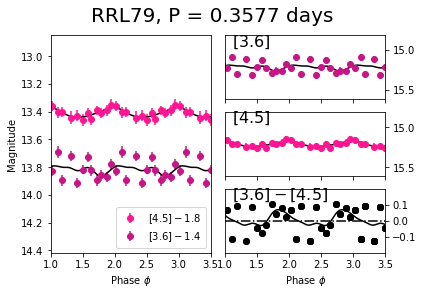

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, nan, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, 0.01098733661842092, nan, 0.012469913349568047, 0.01441594851329612, nan, 0.017151602859603626, nan, 0.020382889740956738, 0.014927759422480738, 0.012620808577274248, 0.01779479

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 16.086    std dev = 0.026     amplitude = 0.083
<[3.6] - [4.5]> = 0.068    std dev = 0.037     amplitude = 0.117


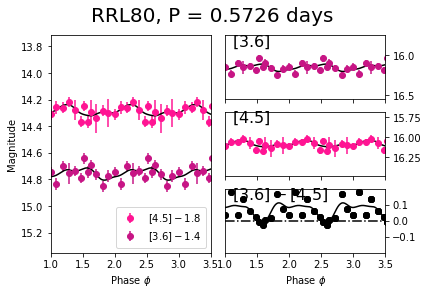

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, nan, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, 0.01098733661842092, nan, 0.012469913349568047, 0.01441594851329612, nan, 0.017151602859603626, nan, 0.020382889740956738, 0.014927759422480738, 0.012620808577274248, 0.01779479

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[3.6]> = 16.032    std dev = 0.059     amplitude = 0.157
<[4.5]> = 15.972    std dev = 0.042     amplitude = 0.123
Channels don't have the same number of measurements, so colour curve couldn't be plotted


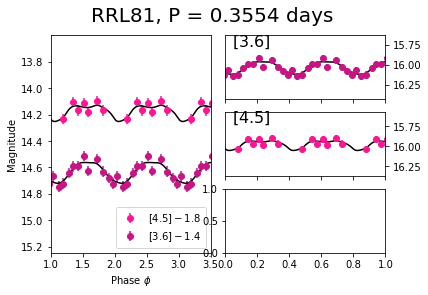

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, nan, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, 0.01098733661842092, nan, 0.012469913349568047, 0.01441594851329612, nan, 0.017151602859603626, nan, 0.020382889740956738, 0.014927759422480738, 0.012620808577274248, 0.01779479

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[3.6] - [4.5]> = 0.008    std dev = 0.022     amplitude = 0.078


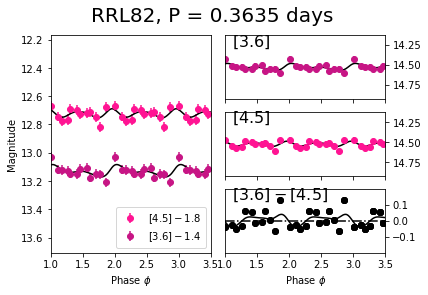

RRc
Channel 1 mags:  [16.09878237 16.23190292 16.14230113 16.23697399 16.2123601  16.23967059
 16.25374377 16.24252749 16.12825917 16.22185691 16.11900238 16.23206054]
Channel 2 mags:  [16.31222166 15.99151677 15.86693195 99.         16.17521885 16.3115598
 99.         16.13738814 16.05970005 16.19407677 16.0600374  16.0306245 ] 

RRL83 ---- Period = 0.3547 days
------------------------------------------------------
12 10


C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 16.196    std dev = 0.020     amplitude = 0.065
<[4.5]> = 16.140    std dev = 0.100     amplitude = 0.339


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Channels don't have the same number of measurements, so colour curve couldn't be plotted


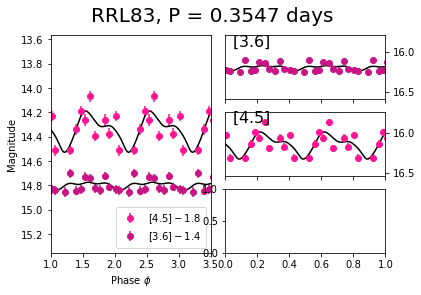

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, nan, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, 0.01098733661842092, nan, 0.012469913349568047, 0.01441594851329612, nan, 0.017151602859603626, nan, 0.020382889740956738, 0.014927759422480738, 0.012620808577274248, 0.01779479

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 14.266    std dev = 0.011     amplitude = 0.033
<[3.6] - [4.5]> = -0.005    std dev = 0.031     amplitude = 0.084


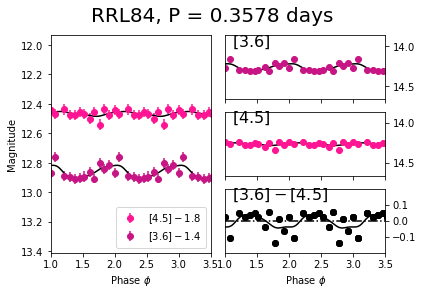

RRc
Channel 1 mags:  [14.77840232 14.69035111 14.74338671 14.77224321 14.58984212 14.68323243
 14.75060357 14.70327159 14.66499967 14.74268076 14.62808815 14.60928235]
Channel 2 mags:  [14.70871337 14.73379765 14.69916676 14.69462391 14.70561099 14.66026211
 14.64023555 14.62628889 14.59904792 14.6596962  14.67067429 14.72749695] 

RRL85 ---- Period = 0.3626 days
------------------------------------------------------
12 12
<[3.6]> = 14.700    std dev = 0.040     amplitude = 0.132
<[4.5]> = 14.674    std dev = 0.017     amplitude = 0.056


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[3.6] - [4.5]> = 0.026    std dev = 0.054     amplitude = 0.175


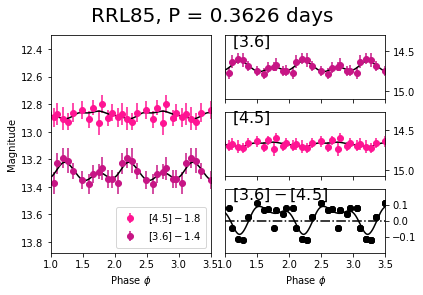

RRc
Channel 1 mags:  [15.6020245  15.69002169 15.80951119 15.73136049 99.         15.86819265
 99.         15.74691434 15.68653816 15.64053711 15.6795906  15.68649288]
Channel 2 mags:  [99.         16.06602757 15.99175739 99.         16.14587757 99.
 16.10465158 16.08532653 99.         99.         99.         16.09087297] 

RRL86 ---- Period = 0.3584 days
------------------------------------------------------
10 6


C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[3.6]> = 15.701    std dev = 0.030     amplitude = 0.111
<[4.5]> = 16.077    std dev = 0.042     amplitude = 0.136
Channels don't have the same number of measurements, so colour curve couldn't be plotted


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


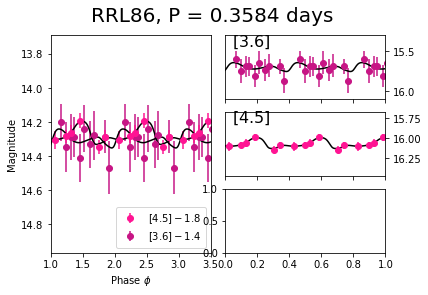

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, nan, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, 0.01098733661842092, nan, 0.012469913349568047, 0.01441594851329612, nan, 0.017151602859603626, nan, 0.020382889740956738, 0.014927759422480738, 0.012620808577274248, 0.01779479

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 16.217    std dev = 0.052     amplitude = 0.151
<[4.5]> = 16.210    std dev = 0.061     amplitude = 0.192


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Channels don't have the same number of measurements, so colour curve couldn't be plotted


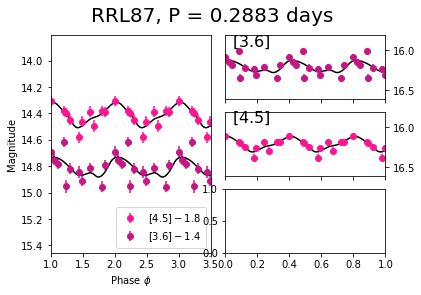

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, nan, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, 0.01098733661842092, nan, 0.012469913349568047, 0.01441594851329612, nan, 0.017151602859603626, nan, 0.020382889740956738, 0.014927759422480738, 0.012620808577274248, 0.01779479

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 14.263    std dev = 0.017     amplitude = 0.058
<[3.6] - [4.5]> = -0.011    std dev = 0.031     amplitude = 0.090


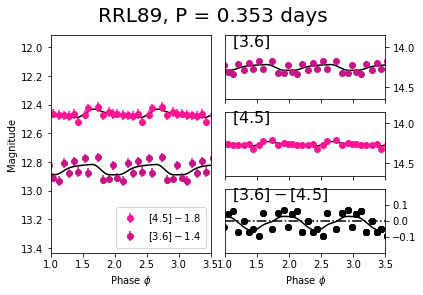

RRab
Channel 1 mags:  [15.66704118 15.99811402 15.95149531 15.94099568 15.92607138 16.02534465
 15.99204802 15.93034512 15.79996154 15.8321421  15.75054093 15.76653705]
Channel 2 mags:  [15.71554842 15.81491569 15.75546901 15.8473242  15.84158949 15.93391518
 15.902104   15.85114385 15.86036183 15.72973628 15.71756339 15.76380684] 

RRL90 ---- Period = 0.6277 days
------------------------------------------------------
12 12
<[3.6]> = 15.884    std dev = 0.087     amplitude = 0.251
<[4.5]> = 15.814    std dev = 0.060     amplitude = 0.178
<[3.6] - [4.5]> = 0.070    std dev = 0.043     amplitude = 0.141


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


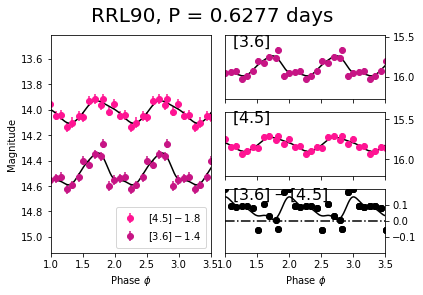

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, nan, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, 0.01098733661842092, nan, 0.012469913349568047, 0.01441594851329612, nan, 0.017151602859603626, nan, 0.020382889740956738, 0.014927759422480738, 0.012620808577274248, 0.01779479

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.647    std dev = 0.052     amplitude = 0.146
<[3.6] - [4.5]> = 0.027    std dev = 0.015     amplitude = 0.062


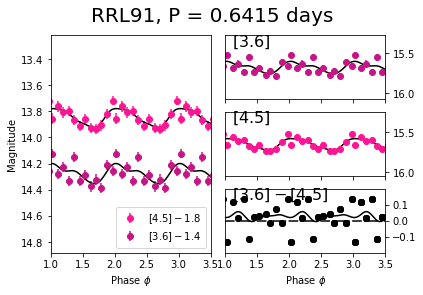

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, nan, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, 0.01098733661842092, nan, 0.012469913349568047, 0.01441594851329612, nan, 0.017151602859603626, nan, 0.020382889740956738, 0.014927759422480738, 0.012620808577274248, 0.01779479

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 16.120    std dev = 0.066     amplitude = 0.195
<[4.5]> = 16.159    std dev = 0.112     amplitude = 0.340
<[3.6] - [4.5]> = -0.039    std dev = 0.068     amplitude = 0.235

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


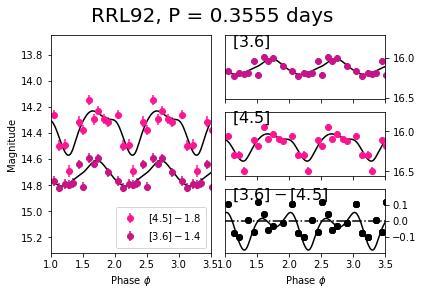

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, nan, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, 0.01098733661842092, nan, 0.012469913349568047, 0.01441594851329612, nan, 0.017151602859603626, nan, 0.020382889740956738, 0.014927759422480738, 0.012620808577274248, 0.01779479

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[3.6]> = 16.168    std dev = 0.132     amplitude = 0.414
<[4.5]> = 16.192    std dev = 0.043     amplitude = 0.143
<[3.6] - [4.5]> = -0.024    std dev = 0.156     amplitude = 0.517


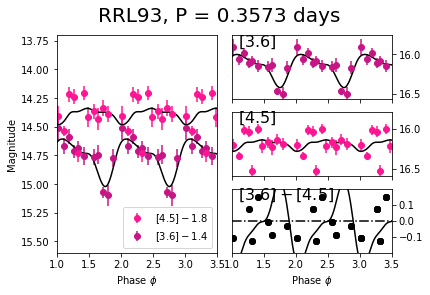

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, nan, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, 0.01098733661842092, nan, 0.012469913349568047, 0.01441594851329612, nan, 0.017151602859603626, nan, 0.020382889740956738, 0.014927759422480738, 0.012620808577274248, 0.01779479

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



<[3.6] - [4.5]> = 0.014    std dev = 0.045     amplitude = 0.140


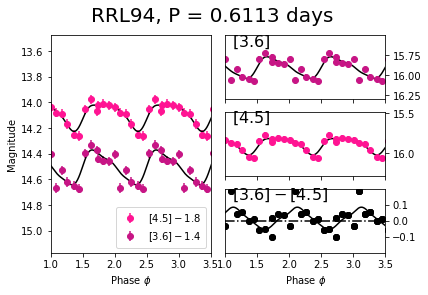

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, nan, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, 0.01098733661842092, nan, 0.012469913349568047, 0.01441594851329612, nan, 0.017151602859603626, nan, 0.020382889740956738, 0.014927759422480738, 0.012620808577274248, 0.01779479

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 16.309    std dev = 0.033     amplitude = 0.107
Channels don't have the same number of measurements, so colour curve couldn't be plotted


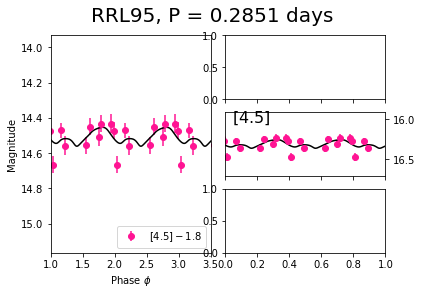

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, nan, 0.014595259382162329, 0.014451822395278757, nan, nan, nan, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, nan, 0.012358852875342366, nan, 0.01684938417110719, nan, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, nan, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, nan, nan, nan, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, nan, 0.007891469496489556, 0.0263297047389696, nan, 0.01098733661842092, nan, 0.012469913349568047, 0.01441594851329612, nan, 0.017151602859603626, nan, 0.020382889740956738, 0.014927759422480738, 0.012620808577274248, 0.01779479

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 9.899    std dev = 0.044     amplitude = 0.149
<[3.6] - [4.5]> = 0.086    std dev = 0.068     amplitude = 0.224


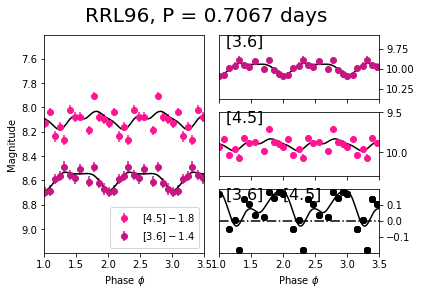

RRe (lol)
Channel 1 mags:  [16.48932463 15.8574551  15.76721007 15.69054826 16.45879251 15.74269381
 15.86393286 15.78391198 15.84194841 15.7927247  15.78586078 15.78083533]
Channel 2 mags:  [15.81819363 15.82303163 15.77515822 15.86908297 15.73112124 15.72538407
 15.76010147 15.85002803 15.82768536 15.79142743 15.78221331 15.84394451] 

RRL97 ---- Period = 0.2797 days
------------------------------------------------------
12 12
<[3.6]> = 15.883    std dev = 0.100     amplitude = 0.289


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.795    std dev = 0.026     amplitude = 0.086
<[3.6] - [4.5]> = 0.088    std dev = 0.125     amplitude = 0.371


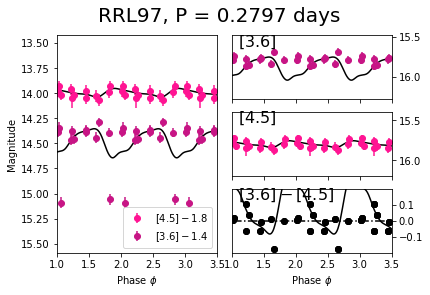

RRc
Channel 1 mags:  [12.91396909 12.92855412 12.67245627 12.70173465 12.62723084 12.59125913
 12.86814507 12.62855301 12.58756584 12.99295035 12.73675083 12.62667131]
Channel 2 mags:  [12.82427599 12.79233471 99.         12.83110764 99.         12.77135066
 12.76280071 12.68692698 99.         12.83742197 12.90013897 12.85768218] 

RRL98 ---- Period = 0.3607 days
------------------------------------------------------
12 9


C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[3.6]> = 12.737    std dev = 0.066     amplitude = 0.225
<[4.5]> = 12.809    std dev = 0.036     amplitude = 0.105
Channels don't have the same number of measurements, so colour curve couldn't be plotted


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


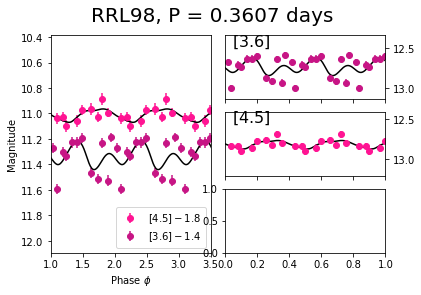

98
[15.166320131250368, 16.062549046114, 16.07514475715958, 15.074153040469103, 15.98970293798019, 15.7624305800675, 15.7801954817224, 16.01436604890409, 15.679308001507556, nan, 15.761648965163737, 15.928938471000391, nan, nan, nan, 15.837110240504098, 15.773244868496342, 15.99410115463008, 15.987823548500344, nan, 16.10275323071839, nan, 15.999854031494975, nan, 15.67024307628635, nan, 15.99737901538643, 15.889372052949458, nan, 15.898605252823803, 16.10986132392986, 15.267189224778313, nan, 16.049486433483978, 15.604707889222606, 15.901022386907721, 15.859879574307694, nan, 15.830914024157257, nan, nan, nan, nan, nan, 15.880644667004951, 15.978989951074704, 16.00928849310882, 15.803672489732563, nan, 15.951438296780513, 15.819271321621434, nan, 16.090819214806256, nan, 16.005516951946802, 15.940986078869626, nan, 15.90025391604641, nan, 16.122376178691418, 15.835330861876374, 16.126595724252482, 15.806821181066642, 16.246031686418394, 15.717921326290346, nan, 15.669037489672574, nan

ID            RA           dec units  period  mean_mag_CC  amplitude  \
0     1  15h00m53.07s  -82d12m49.8s    R0  0.6099       17.612       0.74   
1     2  15h00m34.18s  -82d14m25.0s    R0  0.4936       17.670       1.21   
2     3  14h59m28.92s  -82d14m39.6s    R0  0.4832       17.697       1.21   
3     4  14h59m54.70s  -82d12m38.1s    R0  0.6236       17.676       0.80   
4     5  14h59m54.37s  -82d13m39.7s    R0  0.5569       17.656       1.11   
..  ...           ...           ...   ...     ...          ...        ...   
93  112  14h59m55.31s  -82d11m50.3s    R0  0.6113       17.717       0.44   
94  153  14h59m10.31s  -82d15m46.8s    R0  0.2851       17.678       0.31   
95  167  15h00m26.10s  -82d12m35.0s    R0  0.7067       17.524       0.56   
96  171  15h00m42.31s  -82d13m45.2s    R0  0.2797       17.666       0.22   
97  173  14h59m09.00s  -82d11m11.3s    R0  0.3607       14.200        NaN   

   colour type  id_new  ...  mean_photerr_amp_ch2  mean_photerr_mon_ch1  \
0       V  RR0       0  ...              0.007280              0.014298   
1       V  RR0       1  ...              0.017552              0.015702   
2       V  RR0       2  ...              0.024977              0.011315   
3       V  RR0       3  ...              0.003264              0.015367   
4       V  RR0       4  ...              0.015208              0.049497   
..    ...  ...     ...  ...                   ...                   ...   
93      V  RR0      93  ...              0.017109              0.010201   
94      V  RR2      94  ...              0.010328                   NaN   
95      V  RR0      95  ...                   NaN                   NaN   
96      V  RR2      96  ...                   NaN                   NaN   
97      V  RR1      97  ...                   NaN                   NaN   

    mean_photerr_mon_ch2  mean_photerr_hen_ch1  mean_photerr_hen_ch2  \
0               0.015111              0.014535              0.015277   
1               0.017038              0.016066              0.017793   
2               0.012151              0.011382              0.012224   
3               0.016370              0.015819              0.016580   
4               0.051898              0.051343              0.060295   
..                   ...                   ...                   ...   
93              0.010257              0.010214              0.010279   
94              0.016311                   NaN              0.016480   
95                   NaN                   NaN                   NaN   
96                   NaN                   NaN                   NaN   
97                   NaN                   NaN                   NaN   

    period_PL  A_ch1  A_ch2   amp_ch1   amp_ch2  
0    0.609900  0.039  0.032  0.058167  0.087357  
1    0.493600  0.039  0.033  0.264692  0.201659  
2    0.483200  0.040  0.033  0.325371  0.273611  
3    0.623600  0.040  0.033  0.096798  0.039173  
4    0.556900  0.040  0.033  0.270795  0.182498  
..        ...    ...    ...       ...       ...  
93   0.611300  0.040  0.033  0.271808  0.205309  
94   0.381942  0.041  0.034       NaN  0.107336  
95   0.706700  0.039  0.033       NaN       NaN  
96   0.374708  0.039  0.033       NaN       NaN  
97   0.483221  0.040  0.033       NaN       NaN  

[98 rows x 27 columns]

In [54]:
load_name_ch1 = 'phot_tables/'+cluster+'/individual/big_table_all_'+method+'_3p6um.pickle'
load_name_ch2 = 'phot_tables/'+cluster+'/individual/big_table_all_'+method+'_4p5um.pickle'

pickle_in = open(load_name_ch1, 'rb')
big_table_ch1 = pickle.load(pickle_in)
pickle_in = open(load_name_ch2, 'rb')
big_table_ch2 = pickle.load(pickle_in)

#file_CC = 'data/reference/CVSGC_'+cluster+'_readable.txt'
file_CC = 'data/reference/CVSGC_'+cluster+'_reduced_readable.txt'
df_CC_test_2 = pd.read_csv(file_CC, sep=',', header=0)

LC_time_gloess = []
for filename in glob.glob(base_dir+'*/'+cluster+'__e[0-9]_'+channel+'.fits', recursive=True) + glob.glob(base_dir+'*/'+cluster+'__e[0-9][0-9]_'+channel+'.fits', recursive=True):
    with fits.open(filename) as hdu_list:        
        hdr = hdu_list[0].header
    LC_time_gloess.append(Time(hdr['DATE_OBS'], format='isot', scale='utc').mjd)


ch1_smooth = 0.25
ch2_smooth = 0.25

means_ch1 = []
means_ch2 = []
stds_ch1 = []
stds_ch2 = []
photerr_mean_ch1 = []
photerr_mean_ch2 = []
photerr_amps_ch1 = []
photerr_amps_ch2 = []
photerr_mean_ch1_monson = []
photerr_mean_ch2_monson = []
photerr_mean_ch1_hendel = []
photerr_mean_ch2_hendel = []
amps_ch1 = []
amps_ch2 = []
periods = []
periods_PL = []
A_ch1 = []
A_ch2 = []

for star in range(len(df_CC_test_2)):
    
    if df_CC_test_2['type'][star] == 'SR?':
        
        print('\nStar in forbidden zone (or isnt RRab/RRc)\n')
        
        means_ch1.append(float('NaN'))
        means_ch2.append(float('NaN'))
        stds_ch1.append(float('NaN'))
        stds_ch2.append(float('NaN'))
        photerr_amps_ch1.append(float('NaN'))
        photerr_amps_ch2.append(float('NaN'))
        photerr_mean_ch1_monson.append(float('NaN'))
        photerr_mean_ch2_monson.append(float('NaN'))
        photerr_mean_ch1_hendel.append(float('NaN'))
        photerr_mean_ch2_hendel.append(float('NaN'))
        amps_ch1.append(float('NaN'))
        amps_ch2.append(float('NaN'))
        photerr_mean_ch1.append(float('NaN'))
        photerr_mean_ch2.append(float('NaN'))
        periods.append(float('NaN'))
        periods_PL.append(float('NaN'))
        A_ch1.append(float('NaN'))
        A_ch2.append(float('NaN'))
        
        continue
    
    '''if df_CC_test_2['gaia_ID'][star] != 0:
        id1 = df_CC_test_2['gaia_ID_1'][star]
        id2 = df_CC_test_2['gaia_ID_2'][star]
        gaia_id = int(str(int(id1)) + str(int(id2)))  # this method is so fucked but it's the only way to avoid int precision errors using pandas :)))))
        print('Gaia DR2 ID:', gaia_id)'''
    
    c_CC = SkyCoord(df_CC_test_2['RA'][star], df_CC_test_2['dec'][star], frame='icrs', unit='deg')

    if df_CC_test_2['type'][star] == 'RR0':
        P = df_CC_test_2['period'][star]
        P_PL = P
        print('RRab')
    elif df_CC_test_2['type'][star] == 'RR1':
        P = df_CC_test_2['period'][star]
        P_PL = P * 10**0.127
        print('RRc')
    elif df_CC_test_2['type'][star] == 'RR01':
        P = df_CC_test_2['period'][star]
        P_PL = P * 10**0.127
        print('RRd')
    elif df_CC_test_2['type'][star] == 'RR2':
        P = df_CC_test_2['period'][star]
        P_PL = P * 10**0.127
        print('RRe (lol)')
    
    periods.append(P)
    periods_PL.append(P_PL)
    temp = [i / P for i in LC_time_gloess]
    phase = temp - np.floor(temp)
    
    big_table_ch1_f = copy.copy(big_table_ch1.filled(99))
    big_table_ch2_f = copy.copy(big_table_ch2.filled(99))

    mags_ch1 = []
    mags_ch2 = []
    errs_ch1 = []
    errs_ch2 = []
    for j in range(1,13):
        if star in ch1_list:
            mags_ch1.append(big_table_ch1['mag_e'+str(j)][star])
            errs_ch1.append(big_table_ch1['err_e'+str(j)][star])
        if star in ch2_list:
            mags_ch2.append(big_table_ch2['mag_e'+str(j)][star])
            errs_ch2.append(big_table_ch2['err_e'+str(j)][star])
    
    '''if cluster == 'PAL13' and star == 1:
        print('hello')
        remove_pls = [1, 3, 6, 7]  # EPOCH number of bad point
        for j in remove_pls:
            mags_ch2[j-1] = 99
            print(mags_ch2)
        print(mags_ch2)'''
        
    '''if cluster == 'PAL13' and star == 1:
        print('hello')
        remove_pls = [2, 4, 5, 8, 9, 10, 11, 12]  # EPOCH number of bad point
        for j in remove_pls:
            mags_ch2[j-1] = 99
            print(mags_ch2)
        print(mags_ch2)'''
    
    # Since GLOESS already discards bunk magnitudes, I need to leave them in as 99:
    mags_ch1 = np.nan_to_num(mags_ch1, nan=99)
    mags_ch2 = np.nan_to_num(mags_ch2, nan=99)
    errs_ch1 = np.nan_to_num(errs_ch1, nan=99)
    errs_ch2 = np.nan_to_num(errs_ch2, nan=99)

    print('Channel 1 mags: ', mags_ch1)
    print('Channel 2 mags: ', mags_ch2, '\n')
    
    ###   EXTINCTION   ###
    
    ex_table = IrsaDust.get_extinction_table(c_CC)
    ex_table.add_index('Filter_name')
    idx_ch1 = ex_table.loc_indices[['IRAC-1']]
    idx_ch2 = ex_table.loc_indices[['IRAC-2']]
    ext_ch1 = ex_table['A_SandF'][idx_ch1]
    ext_ch2 = ex_table['A_SandF'][idx_ch2]
    A_ch1.append(ext_ch1)
    A_ch2.append(ext_ch2)
    
    try:
        mean_ch1, amp_ch1, std_ch1, N_ch1, mean_ch2, amp_ch2, std_ch2, N_ch2 = jg.runGloess(mags_ch1, errs_ch1, mags_ch2, errs_ch2, LC_time_gloess, P, 'RRL'+str(star+1), ch1_smooth, ch2_smooth, wantcolour='yes')
        #mean_ch1, amp_ch1, std_ch1, mean_ch2, amp_ch2, std_ch2 = runGloesstest(mags_ch1, errs_ch1, mags_ch2, errs_ch2, LC_time_gloess, P, 'RRL'+str(star+1), ch1_smooth, ch2_smooth, wantcolour='yes')
    except ValueError:
        means_ch1.append(float('NaN'))
        means_ch2.append(float('NaN'))
        stds_ch1.append(float('NaN'))
        stds_ch2.append(float('NaN'))
        photerr_amps_ch1.append(float('NaN'))
        photerr_amps_ch2.append(float('NaN'))
        photerr_mean_ch1_monson.append(float('NaN'))
        photerr_mean_ch2_monson.append(float('NaN'))
        photerr_mean_ch1_hendel.append(float('NaN'))
        photerr_mean_ch2_hendel.append(float('NaN'))
        amps_ch1.append(float('NaN'))
        amps_ch2.append(float('NaN'))
        photerr_mean_ch1.append(float('NaN'))
        photerr_mean_ch2.append(float('NaN'))
        #periods.append(float('NaN'))
        #periods_PL.append(float('NaN'))
        #A_ch1.append(float('NaN'))
        #A_ch2.append(float('NaN'))
        
        continue
    
    if mean_ch1 <= 15. or mean_ch2 <= 15. or mean_ch1 >= 16.4 or mean_ch2 >= 16.4 or star == 96:
        means_ch1.append(float('NaN'))
        means_ch2.append(float('NaN'))
        stds_ch1.append(float('NaN'))
        stds_ch2.append(float('NaN'))
        photerr_amps_ch1.append(float('NaN'))
        photerr_amps_ch2.append(float('NaN'))
        photerr_mean_ch1_monson.append(float('NaN'))
        photerr_mean_ch2_monson.append(float('NaN'))
        photerr_mean_ch1_hendel.append(float('NaN'))
        photerr_mean_ch2_hendel.append(float('NaN'))
        amps_ch1.append(float('NaN'))
        amps_ch2.append(float('NaN'))
        photerr_mean_ch1.append(float('NaN'))
        photerr_mean_ch2.append(float('NaN'))
        #periods.append(float('NaN'))
        #periods_PL.append(float('NaN'))
        #A_ch1.append(float('NaN'))
        #A_ch2.append(float('NaN'))
        
        continue
    
    # Correcting for extinction:
    mean_ch1 -= ext_ch1
    mean_ch2 -= ext_ch2
    
    means_ch1.append(mean_ch1)
    means_ch2.append(mean_ch2)
    stds_ch1.append(std_ch1)   # uncertainty in gloess fit
    stds_ch2.append(std_ch2)
    amps_ch1.append(amp_ch1)
    amps_ch2.append(amp_ch2)
    
    ###   ERROR IN MEAN MAGNITUDE   ###
    
    # Monson 2017 approach:
    ch1_temp = [(1. / e**2) for e in errs_ch1]
    ch2_temp = [(1. / e**2) for e in errs_ch2]
    
    if ch1_temp:
        photerr_ch1_monson = np.sqrt(1. / sum(ch1_temp))
    else:
        photerr_ch1_monson = float('NaN')
    if ch2_temp:
        photerr_ch2_monson = np.sqrt(1. / sum(ch2_temp))
    else:
        photerr_ch2_monson = float('NaN')
        
    photerr_mean_ch1_monson.append(photerr_ch1_monson)
    photerr_mean_ch2_monson.append(photerr_ch2_monson)
    
    errs_ch1 = np.ma.masked_equal(errs_ch1, 99)
    errs_ch2 = np.ma.masked_equal(errs_ch2, 99)
    
    # Hendel 2018 approach:
    ch1_temp_h = [e**2 for e in errs_ch1.compressed()]
    ch2_temp_h = [e**2 for e in errs_ch2.compressed()]
    
    if ch1_temp_h:
        photerr_ch1_hendel = np.sqrt(sum(ch1_temp_h) / len(errs_ch1.compressed())**2)
    else:
        photerr_ch1_hendel = float('NaN')
    if ch2_temp_h:
        photerr_ch2_hendel = np.sqrt(sum(ch2_temp_h) / len(errs_ch2.compressed())**2)
    else:
        photerr_ch2_hendel = float('NaN')
        
    photerr_mean_ch1_hendel.append(photerr_ch1_hendel)
    photerr_mean_ch2_hendel.append(photerr_ch2_hendel)
        

    # My initial approach:
    if len(errs_ch1) != 0:
        photerr_ch1 = sum(errs_ch1.compressed()) / len(errs_ch1.compressed())
    else:
        photerr_ch1 = float('NaN')
    if len(errs_ch2) != 0:
        photerr_ch2 = sum(errs_ch2.compressed()) / len(errs_ch2.compressed())
    else:
        photerr_ch2 = float('NaN')
    
    photerr_mean_ch1.append(photerr_ch1)
    photerr_mean_ch2.append(photerr_ch2)
        
    # Fit error amplitude approach (instead of std:        
    photerr_amp_ch1 = amp_ch1 / np.sqrt(12 * N_ch1)
    photerr_amp_ch2 = amp_ch2 / np.sqrt(12 * N_ch2)
    
    photerr_amps_ch1.append(photerr_amp_ch1)
    photerr_amps_ch2.append(photerr_amp_ch2)
    print(photerr_amps_ch1)
    
    print('new error ch1:', photerr_amp_ch1)
    print('new error ch2:', photerr_amp_ch2)
    
    
    print('\n\n')

print(len(means_ch1))
print(means_ch1)

df_CC_test_2['mean_mag_ch1'] = means_ch1
df_CC_test_2['mean_mag_ch2'] = means_ch2
df_CC_test_2['mean_std_ch1'] = stds_ch1
df_CC_test_2['mean_std_ch2'] = stds_ch2
df_CC_test_2['mean_photerr_ch1'] = photerr_mean_ch1
df_CC_test_2['mean_photerr_ch2'] = photerr_mean_ch2
df_CC_test_2['mean_photerr_amp_ch1'] = photerr_amps_ch1
df_CC_test_2['mean_photerr_amp_ch2'] = photerr_amps_ch2
df_CC_test_2['mean_photerr_mon_ch1'] = photerr_mean_ch1_monson
df_CC_test_2['mean_photerr_mon_ch2'] = photerr_mean_ch2_monson
df_CC_test_2['mean_photerr_hen_ch1'] = photerr_mean_ch1_hendel
df_CC_test_2['mean_photerr_hen_ch2'] = photerr_mean_ch2_hendel
#df_CC_test_2['period_used'] = periods
df_CC_test_2['period_PL'] = periods_PL
df_CC_test_2['A_ch1'] = A_ch1
df_CC_test_2['A_ch2'] = A_ch2
df_CC_test_2['amp_ch1'] = amps_ch1
df_CC_test_2['amp_ch2'] = amps_ch2

df_CC_test_2


No. of RRL after masking out core and not removing based on channel membership:

In [63]:
tbl_CC_final = Table().from_pandas(df_CC_test_2)
tbl_CC_final = Table(tbl_CC_final, masked=True, copy=False)
#tbl_CC_final['mean_mag_ch1'].filled(-99.)
#tbl_CC_final['mean_mag_ch2'].filled(-99.)

tbl_CC_final

#for i in range(len(tbl_CC_final)):
#    if tbl_CC_final['mean_mag_ch1'][i] == -99 and tbl_CC_final['mean_mag_ch1'][i] == -99:
#        print('i am masked')

goodlist = []
byelist = []
for i in range(len(tbl_CC_final)):
    if isinstance(tbl_CC_final['mean_mag_ch1'][i], float) == False and isinstance(tbl_CC_final['mean_mag_ch2'][i], float) == False:
        byelist.append(i)
    else:
        goodlist.append(i)

tbl_CC_final.remove_rows(byelist)

print(goodlist)
print(len(goodlist))
print(byelist)
print(len(byelist))

n_ab = []
n_c = []
n_d = []
n_e = []
n_other = []

for i in range(len(tbl_CC_final)):
    if tbl_CC_final['type'][i] == 'RR0':
        n_ab.append(i)
    elif tbl_CC_final['type'][i] == 'RR1':
        n_c.append(i)
    elif tbl_CC_final['type'][i] == 'RR01':
        n_d.append(i)
    elif tbl_CC_final['type'][i] == 'RR2':
        n_e.append(i)
    else:
        n_other.append(i)
        
print('No. of RRab :', len(n_ab))
print('No. of RRc  :', len(n_c))
print('No. of RRd  :', len(n_d))
print('No. of RRe  :', len(n_e))
print('No. of other:', len(n_other))
print('Sum         :', len(n_ab)+len(n_c)+len(n_d)+len(n_e)+len(n_other))

tbl_CC_final.show_in_notebook()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 15, 16, 17, 18, 20, 22, 24, 26, 27, 29, 30, 31, 33, 34, 35, 36, 38, 43, 44, 45, 46, 47, 49, 50, 52, 54, 55, 57, 59, 60, 61, 62, 63, 64, 66, 69, 70, 71, 76, 78, 79, 80, 82, 85, 86, 89, 90, 91, 92, 93, 94]
62
[9, 12, 13, 14, 19, 21, 23, 25, 28, 32, 37, 39, 40, 41, 42, 48, 51, 53, 56, 58, 65, 67, 68, 72, 73, 74, 75, 77, 81, 83, 84, 87, 88, 95, 96, 97]
36
No. of RRab : 43
No. of RRc  : 8
No. of RRd  : 9
No. of RRe  : 2
No. of other: 0
Sum         : 62
